In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4120016, 828)
(4120016, 8)
validation
(639632, 828)
(639632, 8)
test
(362880, 828)
(362880, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/413 [..............................] - ETA: 11:38 - loss: 2.1484 - STD: 0.0716 - MAE: 0.2156

  4/413 [..............................] - ETA: 9s - loss: 2.0881 - STD: 0.0403 - MAE: 0.2169   

  7/413 [..............................] - ETA: 9s - loss: 2.0802 - STD: 0.0399 - MAE: 0.2168

 10/413 [..............................] - ETA: 9s - loss: 2.0697 - STD: 0.0373 - MAE: 0.2167

 13/413 [..............................] - ETA: 9s - loss: 2.0642 - STD: 0.0376 - MAE: 0.2165

 16/413 [>.............................] - ETA: 9s - loss: 2.0564 - STD: 0.0375 - MAE: 0.2163

 19/413 [>.............................] - ETA: 9s - loss: 2.0464 - STD: 0.0368 - MAE: 0.2160

 22/413 [>.............................] - ETA: 8s - loss: 2.0335 - STD: 0.0378 - MAE: 0.2155

 25/413 [>.............................] - ETA: 8s - loss: 2.0176 - STD: 0.0400 - MAE: 0.2148

 28/413 [=>............................] - ETA: 8s - loss: 2.0002 - STD: 0.0432 - MAE: 0.2140

 31/413 [=>............................] - ETA: 8s - loss: 1.9840 - STD: 0.0468 - MAE: 0.2131

 34/413 [=>............................] - ETA: 8s - loss: 1.9684 - STD: 0.0502 - MAE: 0.2122

 37/413 [=>............................] - ETA: 8s - loss: 1.9541 - STD: 0.0532 - MAE: 0.2114

 40/413 [=>............................] - ETA: 8s - loss: 1.9398 - STD: 0.0557 - MAE: 0.2106

 43/413 [==>...........................] - ETA: 8s - loss: 1.9265 - STD: 0.0580 - MAE: 0.2100

 46/413 [==>...........................] - ETA: 8s - loss: 1.9130 - STD: 0.0602 - MAE: 0.2092

 47/413 [==>...........................] - ETA: 22s - loss: 1.9130 - STD: 0.0610 - MAE: 0.2090

 50/413 [==>...........................] - ETA: 21s - loss: 1.9014 - STD: 0.0632 - MAE: 0.2084

 53/413 [==>...........................] - ETA: 20s - loss: 1.8893 - STD: 0.0654 - MAE: 0.2077

 56/413 [===>..........................] - ETA: 19s - loss: 1.8771 - STD: 0.0674 - MAE: 0.2070

 59/413 [===>..........................] - ETA: 18s - loss: 1.8646 - STD: 0.0690 - MAE: 0.2063

 62/413 [===>..........................] - ETA: 18s - loss: 1.8518 - STD: 0.0709 - MAE: 0.2056

 65/413 [===>..........................] - ETA: 17s - loss: 1.8392 - STD: 0.0728 - MAE: 0.2049

 68/413 [===>..........................] - ETA: 17s - loss: 1.8269 - STD: 0.0746 - MAE: 0.2042

 71/413 [====>.........................] - ETA: 16s - loss: 1.8145 - STD: 0.0765 - MAE: 0.2034

 74/413 [====>.........................] - ETA: 16s - loss: 1.8023 - STD: 0.0784 - MAE: 0.2027

 77/413 [====>.........................] - ETA: 15s - loss: 1.7905 - STD: 0.0804 - MAE: 0.2019

 80/413 [====>.........................] - ETA: 15s - loss: 1.7791 - STD: 0.0822 - MAE: 0.2012

 83/413 [=====>........................] - ETA: 14s - loss: 1.7677 - STD: 0.0839 - MAE: 0.2004

 86/413 [=====>........................] - ETA: 14s - loss: 1.7569 - STD: 0.0856 - MAE: 0.1997

 89/413 [=====>........................] - ETA: 13s - loss: 1.7459 - STD: 0.0873 - MAE: 0.1990

 92/413 [=====>........................] - ETA: 13s - loss: 1.7355 - STD: 0.0890 - MAE: 0.1983

 95/413 [=====>........................] - ETA: 13s - loss: 1.7253 - STD: 0.0906 - MAE: 0.1976

 98/413 [======>.......................] - ETA: 12s - loss: 1.7153 - STD: 0.0922 - MAE: 0.1969

101/413 [======>.......................] - ETA: 12s - loss: 1.7055 - STD: 0.0938 - MAE: 0.1962

104/413 [======>.......................] - ETA: 12s - loss: 1.6958 - STD: 0.0954 - MAE: 0.1954

107/413 [======>.......................] - ETA: 12s - loss: 1.6866 - STD: 0.0969 - MAE: 0.1948

110/413 [======>.......................] - ETA: 11s - loss: 1.6778 - STD: 0.0983 - MAE: 0.1941

113/413 [=======>......................] - ETA: 11s - loss: 1.6696 - STD: 0.0997 - MAE: 0.1935

116/413 [=======>......................] - ETA: 11s - loss: 1.6615 - STD: 0.1011 - MAE: 0.1928

119/413 [=======>......................] - ETA: 11s - loss: 1.6538 - STD: 0.1025 - MAE: 0.1922

122/413 [=======>......................] - ETA: 10s - loss: 1.6464 - STD: 0.1039 - MAE: 0.1916

125/413 [========>.....................] - ETA: 10s - loss: 1.6394 - STD: 0.1051 - MAE: 0.1911

128/413 [========>.....................] - ETA: 10s - loss: 1.6324 - STD: 0.1064 - MAE: 0.1905

131/413 [========>.....................] - ETA: 10s - loss: 1.6255 - STD: 0.1075 - MAE: 0.1900

134/413 [========>.....................] - ETA: 10s - loss: 1.6190 - STD: 0.1087 - MAE: 0.1894

137/413 [========>.....................] - ETA: 9s - loss: 1.6126 - STD: 0.1098 - MAE: 0.1889 

140/413 [=========>....................] - ETA: 9s - loss: 1.6064 - STD: 0.1109 - MAE: 0.1884

143/413 [=========>....................] - ETA: 9s - loss: 1.6006 - STD: 0.1119 - MAE: 0.1880

146/413 [=========>....................] - ETA: 9s - loss: 1.5952 - STD: 0.1129 - MAE: 0.1875

149/413 [=========>....................] - ETA: 9s - loss: 1.5898 - STD: 0.1138 - MAE: 0.1871

152/413 [==========>...................] - ETA: 9s - loss: 1.5845 - STD: 0.1148 - MAE: 0.1867

155/413 [==========>...................] - ETA: 8s - loss: 1.5793 - STD: 0.1156 - MAE: 0.1862

158/413 [==========>...................] - ETA: 8s - loss: 1.5744 - STD: 0.1165 - MAE: 0.1858

161/413 [==========>...................] - ETA: 8s - loss: 1.5694 - STD: 0.1174 - MAE: 0.1854

164/413 [==========>...................] - ETA: 8s - loss: 1.5649 - STD: 0.1182 - MAE: 0.1850

167/413 [===========>..................] - ETA: 8s - loss: 1.5604 - STD: 0.1190 - MAE: 0.1847

170/413 [===========>..................] - ETA: 8s - loss: 1.5563 - STD: 0.1198 - MAE: 0.1843

173/413 [===========>..................] - ETA: 7s - loss: 1.5520 - STD: 0.1205 - MAE: 0.1840

176/413 [===========>..................] - ETA: 7s - loss: 1.5479 - STD: 0.1212 - MAE: 0.1836

179/413 [============>.................] - ETA: 7s - loss: 1.5439 - STD: 0.1219 - MAE: 0.1833

182/413 [============>.................] - ETA: 7s - loss: 1.5401 - STD: 0.1227 - MAE: 0.1830

185/413 [============>.................] - ETA: 7s - loss: 1.5362 - STD: 0.1233 - MAE: 0.1826

188/413 [============>.................] - ETA: 7s - loss: 1.5325 - STD: 0.1240 - MAE: 0.1823

191/413 [============>.................] - ETA: 7s - loss: 1.5288 - STD: 0.1246 - MAE: 0.1820

194/413 [=============>................] - ETA: 7s - loss: 1.5254 - STD: 0.1252 - MAE: 0.1817

197/413 [=============>................] - ETA: 6s - loss: 1.5218 - STD: 0.1259 - MAE: 0.1814

200/413 [=============>................] - ETA: 6s - loss: 1.5182 - STD: 0.1265 - MAE: 0.1811

203/413 [=============>................] - ETA: 6s - loss: 1.5149 - STD: 0.1271 - MAE: 0.1809

206/413 [=============>................] - ETA: 6s - loss: 1.5118 - STD: 0.1276 - MAE: 0.1806

209/413 [==============>...............] - ETA: 6s - loss: 1.5085 - STD: 0.1282 - MAE: 0.1803

212/413 [==============>...............] - ETA: 6s - loss: 1.5055 - STD: 0.1287 - MAE: 0.1801

215/413 [==============>...............] - ETA: 6s - loss: 1.5023 - STD: 0.1292 - MAE: 0.1798

218/413 [==============>...............] - ETA: 6s - loss: 1.4994 - STD: 0.1298 - MAE: 0.1795

221/413 [===============>..............] - ETA: 5s - loss: 1.4964 - STD: 0.1303 - MAE: 0.1793

224/413 [===============>..............] - ETA: 5s - loss: 1.4934 - STD: 0.1308 - MAE: 0.1790

227/413 [===============>..............] - ETA: 5s - loss: 1.4906 - STD: 0.1313 - MAE: 0.1788

230/413 [===============>..............] - ETA: 5s - loss: 1.4879 - STD: 0.1318 - MAE: 0.1786

233/413 [===============>..............] - ETA: 5s - loss: 1.4851 - STD: 0.1322 - MAE: 0.1783

236/413 [================>.............] - ETA: 5s - loss: 1.4824 - STD: 0.1327 - MAE: 0.1781

239/413 [================>.............] - ETA: 5s - loss: 1.4798 - STD: 0.1332 - MAE: 0.1779

242/413 [================>.............] - ETA: 5s - loss: 1.4772 - STD: 0.1336 - MAE: 0.1777

245/413 [================>.............] - ETA: 5s - loss: 1.4747 - STD: 0.1341 - MAE: 0.1774

248/413 [=================>............] - ETA: 4s - loss: 1.4723 - STD: 0.1345 - MAE: 0.1772

251/413 [=================>............] - ETA: 4s - loss: 1.4699 - STD: 0.1349 - MAE: 0.1770

254/413 [=================>............] - ETA: 4s - loss: 1.4675 - STD: 0.1354 - MAE: 0.1768

257/413 [=================>............] - ETA: 4s - loss: 1.4651 - STD: 0.1358 - MAE: 0.1766

260/413 [=================>............] - ETA: 4s - loss: 1.4628 - STD: 0.1362 - MAE: 0.1764

263/413 [==================>...........] - ETA: 4s - loss: 1.4605 - STD: 0.1366 - MAE: 0.1762

266/413 [==================>...........] - ETA: 4s - loss: 1.4583 - STD: 0.1369 - MAE: 0.1760

269/413 [==================>...........] - ETA: 4s - loss: 1.4559 - STD: 0.1373 - MAE: 0.1758

272/413 [==================>...........] - ETA: 4s - loss: 1.4537 - STD: 0.1377 - MAE: 0.1756

275/413 [==================>...........] - ETA: 4s - loss: 1.4515 - STD: 0.1381 - MAE: 0.1754

278/413 [===================>..........] - ETA: 3s - loss: 1.4494 - STD: 0.1385 - MAE: 0.1752

281/413 [===================>..........] - ETA: 3s - loss: 1.4473 - STD: 0.1388 - MAE: 0.1750

284/413 [===================>..........] - ETA: 3s - loss: 1.4452 - STD: 0.1392 - MAE: 0.1749

287/413 [===================>..........] - ETA: 3s - loss: 1.4432 - STD: 0.1396 - MAE: 0.1747

290/413 [====================>.........] - ETA: 3s - loss: 1.4411 - STD: 0.1399 - MAE: 0.1745

293/413 [====================>.........] - ETA: 3s - loss: 1.4392 - STD: 0.1403 - MAE: 0.1743

296/413 [====================>.........] - ETA: 3s - loss: 1.4375 - STD: 0.1406 - MAE: 0.1742

299/413 [====================>.........] - ETA: 3s - loss: 1.4356 - STD: 0.1409 - MAE: 0.1740

302/413 [====================>.........] - ETA: 3s - loss: 1.4336 - STD: 0.1413 - MAE: 0.1738

305/413 [=====================>........] - ETA: 3s - loss: 1.4317 - STD: 0.1416 - MAE: 0.1737

308/413 [=====================>........] - ETA: 2s - loss: 1.4299 - STD: 0.1419 - MAE: 0.1735

311/413 [=====================>........] - ETA: 2s - loss: 1.4280 - STD: 0.1422 - MAE: 0.1733

314/413 [=====================>........] - ETA: 2s - loss: 1.4263 - STD: 0.1425 - MAE: 0.1732

317/413 [======================>.......] - ETA: 2s - loss: 1.4245 - STD: 0.1428 - MAE: 0.1730

320/413 [======================>.......] - ETA: 2s - loss: 1.4228 - STD: 0.1431 - MAE: 0.1729

323/413 [======================>.......] - ETA: 2s - loss: 1.4210 - STD: 0.1434 - MAE: 0.1727

326/413 [======================>.......] - ETA: 2s - loss: 1.4193 - STD: 0.1437 - MAE: 0.1725

329/413 [======================>.......] - ETA: 2s - loss: 1.4176 - STD: 0.1440 - MAE: 0.1724

332/413 [=======================>......] - ETA: 2s - loss: 1.4159 - STD: 0.1443 - MAE: 0.1722

335/413 [=======================>......] - ETA: 2s - loss: 1.4143 - STD: 0.1446 - MAE: 0.1721

338/413 [=======================>......] - ETA: 2s - loss: 1.4129 - STD: 0.1449 - MAE: 0.1720

341/413 [=======================>......] - ETA: 2s - loss: 1.4113 - STD: 0.1451 - MAE: 0.1718

344/413 [=======================>......] - ETA: 1s - loss: 1.4097 - STD: 0.1454 - MAE: 0.1717

347/413 [========================>.....] - ETA: 1s - loss: 1.4081 - STD: 0.1457 - MAE: 0.1715

350/413 [========================>.....] - ETA: 1s - loss: 1.4065 - STD: 0.1459 - MAE: 0.1714

353/413 [========================>.....] - ETA: 1s - loss: 1.4051 - STD: 0.1462 - MAE: 0.1713

356/413 [========================>.....] - ETA: 1s - loss: 1.4037 - STD: 0.1465 - MAE: 0.1711

359/413 [=========================>....] - ETA: 1s - loss: 1.4022 - STD: 0.1467 - MAE: 0.1710

362/413 [=========================>....] - ETA: 1s - loss: 1.4008 - STD: 0.1470 - MAE: 0.1709

365/413 [=========================>....] - ETA: 1s - loss: 1.3993 - STD: 0.1472 - MAE: 0.1707

368/413 [=========================>....] - ETA: 1s - loss: 1.3979 - STD: 0.1475 - MAE: 0.1706

371/413 [=========================>....] - ETA: 1s - loss: 1.3964 - STD: 0.1477 - MAE: 0.1705

374/413 [==========================>...] - ETA: 1s - loss: 1.3949 - STD: 0.1479 - MAE: 0.1703

377/413 [==========================>...] - ETA: 0s - loss: 1.3934 - STD: 0.1482 - MAE: 0.1702

380/413 [==========================>...] - ETA: 0s - loss: 1.3919 - STD: 0.1484 - MAE: 0.1701

383/413 [==========================>...] - ETA: 0s - loss: 1.3904 - STD: 0.1487 - MAE: 0.1699

386/413 [===========================>..] - ETA: 0s - loss: 1.3890 - STD: 0.1489 - MAE: 0.1698

389/413 [===========================>..] - ETA: 0s - loss: 1.3878 - STD: 0.1491 - MAE: 0.1697

392/413 [===========================>..] - ETA: 0s - loss: 1.3866 - STD: 0.1494 - MAE: 0.1696

395/413 [===========================>..] - ETA: 0s - loss: 1.3852 - STD: 0.1496 - MAE: 0.1694

398/413 [===========================>..] - ETA: 0s - loss: 1.3841 - STD: 0.1498 - MAE: 0.1693

401/413 [============================>.] - ETA: 0s - loss: 1.3828 - STD: 0.1501 - MAE: 0.1692

404/413 [============================>.] - ETA: 0s - loss: 1.3816 - STD: 0.1503 - MAE: 0.1691

407/413 [============================>.] - ETA: 0s - loss: 1.3803 - STD: 0.1505 - MAE: 0.1690

410/413 [============================>.] - ETA: 0s - loss: 1.3790 - STD: 0.1507 - MAE: 0.1688

413/413 [==============================] - ETA: 0s - loss: 1.3776 - STD: 0.1509 - MAE: 0.1687

413/413 [==============================] - 15s 31ms/step - loss: 1.3776 - STD: 0.1509 - MAE: 0.1687 - val_loss: 1.2619 - val_STD: 0.1791 - val_MAE: 0.1556


Epoch 2/10000


  1/413 [..............................] - ETA: 21s - loss: 1.2248 - STD: 0.1793 - MAE: 0.1540

  4/413 [..............................] - ETA: 9s - loss: 1.2160 - STD: 0.1811 - MAE: 0.1530 

  7/413 [..............................] - ETA: 9s - loss: 1.2100 - STD: 0.1808 - MAE: 0.1528

 10/413 [..............................] - ETA: 9s - loss: 1.2057 - STD: 0.1809 - MAE: 0.1525

 13/413 [..............................] - ETA: 9s - loss: 1.2059 - STD: 0.1810 - MAE: 0.1525

 16/413 [>.............................] - ETA: 8s - loss: 1.2044 - STD: 0.1809 - MAE: 0.1524

 19/413 [>.............................] - ETA: 8s - loss: 1.2028 - STD: 0.1809 - MAE: 0.1523

 22/413 [>.............................] - ETA: 8s - loss: 1.2013 - STD: 0.1809 - MAE: 0.1523

 25/413 [>.............................] - ETA: 8s - loss: 1.1997 - STD: 0.1809 - MAE: 0.1522

 28/413 [=>............................] - ETA: 8s - loss: 1.1988 - STD: 0.1810 - MAE: 0.1521

 31/413 [=>............................] - ETA: 8s - loss: 1.1981 - STD: 0.1810 - MAE: 0.1520

 34/413 [=>............................] - ETA: 8s - loss: 1.1987 - STD: 0.1811 - MAE: 0.1520

 37/413 [=>............................] - ETA: 8s - loss: 1.2027 - STD: 0.1813 - MAE: 0.1522

 40/413 [=>............................] - ETA: 8s - loss: 1.2014 - STD: 0.1813 - MAE: 0.1521

 43/413 [==>...........................] - ETA: 8s - loss: 1.2011 - STD: 0.1813 - MAE: 0.1521

 46/413 [==>...........................] - ETA: 8s - loss: 1.1997 - STD: 0.1814 - MAE: 0.1520

 49/413 [==>...........................] - ETA: 8s - loss: 1.1989 - STD: 0.1815 - MAE: 0.1519

 52/413 [==>...........................] - ETA: 8s - loss: 1.1980 - STD: 0.1815 - MAE: 0.1519

 55/413 [==>...........................] - ETA: 8s - loss: 1.1987 - STD: 0.1816 - MAE: 0.1519

 58/413 [===>..........................] - ETA: 8s - loss: 1.1988 - STD: 0.1817 - MAE: 0.1518

 61/413 [===>..........................] - ETA: 7s - loss: 1.1987 - STD: 0.1817 - MAE: 0.1518

 64/413 [===>..........................] - ETA: 7s - loss: 1.1990 - STD: 0.1818 - MAE: 0.1518

 67/413 [===>..........................] - ETA: 7s - loss: 1.1990 - STD: 0.1819 - MAE: 0.1518

 70/413 [====>.........................] - ETA: 7s - loss: 1.1990 - STD: 0.1819 - MAE: 0.1518

 73/413 [====>.........................] - ETA: 7s - loss: 1.1989 - STD: 0.1819 - MAE: 0.1518

 76/413 [====>.........................] - ETA: 7s - loss: 1.1985 - STD: 0.1819 - MAE: 0.1518

 79/413 [====>.........................] - ETA: 7s - loss: 1.1983 - STD: 0.1819 - MAE: 0.1517

 82/413 [====>.........................] - ETA: 7s - loss: 1.1978 - STD: 0.1819 - MAE: 0.1517

 85/413 [=====>........................] - ETA: 7s - loss: 1.1970 - STD: 0.1820 - MAE: 0.1516

 88/413 [=====>........................] - ETA: 7s - loss: 1.1965 - STD: 0.1821 - MAE: 0.1516

 91/413 [=====>........................] - ETA: 7s - loss: 1.1961 - STD: 0.1821 - MAE: 0.1515

 94/413 [=====>........................] - ETA: 7s - loss: 1.1953 - STD: 0.1822 - MAE: 0.1515

 97/413 [======>.......................] - ETA: 7s - loss: 1.1948 - STD: 0.1823 - MAE: 0.1514

100/413 [======>.......................] - ETA: 7s - loss: 1.1941 - STD: 0.1823 - MAE: 0.1514

103/413 [======>.......................] - ETA: 7s - loss: 1.1938 - STD: 0.1824 - MAE: 0.1513

106/413 [======>.......................] - ETA: 6s - loss: 1.1932 - STD: 0.1824 - MAE: 0.1513

109/413 [======>.......................] - ETA: 6s - loss: 1.1926 - STD: 0.1825 - MAE: 0.1512

112/413 [=======>......................] - ETA: 6s - loss: 1.1922 - STD: 0.1825 - MAE: 0.1512

115/413 [=======>......................] - ETA: 6s - loss: 1.1918 - STD: 0.1826 - MAE: 0.1511

118/413 [=======>......................] - ETA: 6s - loss: 1.1911 - STD: 0.1826 - MAE: 0.1511

121/413 [=======>......................] - ETA: 6s - loss: 1.1905 - STD: 0.1826 - MAE: 0.1510

124/413 [========>.....................] - ETA: 6s - loss: 1.1901 - STD: 0.1827 - MAE: 0.1510

127/413 [========>.....................] - ETA: 6s - loss: 1.1896 - STD: 0.1828 - MAE: 0.1509

130/413 [========>.....................] - ETA: 6s - loss: 1.1891 - STD: 0.1829 - MAE: 0.1509

133/413 [========>.....................] - ETA: 6s - loss: 1.1887 - STD: 0.1829 - MAE: 0.1508

136/413 [========>.....................] - ETA: 6s - loss: 1.1884 - STD: 0.1830 - MAE: 0.1508

139/413 [=========>....................] - ETA: 6s - loss: 1.1882 - STD: 0.1830 - MAE: 0.1508

142/413 [=========>....................] - ETA: 6s - loss: 1.1877 - STD: 0.1831 - MAE: 0.1507

145/413 [=========>....................] - ETA: 6s - loss: 1.1873 - STD: 0.1832 - MAE: 0.1507

148/413 [=========>....................] - ETA: 5s - loss: 1.1872 - STD: 0.1833 - MAE: 0.1506

151/413 [=========>....................] - ETA: 5s - loss: 1.1878 - STD: 0.1834 - MAE: 0.1506

154/413 [==========>...................] - ETA: 5s - loss: 1.1876 - STD: 0.1834 - MAE: 0.1506

157/413 [==========>...................] - ETA: 5s - loss: 1.1874 - STD: 0.1834 - MAE: 0.1506

160/413 [==========>...................] - ETA: 5s - loss: 1.1871 - STD: 0.1835 - MAE: 0.1506

163/413 [==========>...................] - ETA: 5s - loss: 1.1866 - STD: 0.1835 - MAE: 0.1505

166/413 [===========>..................] - ETA: 5s - loss: 1.1861 - STD: 0.1836 - MAE: 0.1505

169/413 [===========>..................] - ETA: 5s - loss: 1.1856 - STD: 0.1836 - MAE: 0.1504

172/413 [===========>..................] - ETA: 5s - loss: 1.1850 - STD: 0.1837 - MAE: 0.1504

175/413 [===========>..................] - ETA: 5s - loss: 1.1844 - STD: 0.1838 - MAE: 0.1503

178/413 [===========>..................] - ETA: 5s - loss: 1.1840 - STD: 0.1838 - MAE: 0.1503

181/413 [============>.................] - ETA: 5s - loss: 1.1836 - STD: 0.1838 - MAE: 0.1502

184/413 [============>.................] - ETA: 5s - loss: 1.1829 - STD: 0.1839 - MAE: 0.1502

187/413 [============>.................] - ETA: 5s - loss: 1.1824 - STD: 0.1840 - MAE: 0.1501

190/413 [============>.................] - ETA: 5s - loss: 1.1819 - STD: 0.1840 - MAE: 0.1501

193/413 [=============>................] - ETA: 4s - loss: 1.1814 - STD: 0.1841 - MAE: 0.1500

196/413 [=============>................] - ETA: 4s - loss: 1.1810 - STD: 0.1841 - MAE: 0.1500

199/413 [=============>................] - ETA: 4s - loss: 1.1805 - STD: 0.1842 - MAE: 0.1499

202/413 [=============>................] - ETA: 4s - loss: 1.1800 - STD: 0.1842 - MAE: 0.1499

205/413 [=============>................] - ETA: 4s - loss: 1.1794 - STD: 0.1843 - MAE: 0.1498

208/413 [==============>...............] - ETA: 4s - loss: 1.1789 - STD: 0.1844 - MAE: 0.1498

211/413 [==============>...............] - ETA: 4s - loss: 1.1783 - STD: 0.1844 - MAE: 0.1497

214/413 [==============>...............] - ETA: 4s - loss: 1.1782 - STD: 0.1845 - MAE: 0.1497

217/413 [==============>...............] - ETA: 4s - loss: 1.1783 - STD: 0.1845 - MAE: 0.1497

220/413 [==============>...............] - ETA: 4s - loss: 1.1781 - STD: 0.1846 - MAE: 0.1497

223/413 [===============>..............] - ETA: 4s - loss: 1.1776 - STD: 0.1847 - MAE: 0.1496

226/413 [===============>..............] - ETA: 4s - loss: 1.1770 - STD: 0.1847 - MAE: 0.1496

229/413 [===============>..............] - ETA: 4s - loss: 1.1765 - STD: 0.1848 - MAE: 0.1495

232/413 [===============>..............] - ETA: 4s - loss: 1.1761 - STD: 0.1848 - MAE: 0.1495

235/413 [================>.............] - ETA: 4s - loss: 1.1756 - STD: 0.1849 - MAE: 0.1494

238/413 [================>.............] - ETA: 3s - loss: 1.1751 - STD: 0.1849 - MAE: 0.1494

241/413 [================>.............] - ETA: 3s - loss: 1.1747 - STD: 0.1850 - MAE: 0.1493

244/413 [================>.............] - ETA: 3s - loss: 1.1744 - STD: 0.1851 - MAE: 0.1493

247/413 [================>.............] - ETA: 3s - loss: 1.1742 - STD: 0.1851 - MAE: 0.1493

250/413 [=================>............] - ETA: 3s - loss: 1.1736 - STD: 0.1852 - MAE: 0.1492

253/413 [=================>............] - ETA: 3s - loss: 1.1733 - STD: 0.1852 - MAE: 0.1492

256/413 [=================>............] - ETA: 3s - loss: 1.1729 - STD: 0.1853 - MAE: 0.1491

259/413 [=================>............] - ETA: 3s - loss: 1.1724 - STD: 0.1853 - MAE: 0.1491

262/413 [==================>...........] - ETA: 3s - loss: 1.1719 - STD: 0.1854 - MAE: 0.1490

265/413 [==================>...........] - ETA: 3s - loss: 1.1713 - STD: 0.1854 - MAE: 0.1490

268/413 [==================>...........] - ETA: 3s - loss: 1.1709 - STD: 0.1855 - MAE: 0.1489

271/413 [==================>...........] - ETA: 3s - loss: 1.1708 - STD: 0.1855 - MAE: 0.1489

274/413 [==================>...........] - ETA: 3s - loss: 1.1707 - STD: 0.1856 - MAE: 0.1489

277/413 [===================>..........] - ETA: 3s - loss: 1.1704 - STD: 0.1857 - MAE: 0.1488

280/413 [===================>..........] - ETA: 3s - loss: 1.1700 - STD: 0.1857 - MAE: 0.1488

283/413 [===================>..........] - ETA: 2s - loss: 1.1695 - STD: 0.1858 - MAE: 0.1488

286/413 [===================>..........] - ETA: 2s - loss: 1.1690 - STD: 0.1858 - MAE: 0.1487

289/413 [===================>..........] - ETA: 2s - loss: 1.1685 - STD: 0.1859 - MAE: 0.1487

292/413 [====================>.........] - ETA: 2s - loss: 1.1681 - STD: 0.1860 - MAE: 0.1486

295/413 [====================>.........] - ETA: 2s - loss: 1.1677 - STD: 0.1860 - MAE: 0.1486

298/413 [====================>.........] - ETA: 2s - loss: 1.1672 - STD: 0.1861 - MAE: 0.1485

301/413 [====================>.........] - ETA: 2s - loss: 1.1668 - STD: 0.1861 - MAE: 0.1485

304/413 [=====================>........] - ETA: 2s - loss: 1.1663 - STD: 0.1862 - MAE: 0.1484

307/413 [=====================>........] - ETA: 2s - loss: 1.1661 - STD: 0.1862 - MAE: 0.1484

310/413 [=====================>........] - ETA: 2s - loss: 1.1661 - STD: 0.1863 - MAE: 0.1484

313/413 [=====================>........] - ETA: 2s - loss: 1.1658 - STD: 0.1863 - MAE: 0.1484

316/413 [=====================>........] - ETA: 2s - loss: 1.1655 - STD: 0.1864 - MAE: 0.1483

319/413 [======================>.......] - ETA: 2s - loss: 1.1651 - STD: 0.1864 - MAE: 0.1483

322/413 [======================>.......] - ETA: 2s - loss: 1.1648 - STD: 0.1865 - MAE: 0.1482

325/413 [======================>.......] - ETA: 1s - loss: 1.1644 - STD: 0.1865 - MAE: 0.1482

328/413 [======================>.......] - ETA: 1s - loss: 1.1641 - STD: 0.1866 - MAE: 0.1482

331/413 [=======================>......] - ETA: 1s - loss: 1.1638 - STD: 0.1866 - MAE: 0.1481

334/413 [=======================>......] - ETA: 1s - loss: 1.1634 - STD: 0.1866 - MAE: 0.1481

337/413 [=======================>......] - ETA: 1s - loss: 1.1630 - STD: 0.1867 - MAE: 0.1481

340/413 [=======================>......] - ETA: 1s - loss: 1.1626 - STD: 0.1867 - MAE: 0.1480

343/413 [=======================>......] - ETA: 1s - loss: 1.1622 - STD: 0.1868 - MAE: 0.1480

346/413 [========================>.....] - ETA: 1s - loss: 1.1619 - STD: 0.1868 - MAE: 0.1479

349/413 [========================>.....] - ETA: 1s - loss: 1.1616 - STD: 0.1869 - MAE: 0.1479

352/413 [========================>.....] - ETA: 1s - loss: 1.1613 - STD: 0.1869 - MAE: 0.1479

355/413 [========================>.....] - ETA: 1s - loss: 1.1612 - STD: 0.1870 - MAE: 0.1478

358/413 [=========================>....] - ETA: 1s - loss: 1.1608 - STD: 0.1870 - MAE: 0.1478

361/413 [=========================>....] - ETA: 1s - loss: 1.1605 - STD: 0.1871 - MAE: 0.1478

364/413 [=========================>....] - ETA: 1s - loss: 1.1602 - STD: 0.1871 - MAE: 0.1477

367/413 [=========================>....] - ETA: 1s - loss: 1.1598 - STD: 0.1872 - MAE: 0.1477

370/413 [=========================>....] - ETA: 0s - loss: 1.1593 - STD: 0.1872 - MAE: 0.1477

373/413 [==========================>...] - ETA: 0s - loss: 1.1590 - STD: 0.1873 - MAE: 0.1476

376/413 [==========================>...] - ETA: 0s - loss: 1.1590 - STD: 0.1873 - MAE: 0.1476

379/413 [==========================>...] - ETA: 0s - loss: 1.1587 - STD: 0.1874 - MAE: 0.1476

382/413 [==========================>...] - ETA: 0s - loss: 1.1585 - STD: 0.1874 - MAE: 0.1475

385/413 [==========================>...] - ETA: 0s - loss: 1.1582 - STD: 0.1874 - MAE: 0.1475

388/413 [===========================>..] - ETA: 0s - loss: 1.1578 - STD: 0.1875 - MAE: 0.1475

391/413 [===========================>..] - ETA: 0s - loss: 1.1575 - STD: 0.1875 - MAE: 0.1474

394/413 [===========================>..] - ETA: 0s - loss: 1.1571 - STD: 0.1876 - MAE: 0.1474

397/413 [===========================>..] - ETA: 0s - loss: 1.1567 - STD: 0.1876 - MAE: 0.1474

400/413 [============================>.] - ETA: 0s - loss: 1.1564 - STD: 0.1877 - MAE: 0.1473

403/413 [============================>.] - ETA: 0s - loss: 1.1561 - STD: 0.1877 - MAE: 0.1473

407/413 [============================>.] - ETA: 0s - loss: 1.1559 - STD: 0.1877 - MAE: 0.1472

410/413 [============================>.] - ETA: 0s - loss: 1.1556 - STD: 0.1878 - MAE: 0.1472

413/413 [==============================] - ETA: 0s - loss: 1.1555 - STD: 0.1879 - MAE: 0.1472

413/413 [==============================] - 10s 25ms/step - loss: 1.1555 - STD: 0.1879 - MAE: 0.1472 - val_loss: 1.1344 - val_STD: 0.1959 - val_MAE: 0.1425


Epoch 3/10000


  1/413 [..............................] - ETA: 21s - loss: 1.1221 - STD: 0.1969 - MAE: 0.1419

  4/413 [..............................] - ETA: 9s - loss: 1.1328 - STD: 0.1963 - MAE: 0.1428 

  7/413 [..............................] - ETA: 9s - loss: 1.1255 - STD: 0.1954 - MAE: 0.1427

 10/413 [..............................] - ETA: 9s - loss: 1.1259 - STD: 0.1953 - MAE: 0.1427

 13/413 [..............................] - ETA: 9s - loss: 1.1249 - STD: 0.1949 - MAE: 0.1428

 16/413 [>.............................] - ETA: 8s - loss: 1.1216 - STD: 0.1951 - MAE: 0.1425

 19/413 [>.............................] - ETA: 8s - loss: 1.1179 - STD: 0.1951 - MAE: 0.1423

 22/413 [>.............................] - ETA: 8s - loss: 1.1172 - STD: 0.1951 - MAE: 0.1422

 25/413 [>.............................] - ETA: 8s - loss: 1.1144 - STD: 0.1951 - MAE: 0.1421

 28/413 [=>............................] - ETA: 8s - loss: 1.1124 - STD: 0.1951 - MAE: 0.1420

 31/413 [=>............................] - ETA: 8s - loss: 1.1101 - STD: 0.1951 - MAE: 0.1418

 34/413 [=>............................] - ETA: 8s - loss: 1.1094 - STD: 0.1950 - MAE: 0.1419

 37/413 [=>............................] - ETA: 8s - loss: 1.1081 - STD: 0.1949 - MAE: 0.1418

 40/413 [=>............................] - ETA: 8s - loss: 1.1082 - STD: 0.1950 - MAE: 0.1418

 43/413 [==>...........................] - ETA: 8s - loss: 1.1080 - STD: 0.1950 - MAE: 0.1418

 45/413 [==>...........................] - ETA: 8s - loss: 1.1077 - STD: 0.1951 - MAE: 0.1418

 48/413 [==>...........................] - ETA: 8s - loss: 1.1072 - STD: 0.1951 - MAE: 0.1417

 51/413 [==>...........................] - ETA: 8s - loss: 1.1071 - STD: 0.1951 - MAE: 0.1417

 54/413 [==>...........................] - ETA: 8s - loss: 1.1070 - STD: 0.1952 - MAE: 0.1417

 57/413 [===>..........................] - ETA: 8s - loss: 1.1064 - STD: 0.1952 - MAE: 0.1416

 60/413 [===>..........................] - ETA: 7s - loss: 1.1060 - STD: 0.1952 - MAE: 0.1416

 63/413 [===>..........................] - ETA: 7s - loss: 1.1054 - STD: 0.1953 - MAE: 0.1415

 66/413 [===>..........................] - ETA: 7s - loss: 1.1050 - STD: 0.1954 - MAE: 0.1415

 69/413 [====>.........................] - ETA: 7s - loss: 1.1044 - STD: 0.1954 - MAE: 0.1415

 72/413 [====>.........................] - ETA: 7s - loss: 1.1036 - STD: 0.1954 - MAE: 0.1414

 75/413 [====>.........................] - ETA: 7s - loss: 1.1043 - STD: 0.1954 - MAE: 0.1414

 78/413 [====>.........................] - ETA: 7s - loss: 1.1043 - STD: 0.1955 - MAE: 0.1414

 81/413 [====>.........................] - ETA: 7s - loss: 1.1038 - STD: 0.1955 - MAE: 0.1414

 84/413 [=====>........................] - ETA: 7s - loss: 1.1036 - STD: 0.1955 - MAE: 0.1414

 87/413 [=====>........................] - ETA: 7s - loss: 1.1032 - STD: 0.1955 - MAE: 0.1413

 90/413 [=====>........................] - ETA: 7s - loss: 1.1024 - STD: 0.1956 - MAE: 0.1413

 93/413 [=====>........................] - ETA: 7s - loss: 1.1022 - STD: 0.1956 - MAE: 0.1412

 96/413 [=====>........................] - ETA: 7s - loss: 1.1021 - STD: 0.1957 - MAE: 0.1412

 99/413 [======>.......................] - ETA: 7s - loss: 1.1014 - STD: 0.1957 - MAE: 0.1412

102/413 [======>.......................] - ETA: 7s - loss: 1.1006 - STD: 0.1958 - MAE: 0.1411

105/413 [======>.......................] - ETA: 6s - loss: 1.0996 - STD: 0.1958 - MAE: 0.1410

108/413 [======>.......................] - ETA: 6s - loss: 1.0988 - STD: 0.1958 - MAE: 0.1410

111/413 [=======>......................] - ETA: 6s - loss: 1.0985 - STD: 0.1959 - MAE: 0.1409

114/413 [=======>......................] - ETA: 6s - loss: 1.0992 - STD: 0.1960 - MAE: 0.1409

117/413 [=======>......................] - ETA: 6s - loss: 1.1002 - STD: 0.1961 - MAE: 0.1409

120/413 [=======>......................] - ETA: 6s - loss: 1.0998 - STD: 0.1962 - MAE: 0.1409

123/413 [=======>......................] - ETA: 6s - loss: 1.0994 - STD: 0.1962 - MAE: 0.1408

126/413 [========>.....................] - ETA: 6s - loss: 1.0990 - STD: 0.1962 - MAE: 0.1408

129/413 [========>.....................] - ETA: 6s - loss: 1.0986 - STD: 0.1962 - MAE: 0.1408

132/413 [========>.....................] - ETA: 6s - loss: 1.0982 - STD: 0.1962 - MAE: 0.1408

135/413 [========>.....................] - ETA: 6s - loss: 1.0978 - STD: 0.1963 - MAE: 0.1407

138/413 [=========>....................] - ETA: 6s - loss: 1.0974 - STD: 0.1963 - MAE: 0.1407

141/413 [=========>....................] - ETA: 6s - loss: 1.0970 - STD: 0.1963 - MAE: 0.1406

144/413 [=========>....................] - ETA: 6s - loss: 1.0965 - STD: 0.1963 - MAE: 0.1406

147/413 [=========>....................] - ETA: 6s - loss: 1.0962 - STD: 0.1964 - MAE: 0.1406

150/413 [=========>....................] - ETA: 5s - loss: 1.0965 - STD: 0.1964 - MAE: 0.1406

153/413 [==========>...................] - ETA: 5s - loss: 1.0964 - STD: 0.1965 - MAE: 0.1406

156/413 [==========>...................] - ETA: 5s - loss: 1.0967 - STD: 0.1965 - MAE: 0.1406

159/413 [==========>...................] - ETA: 5s - loss: 1.0966 - STD: 0.1965 - MAE: 0.1406

162/413 [==========>...................] - ETA: 5s - loss: 1.0967 - STD: 0.1966 - MAE: 0.1405

165/413 [==========>...................] - ETA: 5s - loss: 1.0963 - STD: 0.1966 - MAE: 0.1405

168/413 [===========>..................] - ETA: 5s - loss: 1.0959 - STD: 0.1966 - MAE: 0.1405

171/413 [===========>..................] - ETA: 5s - loss: 1.0954 - STD: 0.1966 - MAE: 0.1405

174/413 [===========>..................] - ETA: 5s - loss: 1.0954 - STD: 0.1967 - MAE: 0.1404

177/413 [===========>..................] - ETA: 5s - loss: 1.0954 - STD: 0.1967 - MAE: 0.1404

180/413 [============>.................] - ETA: 5s - loss: 1.0956 - STD: 0.1968 - MAE: 0.1404

183/413 [============>.................] - ETA: 5s - loss: 1.0957 - STD: 0.1968 - MAE: 0.1404

186/413 [============>.................] - ETA: 5s - loss: 1.0964 - STD: 0.1969 - MAE: 0.1404

189/413 [============>.................] - ETA: 5s - loss: 1.0973 - STD: 0.1969 - MAE: 0.1404

192/413 [============>.................] - ETA: 5s - loss: 1.0984 - STD: 0.1969 - MAE: 0.1405

195/413 [=============>................] - ETA: 4s - loss: 1.0993 - STD: 0.1969 - MAE: 0.1405

198/413 [=============>................] - ETA: 4s - loss: 1.1000 - STD: 0.1969 - MAE: 0.1406

201/413 [=============>................] - ETA: 4s - loss: 1.1000 - STD: 0.1968 - MAE: 0.1406

204/413 [=============>................] - ETA: 4s - loss: 1.0999 - STD: 0.1968 - MAE: 0.1406

207/413 [==============>...............] - ETA: 4s - loss: 1.0996 - STD: 0.1968 - MAE: 0.1406

210/413 [==============>...............] - ETA: 4s - loss: 1.0992 - STD: 0.1968 - MAE: 0.1406

213/413 [==============>...............] - ETA: 4s - loss: 1.0988 - STD: 0.1968 - MAE: 0.1406

216/413 [==============>...............] - ETA: 4s - loss: 1.0984 - STD: 0.1968 - MAE: 0.1405

219/413 [==============>...............] - ETA: 4s - loss: 1.0981 - STD: 0.1968 - MAE: 0.1405

222/413 [===============>..............] - ETA: 4s - loss: 1.0975 - STD: 0.1968 - MAE: 0.1405

225/413 [===============>..............] - ETA: 4s - loss: 1.0971 - STD: 0.1968 - MAE: 0.1404

228/413 [===============>..............] - ETA: 4s - loss: 1.0968 - STD: 0.1969 - MAE: 0.1404

231/413 [===============>..............] - ETA: 4s - loss: 1.0964 - STD: 0.1969 - MAE: 0.1404

234/413 [===============>..............] - ETA: 4s - loss: 1.0958 - STD: 0.1969 - MAE: 0.1403

237/413 [================>.............] - ETA: 3s - loss: 1.0956 - STD: 0.1969 - MAE: 0.1403

240/413 [================>.............] - ETA: 3s - loss: 1.0952 - STD: 0.1970 - MAE: 0.1403

244/413 [================>.............] - ETA: 3s - loss: 1.0951 - STD: 0.1970 - MAE: 0.1403

247/413 [================>.............] - ETA: 3s - loss: 1.0954 - STD: 0.1971 - MAE: 0.1403

250/413 [=================>............] - ETA: 3s - loss: 1.0954 - STD: 0.1971 - MAE: 0.1403

253/413 [=================>............] - ETA: 3s - loss: 1.0956 - STD: 0.1972 - MAE: 0.1403

256/413 [=================>............] - ETA: 3s - loss: 1.0954 - STD: 0.1972 - MAE: 0.1402

259/413 [=================>............] - ETA: 3s - loss: 1.0951 - STD: 0.1972 - MAE: 0.1402

262/413 [==================>...........] - ETA: 3s - loss: 1.0949 - STD: 0.1972 - MAE: 0.1402

265/413 [==================>...........] - ETA: 3s - loss: 1.0947 - STD: 0.1973 - MAE: 0.1402

268/413 [==================>...........] - ETA: 3s - loss: 1.0946 - STD: 0.1973 - MAE: 0.1401

271/413 [==================>...........] - ETA: 3s - loss: 1.0943 - STD: 0.1973 - MAE: 0.1401

273/413 [==================>...........] - ETA: 3s - loss: 1.0942 - STD: 0.1973 - MAE: 0.1401

276/413 [===================>..........] - ETA: 3s - loss: 1.0938 - STD: 0.1973 - MAE: 0.1401

279/413 [===================>..........] - ETA: 3s - loss: 1.0935 - STD: 0.1974 - MAE: 0.1401

282/413 [===================>..........] - ETA: 2s - loss: 1.0932 - STD: 0.1974 - MAE: 0.1400

285/413 [===================>..........] - ETA: 2s - loss: 1.0928 - STD: 0.1974 - MAE: 0.1400

288/413 [===================>..........] - ETA: 2s - loss: 1.0925 - STD: 0.1974 - MAE: 0.1400

291/413 [====================>.........] - ETA: 2s - loss: 1.0921 - STD: 0.1975 - MAE: 0.1399

294/413 [====================>.........] - ETA: 2s - loss: 1.0917 - STD: 0.1975 - MAE: 0.1399

297/413 [====================>.........] - ETA: 2s - loss: 1.0914 - STD: 0.1975 - MAE: 0.1399

300/413 [====================>.........] - ETA: 2s - loss: 1.0911 - STD: 0.1976 - MAE: 0.1398

303/413 [=====================>........] - ETA: 2s - loss: 1.0908 - STD: 0.1976 - MAE: 0.1398

306/413 [=====================>........] - ETA: 2s - loss: 1.0904 - STD: 0.1976 - MAE: 0.1398

309/413 [=====================>........] - ETA: 2s - loss: 1.0901 - STD: 0.1977 - MAE: 0.1397

312/413 [=====================>........] - ETA: 2s - loss: 1.0899 - STD: 0.1977 - MAE: 0.1397

315/413 [=====================>........] - ETA: 2s - loss: 1.0894 - STD: 0.1977 - MAE: 0.1397

318/413 [======================>.......] - ETA: 2s - loss: 1.0892 - STD: 0.1978 - MAE: 0.1397

321/413 [======================>.......] - ETA: 2s - loss: 1.0889 - STD: 0.1978 - MAE: 0.1396

324/413 [======================>.......] - ETA: 2s - loss: 1.0887 - STD: 0.1979 - MAE: 0.1396

327/413 [======================>.......] - ETA: 1s - loss: 1.0884 - STD: 0.1979 - MAE: 0.1396

330/413 [======================>.......] - ETA: 1s - loss: 1.0881 - STD: 0.1979 - MAE: 0.1395

333/413 [=======================>......] - ETA: 1s - loss: 1.0878 - STD: 0.1979 - MAE: 0.1395

336/413 [=======================>......] - ETA: 1s - loss: 1.0875 - STD: 0.1980 - MAE: 0.1395

339/413 [=======================>......] - ETA: 1s - loss: 1.0873 - STD: 0.1980 - MAE: 0.1395

342/413 [=======================>......] - ETA: 1s - loss: 1.0870 - STD: 0.1980 - MAE: 0.1394

345/413 [========================>.....] - ETA: 1s - loss: 1.0867 - STD: 0.1981 - MAE: 0.1394

348/413 [========================>.....] - ETA: 1s - loss: 1.0865 - STD: 0.1981 - MAE: 0.1394

351/413 [========================>.....] - ETA: 1s - loss: 1.0862 - STD: 0.1981 - MAE: 0.1393

353/413 [========================>.....] - ETA: 1s - loss: 1.0860 - STD: 0.1982 - MAE: 0.1393

356/413 [========================>.....] - ETA: 1s - loss: 1.0857 - STD: 0.1982 - MAE: 0.1393

359/413 [=========================>....] - ETA: 1s - loss: 1.0854 - STD: 0.1982 - MAE: 0.1393

362/413 [=========================>....] - ETA: 1s - loss: 1.0851 - STD: 0.1983 - MAE: 0.1392

365/413 [=========================>....] - ETA: 1s - loss: 1.0848 - STD: 0.1983 - MAE: 0.1392

368/413 [=========================>....] - ETA: 1s - loss: 1.0846 - STD: 0.1983 - MAE: 0.1392

371/413 [=========================>....] - ETA: 0s - loss: 1.0843 - STD: 0.1984 - MAE: 0.1391

374/413 [==========================>...] - ETA: 0s - loss: 1.0841 - STD: 0.1984 - MAE: 0.1391

377/413 [==========================>...] - ETA: 0s - loss: 1.0839 - STD: 0.1984 - MAE: 0.1391

380/413 [==========================>...] - ETA: 0s - loss: 1.0835 - STD: 0.1985 - MAE: 0.1391

383/413 [==========================>...] - ETA: 0s - loss: 1.0833 - STD: 0.1985 - MAE: 0.1390

386/413 [===========================>..] - ETA: 0s - loss: 1.0831 - STD: 0.1985 - MAE: 0.1390

389/413 [===========================>..] - ETA: 0s - loss: 1.0828 - STD: 0.1986 - MAE: 0.1390

392/413 [===========================>..] - ETA: 0s - loss: 1.0827 - STD: 0.1986 - MAE: 0.1390

395/413 [===========================>..] - ETA: 0s - loss: 1.0824 - STD: 0.1986 - MAE: 0.1389

398/413 [===========================>..] - ETA: 0s - loss: 1.0820 - STD: 0.1987 - MAE: 0.1389

401/413 [============================>.] - ETA: 0s - loss: 1.0817 - STD: 0.1987 - MAE: 0.1389

404/413 [============================>.] - ETA: 0s - loss: 1.0814 - STD: 0.1987 - MAE: 0.1388

407/413 [============================>.] - ETA: 0s - loss: 1.0812 - STD: 0.1988 - MAE: 0.1388

410/413 [============================>.] - ETA: 0s - loss: 1.0810 - STD: 0.1988 - MAE: 0.1388

413/413 [==============================] - ETA: 0s - loss: 1.0807 - STD: 0.1988 - MAE: 0.1388

413/413 [==============================] - 10s 25ms/step - loss: 1.0807 - STD: 0.1988 - MAE: 0.1388 - val_loss: 1.1254 - val_STD: 0.2037 - val_MAE: 0.1389


Epoch 4/10000


  1/413 [..............................] - ETA: 23s - loss: 1.0484 - STD: 0.2033 - MAE: 0.1351

  4/413 [..............................] - ETA: 9s - loss: 1.0542 - STD: 0.2034 - MAE: 0.1355 

  7/413 [..............................] - ETA: 9s - loss: 1.0468 - STD: 0.2034 - MAE: 0.1350

 10/413 [..............................] - ETA: 9s - loss: 1.0523 - STD: 0.2035 - MAE: 0.1353

 13/413 [..............................] - ETA: 9s - loss: 1.0564 - STD: 0.2034 - MAE: 0.1355

 16/413 [>.............................] - ETA: 9s - loss: 1.0547 - STD: 0.2033 - MAE: 0.1355

 19/413 [>.............................] - ETA: 8s - loss: 1.0553 - STD: 0.2034 - MAE: 0.1355

 22/413 [>.............................] - ETA: 8s - loss: 1.0558 - STD: 0.2033 - MAE: 0.1356

 25/413 [>.............................] - ETA: 8s - loss: 1.0561 - STD: 0.2033 - MAE: 0.1356

 27/413 [>.............................] - ETA: 8s - loss: 1.0546 - STD: 0.2033 - MAE: 0.1355

 30/413 [=>............................] - ETA: 8s - loss: 1.0520 - STD: 0.2033 - MAE: 0.1354

 33/413 [=>............................] - ETA: 8s - loss: 1.0507 - STD: 0.2034 - MAE: 0.1353

 36/413 [=>............................] - ETA: 8s - loss: 1.0494 - STD: 0.2034 - MAE: 0.1352

 39/413 [=>............................] - ETA: 8s - loss: 1.0485 - STD: 0.2035 - MAE: 0.1352

 42/413 [==>...........................] - ETA: 8s - loss: 1.0477 - STD: 0.2035 - MAE: 0.1351

 45/413 [==>...........................] - ETA: 8s - loss: 1.0470 - STD: 0.2035 - MAE: 0.1351

 48/413 [==>...........................] - ETA: 8s - loss: 1.0468 - STD: 0.2034 - MAE: 0.1350

 51/413 [==>...........................] - ETA: 8s - loss: 1.0462 - STD: 0.2035 - MAE: 0.1350

 54/413 [==>...........................] - ETA: 8s - loss: 1.0461 - STD: 0.2035 - MAE: 0.1350

 57/413 [===>..........................] - ETA: 8s - loss: 1.0470 - STD: 0.2035 - MAE: 0.1350

 60/413 [===>..........................] - ETA: 8s - loss: 1.0472 - STD: 0.2035 - MAE: 0.1350

 63/413 [===>..........................] - ETA: 7s - loss: 1.0468 - STD: 0.2036 - MAE: 0.1350

 66/413 [===>..........................] - ETA: 7s - loss: 1.0465 - STD: 0.2036 - MAE: 0.1350

 69/413 [====>.........................] - ETA: 7s - loss: 1.0458 - STD: 0.2036 - MAE: 0.1349

 72/413 [====>.........................] - ETA: 7s - loss: 1.0456 - STD: 0.2036 - MAE: 0.1349

 75/413 [====>.........................] - ETA: 7s - loss: 1.0450 - STD: 0.2037 - MAE: 0.1348

 78/413 [====>.........................] - ETA: 7s - loss: 1.0444 - STD: 0.2037 - MAE: 0.1348

 81/413 [====>.........................] - ETA: 7s - loss: 1.0439 - STD: 0.2037 - MAE: 0.1348

 84/413 [=====>........................] - ETA: 7s - loss: 1.0440 - STD: 0.2038 - MAE: 0.1347

 87/413 [=====>........................] - ETA: 7s - loss: 1.0437 - STD: 0.2038 - MAE: 0.1347

 90/413 [=====>........................] - ETA: 7s - loss: 1.0436 - STD: 0.2038 - MAE: 0.1347

 93/413 [=====>........................] - ETA: 7s - loss: 1.0431 - STD: 0.2038 - MAE: 0.1347

 96/413 [=====>........................] - ETA: 7s - loss: 1.0427 - STD: 0.2038 - MAE: 0.1346

 99/413 [======>.......................] - ETA: 7s - loss: 1.0426 - STD: 0.2039 - MAE: 0.1346

102/413 [======>.......................] - ETA: 7s - loss: 1.0429 - STD: 0.2039 - MAE: 0.1346

105/413 [======>.......................] - ETA: 7s - loss: 1.0430 - STD: 0.2039 - MAE: 0.1346

108/413 [======>.......................] - ETA: 6s - loss: 1.0427 - STD: 0.2040 - MAE: 0.1346

111/413 [=======>......................] - ETA: 6s - loss: 1.0430 - STD: 0.2040 - MAE: 0.1346

114/413 [=======>......................] - ETA: 6s - loss: 1.0428 - STD: 0.2040 - MAE: 0.1345

117/413 [=======>......................] - ETA: 6s - loss: 1.0438 - STD: 0.2041 - MAE: 0.1346

120/413 [=======>......................] - ETA: 6s - loss: 1.0439 - STD: 0.2041 - MAE: 0.1346

123/413 [=======>......................] - ETA: 6s - loss: 1.0442 - STD: 0.2041 - MAE: 0.1346

126/413 [========>.....................] - ETA: 6s - loss: 1.0442 - STD: 0.2041 - MAE: 0.1346

129/413 [========>.....................] - ETA: 6s - loss: 1.0445 - STD: 0.2041 - MAE: 0.1346

132/413 [========>.....................] - ETA: 6s - loss: 1.0444 - STD: 0.2041 - MAE: 0.1346

135/413 [========>.....................] - ETA: 6s - loss: 1.0445 - STD: 0.2041 - MAE: 0.1346

138/413 [=========>....................] - ETA: 6s - loss: 1.0449 - STD: 0.2041 - MAE: 0.1346

141/413 [=========>....................] - ETA: 6s - loss: 1.0449 - STD: 0.2041 - MAE: 0.1346

144/413 [=========>....................] - ETA: 6s - loss: 1.0449 - STD: 0.2041 - MAE: 0.1346

147/413 [=========>....................] - ETA: 6s - loss: 1.0445 - STD: 0.2041 - MAE: 0.1346

150/413 [=========>....................] - ETA: 5s - loss: 1.0443 - STD: 0.2041 - MAE: 0.1346

153/413 [==========>...................] - ETA: 5s - loss: 1.0440 - STD: 0.2041 - MAE: 0.1346

156/413 [==========>...................] - ETA: 5s - loss: 1.0436 - STD: 0.2041 - MAE: 0.1345

159/413 [==========>...................] - ETA: 5s - loss: 1.0432 - STD: 0.2041 - MAE: 0.1345

162/413 [==========>...................] - ETA: 5s - loss: 1.0425 - STD: 0.2042 - MAE: 0.1344

165/413 [==========>...................] - ETA: 5s - loss: 1.0423 - STD: 0.2042 - MAE: 0.1344

168/413 [===========>..................] - ETA: 5s - loss: 1.0420 - STD: 0.2042 - MAE: 0.1344

171/413 [===========>..................] - ETA: 5s - loss: 1.0418 - STD: 0.2042 - MAE: 0.1344

174/413 [===========>..................] - ETA: 5s - loss: 1.0415 - STD: 0.2042 - MAE: 0.1344

177/413 [===========>..................] - ETA: 5s - loss: 1.0412 - STD: 0.2043 - MAE: 0.1343

180/413 [============>.................] - ETA: 5s - loss: 1.0408 - STD: 0.2043 - MAE: 0.1343

183/413 [============>.................] - ETA: 5s - loss: 1.0407 - STD: 0.2043 - MAE: 0.1343

186/413 [============>.................] - ETA: 5s - loss: 1.0405 - STD: 0.2043 - MAE: 0.1343

189/413 [============>.................] - ETA: 5s - loss: 1.0402 - STD: 0.2043 - MAE: 0.1342

192/413 [============>.................] - ETA: 5s - loss: 1.0406 - STD: 0.2044 - MAE: 0.1343

195/413 [=============>................] - ETA: 4s - loss: 1.0404 - STD: 0.2044 - MAE: 0.1342

198/413 [=============>................] - ETA: 4s - loss: 1.0404 - STD: 0.2044 - MAE: 0.1342

201/413 [=============>................] - ETA: 4s - loss: 1.0403 - STD: 0.2044 - MAE: 0.1342

204/413 [=============>................] - ETA: 4s - loss: 1.0401 - STD: 0.2044 - MAE: 0.1342

207/413 [==============>...............] - ETA: 4s - loss: 1.0399 - STD: 0.2045 - MAE: 0.1342

210/413 [==============>...............] - ETA: 4s - loss: 1.0396 - STD: 0.2045 - MAE: 0.1341

213/413 [==============>...............] - ETA: 4s - loss: 1.0395 - STD: 0.2045 - MAE: 0.1341

216/413 [==============>...............] - ETA: 4s - loss: 1.0394 - STD: 0.2046 - MAE: 0.1341

219/413 [==============>...............] - ETA: 4s - loss: 1.0393 - STD: 0.2046 - MAE: 0.1341

222/413 [===============>..............] - ETA: 4s - loss: 1.0391 - STD: 0.2046 - MAE: 0.1341

225/413 [===============>..............] - ETA: 4s - loss: 1.0388 - STD: 0.2046 - MAE: 0.1340

228/413 [===============>..............] - ETA: 4s - loss: 1.0386 - STD: 0.2047 - MAE: 0.1340

231/413 [===============>..............] - ETA: 4s - loss: 1.0383 - STD: 0.2047 - MAE: 0.1340

234/413 [===============>..............] - ETA: 4s - loss: 1.0383 - STD: 0.2047 - MAE: 0.1340

237/413 [================>.............] - ETA: 3s - loss: 1.0380 - STD: 0.2047 - MAE: 0.1340

240/413 [================>.............] - ETA: 3s - loss: 1.0378 - STD: 0.2047 - MAE: 0.1339

243/413 [================>.............] - ETA: 3s - loss: 1.0377 - STD: 0.2048 - MAE: 0.1339

246/413 [================>.............] - ETA: 3s - loss: 1.0375 - STD: 0.2048 - MAE: 0.1339

249/413 [=================>............] - ETA: 3s - loss: 1.0373 - STD: 0.2048 - MAE: 0.1339

252/413 [=================>............] - ETA: 3s - loss: 1.0370 - STD: 0.2048 - MAE: 0.1339

255/413 [=================>............] - ETA: 3s - loss: 1.0367 - STD: 0.2048 - MAE: 0.1338

258/413 [=================>............] - ETA: 3s - loss: 1.0365 - STD: 0.2048 - MAE: 0.1338

261/413 [=================>............] - ETA: 3s - loss: 1.0362 - STD: 0.2049 - MAE: 0.1338

264/413 [==================>...........] - ETA: 3s - loss: 1.0361 - STD: 0.2049 - MAE: 0.1338

267/413 [==================>...........] - ETA: 3s - loss: 1.0359 - STD: 0.2049 - MAE: 0.1338

270/413 [==================>...........] - ETA: 3s - loss: 1.0356 - STD: 0.2049 - MAE: 0.1337

273/413 [==================>...........] - ETA: 3s - loss: 1.0354 - STD: 0.2050 - MAE: 0.1337

276/413 [===================>..........] - ETA: 3s - loss: 1.0354 - STD: 0.2050 - MAE: 0.1337

279/413 [===================>..........] - ETA: 3s - loss: 1.0355 - STD: 0.2050 - MAE: 0.1337

282/413 [===================>..........] - ETA: 2s - loss: 1.0356 - STD: 0.2050 - MAE: 0.1337

285/413 [===================>..........] - ETA: 2s - loss: 1.0357 - STD: 0.2051 - MAE: 0.1337

288/413 [===================>..........] - ETA: 2s - loss: 1.0358 - STD: 0.2051 - MAE: 0.1337

291/413 [====================>.........] - ETA: 2s - loss: 1.0357 - STD: 0.2051 - MAE: 0.1337

294/413 [====================>.........] - ETA: 2s - loss: 1.0356 - STD: 0.2051 - MAE: 0.1337

297/413 [====================>.........] - ETA: 2s - loss: 1.0354 - STD: 0.2051 - MAE: 0.1336

300/413 [====================>.........] - ETA: 2s - loss: 1.0352 - STD: 0.2052 - MAE: 0.1336

303/413 [=====================>........] - ETA: 2s - loss: 1.0352 - STD: 0.2052 - MAE: 0.1336

305/413 [=====================>........] - ETA: 2s - loss: 1.0350 - STD: 0.2052 - MAE: 0.1336

308/413 [=====================>........] - ETA: 2s - loss: 1.0348 - STD: 0.2052 - MAE: 0.1336

311/413 [=====================>........] - ETA: 2s - loss: 1.0351 - STD: 0.2052 - MAE: 0.1336

314/413 [=====================>........] - ETA: 2s - loss: 1.0350 - STD: 0.2053 - MAE: 0.1336

317/413 [======================>.......] - ETA: 2s - loss: 1.0352 - STD: 0.2053 - MAE: 0.1336

320/413 [======================>.......] - ETA: 2s - loss: 1.0351 - STD: 0.2053 - MAE: 0.1336

323/413 [======================>.......] - ETA: 2s - loss: 1.0350 - STD: 0.2053 - MAE: 0.1336

326/413 [======================>.......] - ETA: 1s - loss: 1.0348 - STD: 0.2053 - MAE: 0.1335

329/413 [======================>.......] - ETA: 1s - loss: 1.0346 - STD: 0.2053 - MAE: 0.1335

332/413 [=======================>......] - ETA: 1s - loss: 1.0344 - STD: 0.2053 - MAE: 0.1335

335/413 [=======================>......] - ETA: 1s - loss: 1.0342 - STD: 0.2054 - MAE: 0.1335

338/413 [=======================>......] - ETA: 1s - loss: 1.0340 - STD: 0.2054 - MAE: 0.1335

341/413 [=======================>......] - ETA: 1s - loss: 1.0338 - STD: 0.2054 - MAE: 0.1334

344/413 [=======================>......] - ETA: 1s - loss: 1.0336 - STD: 0.2054 - MAE: 0.1334

347/413 [========================>.....] - ETA: 1s - loss: 1.0334 - STD: 0.2054 - MAE: 0.1334

350/413 [========================>.....] - ETA: 1s - loss: 1.0332 - STD: 0.2054 - MAE: 0.1334

353/413 [========================>.....] - ETA: 1s - loss: 1.0329 - STD: 0.2055 - MAE: 0.1334

356/413 [========================>.....] - ETA: 1s - loss: 1.0327 - STD: 0.2055 - MAE: 0.1333

359/413 [=========================>....] - ETA: 1s - loss: 1.0325 - STD: 0.2055 - MAE: 0.1333

362/413 [=========================>....] - ETA: 1s - loss: 1.0322 - STD: 0.2055 - MAE: 0.1333

365/413 [=========================>....] - ETA: 1s - loss: 1.0319 - STD: 0.2056 - MAE: 0.1333

368/413 [=========================>....] - ETA: 1s - loss: 1.0318 - STD: 0.2056 - MAE: 0.1332

371/413 [=========================>....] - ETA: 0s - loss: 1.0317 - STD: 0.2056 - MAE: 0.1332

374/413 [==========================>...] - ETA: 0s - loss: 1.0314 - STD: 0.2056 - MAE: 0.1332

377/413 [==========================>...] - ETA: 0s - loss: 1.0312 - STD: 0.2056 - MAE: 0.1332

380/413 [==========================>...] - ETA: 0s - loss: 1.0311 - STD: 0.2057 - MAE: 0.1332

383/413 [==========================>...] - ETA: 0s - loss: 1.0316 - STD: 0.2057 - MAE: 0.1332

386/413 [===========================>..] - ETA: 0s - loss: 1.0314 - STD: 0.2057 - MAE: 0.1332

390/413 [===========================>..] - ETA: 0s - loss: 1.0334 - STD: 0.2057 - MAE: 0.1333

393/413 [===========================>..] - ETA: 0s - loss: 1.0372 - STD: 0.2059 - MAE: 0.1334

396/413 [===========================>..] - ETA: 0s - loss: 1.0402 - STD: 0.2058 - MAE: 0.1336

399/413 [===========================>..] - ETA: 0s - loss: 1.0419 - STD: 0.2057 - MAE: 0.1337

402/413 [============================>.] - ETA: 0s - loss: 1.0433 - STD: 0.2056 - MAE: 0.1339

405/413 [============================>.] - ETA: 0s - loss: 1.0444 - STD: 0.2054 - MAE: 0.1340

408/413 [============================>.] - ETA: 0s - loss: 1.0450 - STD: 0.2054 - MAE: 0.1340

411/413 [============================>.] - ETA: 0s - loss: 1.0454 - STD: 0.2053 - MAE: 0.1341

413/413 [==============================] - 10s 25ms/step - loss: 1.0456 - STD: 0.2053 - MAE: 0.1341 - val_loss: 1.1530 - val_STD: 0.2008 - val_MAE: 0.1407


Epoch 5/10000


  1/413 [..............................] - ETA: 20s - loss: 1.0987 - STD: 0.2036 - MAE: 0.1378

  4/413 [..............................] - ETA: 9s - loss: 1.0744 - STD: 0.2051 - MAE: 0.1361 

  7/413 [..............................] - ETA: 9s - loss: 1.0671 - STD: 0.2018 - MAE: 0.1368

 10/413 [..............................] - ETA: 9s - loss: 1.0618 - STD: 0.2007 - MAE: 0.1369

 13/413 [..............................] - ETA: 9s - loss: 1.0581 - STD: 0.2002 - MAE: 0.1369

 16/413 [>.............................] - ETA: 8s - loss: 1.0540 - STD: 0.1996 - MAE: 0.1370

 19/413 [>.............................] - ETA: 8s - loss: 1.0501 - STD: 0.1997 - MAE: 0.1367

 22/413 [>.............................] - ETA: 8s - loss: 1.0462 - STD: 0.1997 - MAE: 0.1364

 25/413 [>.............................] - ETA: 8s - loss: 1.0433 - STD: 0.2001 - MAE: 0.1361

 28/413 [=>............................] - ETA: 8s - loss: 1.0407 - STD: 0.2004 - MAE: 0.1359

 31/413 [=>............................] - ETA: 8s - loss: 1.0381 - STD: 0.2008 - MAE: 0.1356

 35/413 [=>............................] - ETA: 8s - loss: 1.0652 - STD: 0.2015 - MAE: 0.1365

 38/413 [=>............................] - ETA: 8s - loss: 1.0950 - STD: 0.2020 - MAE: 0.1378

 41/413 [=>............................] - ETA: 8s - loss: 1.1036 - STD: 0.2023 - MAE: 0.1382

 44/413 [==>...........................] - ETA: 8s - loss: 1.1079 - STD: 0.2023 - MAE: 0.1384

 47/413 [==>...........................] - ETA: 8s - loss: 1.1085 - STD: 0.2020 - MAE: 0.1386

 50/413 [==>...........................] - ETA: 8s - loss: 1.1078 - STD: 0.2020 - MAE: 0.1386

 53/413 [==>...........................] - ETA: 8s - loss: 1.1063 - STD: 0.2015 - MAE: 0.1387

 56/413 [===>..........................] - ETA: 7s - loss: 1.1044 - STD: 0.2013 - MAE: 0.1387

 59/413 [===>..........................] - ETA: 7s - loss: 1.1024 - STD: 0.2012 - MAE: 0.1386

 62/413 [===>..........................] - ETA: 7s - loss: 1.0996 - STD: 0.2012 - MAE: 0.1385

 65/413 [===>..........................] - ETA: 7s - loss: 1.0971 - STD: 0.2012 - MAE: 0.1384

 68/413 [===>..........................] - ETA: 7s - loss: 1.0942 - STD: 0.2012 - MAE: 0.1383

 71/413 [====>.........................] - ETA: 7s - loss: 1.0913 - STD: 0.2011 - MAE: 0.1381

 74/413 [====>.........................] - ETA: 7s - loss: 1.0885 - STD: 0.2012 - MAE: 0.1380

 77/413 [====>.........................] - ETA: 7s - loss: 1.0857 - STD: 0.2012 - MAE: 0.1378

 80/413 [====>.........................] - ETA: 7s - loss: 1.0833 - STD: 0.2013 - MAE: 0.1377

 83/413 [=====>........................] - ETA: 7s - loss: 1.0806 - STD: 0.2013 - MAE: 0.1375

 86/413 [=====>........................] - ETA: 7s - loss: 1.0780 - STD: 0.2014 - MAE: 0.1373

 89/413 [=====>........................] - ETA: 7s - loss: 1.0756 - STD: 0.2015 - MAE: 0.1372

 92/413 [=====>........................] - ETA: 7s - loss: 1.0736 - STD: 0.2016 - MAE: 0.1370

 95/413 [=====>........................] - ETA: 7s - loss: 1.0716 - STD: 0.2017 - MAE: 0.1369

 98/413 [======>.......................] - ETA: 7s - loss: 1.0697 - STD: 0.2018 - MAE: 0.1367

101/413 [======>.......................] - ETA: 6s - loss: 1.0676 - STD: 0.2019 - MAE: 0.1366

104/413 [======>.......................] - ETA: 6s - loss: 1.0657 - STD: 0.2020 - MAE: 0.1364

107/413 [======>.......................] - ETA: 6s - loss: 1.0638 - STD: 0.2021 - MAE: 0.1363

110/413 [======>.......................] - ETA: 6s - loss: 1.0623 - STD: 0.2023 - MAE: 0.1361

113/413 [=======>......................] - ETA: 6s - loss: 1.0609 - STD: 0.2024 - MAE: 0.1360

116/413 [=======>......................] - ETA: 6s - loss: 1.0594 - STD: 0.2025 - MAE: 0.1359

119/413 [=======>......................] - ETA: 6s - loss: 1.0579 - STD: 0.2027 - MAE: 0.1357

122/413 [=======>......................] - ETA: 6s - loss: 1.0562 - STD: 0.2028 - MAE: 0.1356

125/413 [========>.....................] - ETA: 6s - loss: 1.0547 - STD: 0.2029 - MAE: 0.1355

128/413 [========>.....................] - ETA: 6s - loss: 1.0534 - STD: 0.2030 - MAE: 0.1353

131/413 [========>.....................] - ETA: 6s - loss: 1.0521 - STD: 0.2032 - MAE: 0.1352

134/413 [========>.....................] - ETA: 6s - loss: 1.0510 - STD: 0.2033 - MAE: 0.1351

137/413 [========>.....................] - ETA: 6s - loss: 1.0500 - STD: 0.2034 - MAE: 0.1350

140/413 [=========>....................] - ETA: 6s - loss: 1.0487 - STD: 0.2035 - MAE: 0.1349

143/413 [=========>....................] - ETA: 6s - loss: 1.0476 - STD: 0.2036 - MAE: 0.1348

146/413 [=========>....................] - ETA: 6s - loss: 1.0466 - STD: 0.2037 - MAE: 0.1347

149/413 [=========>....................] - ETA: 5s - loss: 1.0457 - STD: 0.2038 - MAE: 0.1346

152/413 [==========>...................] - ETA: 5s - loss: 1.0448 - STD: 0.2039 - MAE: 0.1345

155/413 [==========>...................] - ETA: 5s - loss: 1.0437 - STD: 0.2040 - MAE: 0.1344

158/413 [==========>...................] - ETA: 5s - loss: 1.0428 - STD: 0.2041 - MAE: 0.1343

161/413 [==========>...................] - ETA: 5s - loss: 1.0420 - STD: 0.2042 - MAE: 0.1343

164/413 [==========>...................] - ETA: 5s - loss: 1.0411 - STD: 0.2043 - MAE: 0.1342

166/413 [===========>..................] - ETA: 5s - loss: 1.0406 - STD: 0.2043 - MAE: 0.1341

169/413 [===========>..................] - ETA: 5s - loss: 1.0396 - STD: 0.2044 - MAE: 0.1340

172/413 [===========>..................] - ETA: 5s - loss: 1.0388 - STD: 0.2045 - MAE: 0.1340

175/413 [===========>..................] - ETA: 5s - loss: 1.0379 - STD: 0.2046 - MAE: 0.1339

178/413 [===========>..................] - ETA: 5s - loss: 1.0371 - STD: 0.2047 - MAE: 0.1338

181/413 [============>.................] - ETA: 5s - loss: 1.0364 - STD: 0.2048 - MAE: 0.1337

184/413 [============>.................] - ETA: 5s - loss: 1.0358 - STD: 0.2049 - MAE: 0.1336

187/413 [============>.................] - ETA: 5s - loss: 1.0350 - STD: 0.2049 - MAE: 0.1336

190/413 [============>.................] - ETA: 5s - loss: 1.0344 - STD: 0.2050 - MAE: 0.1335

193/413 [=============>................] - ETA: 4s - loss: 1.0337 - STD: 0.2051 - MAE: 0.1334

196/413 [=============>................] - ETA: 4s - loss: 1.0330 - STD: 0.2052 - MAE: 0.1334

199/413 [=============>................] - ETA: 4s - loss: 1.0323 - STD: 0.2052 - MAE: 0.1333

202/413 [=============>................] - ETA: 4s - loss: 1.0316 - STD: 0.2053 - MAE: 0.1332

205/413 [=============>................] - ETA: 4s - loss: 1.0309 - STD: 0.2054 - MAE: 0.1332

208/413 [==============>...............] - ETA: 4s - loss: 1.0302 - STD: 0.2055 - MAE: 0.1331

211/413 [==============>...............] - ETA: 4s - loss: 1.0296 - STD: 0.2055 - MAE: 0.1330

214/413 [==============>...............] - ETA: 4s - loss: 1.0290 - STD: 0.2056 - MAE: 0.1330

217/413 [==============>...............] - ETA: 4s - loss: 1.0285 - STD: 0.2057 - MAE: 0.1329

220/413 [==============>...............] - ETA: 4s - loss: 1.0281 - STD: 0.2057 - MAE: 0.1329

223/413 [===============>..............] - ETA: 4s - loss: 1.0277 - STD: 0.2058 - MAE: 0.1328

226/413 [===============>..............] - ETA: 4s - loss: 1.0271 - STD: 0.2058 - MAE: 0.1328

229/413 [===============>..............] - ETA: 4s - loss: 1.0267 - STD: 0.2059 - MAE: 0.1327

232/413 [===============>..............] - ETA: 4s - loss: 1.0264 - STD: 0.2060 - MAE: 0.1327

235/413 [================>.............] - ETA: 4s - loss: 1.0260 - STD: 0.2061 - MAE: 0.1326

238/413 [================>.............] - ETA: 3s - loss: 1.0255 - STD: 0.2061 - MAE: 0.1326

241/413 [================>.............] - ETA: 3s - loss: 1.0249 - STD: 0.2062 - MAE: 0.1325

244/413 [================>.............] - ETA: 3s - loss: 1.0243 - STD: 0.2063 - MAE: 0.1325

247/413 [================>.............] - ETA: 3s - loss: 1.0240 - STD: 0.2063 - MAE: 0.1324

250/413 [=================>............] - ETA: 3s - loss: 1.0236 - STD: 0.2064 - MAE: 0.1324

253/413 [=================>............] - ETA: 3s - loss: 1.0231 - STD: 0.2064 - MAE: 0.1323

256/413 [=================>............] - ETA: 3s - loss: 1.0226 - STD: 0.2065 - MAE: 0.1323

259/413 [=================>............] - ETA: 3s - loss: 1.0221 - STD: 0.2065 - MAE: 0.1322

262/413 [==================>...........] - ETA: 3s - loss: 1.0217 - STD: 0.2066 - MAE: 0.1322

265/413 [==================>...........] - ETA: 3s - loss: 1.0215 - STD: 0.2066 - MAE: 0.1322

268/413 [==================>...........] - ETA: 3s - loss: 1.0211 - STD: 0.2066 - MAE: 0.1321

271/413 [==================>...........] - ETA: 3s - loss: 1.0208 - STD: 0.2067 - MAE: 0.1321

274/413 [==================>...........] - ETA: 3s - loss: 1.0204 - STD: 0.2067 - MAE: 0.1321

277/413 [===================>..........] - ETA: 3s - loss: 1.0204 - STD: 0.2068 - MAE: 0.1320

280/413 [===================>..........] - ETA: 2s - loss: 1.0203 - STD: 0.2068 - MAE: 0.1320

283/413 [===================>..........] - ETA: 2s - loss: 1.0201 - STD: 0.2069 - MAE: 0.1320

286/413 [===================>..........] - ETA: 2s - loss: 1.0199 - STD: 0.2069 - MAE: 0.1319

289/413 [===================>..........] - ETA: 2s - loss: 1.0197 - STD: 0.2070 - MAE: 0.1319

292/413 [====================>.........] - ETA: 2s - loss: 1.0194 - STD: 0.2070 - MAE: 0.1319

295/413 [====================>.........] - ETA: 2s - loss: 1.0189 - STD: 0.2070 - MAE: 0.1318

298/413 [====================>.........] - ETA: 2s - loss: 1.0185 - STD: 0.2071 - MAE: 0.1318

301/413 [====================>.........] - ETA: 2s - loss: 1.0180 - STD: 0.2071 - MAE: 0.1318

304/413 [=====================>........] - ETA: 2s - loss: 1.0176 - STD: 0.2071 - MAE: 0.1317

307/413 [=====================>........] - ETA: 2s - loss: 1.0173 - STD: 0.2072 - MAE: 0.1317

310/413 [=====================>........] - ETA: 2s - loss: 1.0169 - STD: 0.2072 - MAE: 0.1317

313/413 [=====================>........] - ETA: 2s - loss: 1.0165 - STD: 0.2073 - MAE: 0.1316

316/413 [=====================>........] - ETA: 2s - loss: 1.0161 - STD: 0.2073 - MAE: 0.1316

319/413 [======================>.......] - ETA: 2s - loss: 1.0158 - STD: 0.2074 - MAE: 0.1315

322/413 [======================>.......] - ETA: 2s - loss: 1.0154 - STD: 0.2074 - MAE: 0.1315

325/413 [======================>.......] - ETA: 1s - loss: 1.0152 - STD: 0.2074 - MAE: 0.1315

328/413 [======================>.......] - ETA: 1s - loss: 1.0150 - STD: 0.2075 - MAE: 0.1314

331/413 [=======================>......] - ETA: 1s - loss: 1.0147 - STD: 0.2075 - MAE: 0.1314

334/413 [=======================>......] - ETA: 1s - loss: 1.0145 - STD: 0.2075 - MAE: 0.1314

337/413 [=======================>......] - ETA: 1s - loss: 1.0142 - STD: 0.2076 - MAE: 0.1314

340/413 [=======================>......] - ETA: 1s - loss: 1.0139 - STD: 0.2076 - MAE: 0.1313

343/413 [=======================>......] - ETA: 1s - loss: 1.0136 - STD: 0.2077 - MAE: 0.1313

346/413 [========================>.....] - ETA: 1s - loss: 1.0134 - STD: 0.2077 - MAE: 0.1313

349/413 [========================>.....] - ETA: 1s - loss: 1.0131 - STD: 0.2077 - MAE: 0.1312

352/413 [========================>.....] - ETA: 1s - loss: 1.0128 - STD: 0.2077 - MAE: 0.1312

355/413 [========================>.....] - ETA: 1s - loss: 1.0126 - STD: 0.2078 - MAE: 0.1312

358/413 [=========================>....] - ETA: 1s - loss: 1.0124 - STD: 0.2078 - MAE: 0.1312

361/413 [=========================>....] - ETA: 1s - loss: 1.0122 - STD: 0.2078 - MAE: 0.1311

364/413 [=========================>....] - ETA: 1s - loss: 1.0119 - STD: 0.2079 - MAE: 0.1311

367/413 [=========================>....] - ETA: 1s - loss: 1.0116 - STD: 0.2079 - MAE: 0.1311

370/413 [=========================>....] - ETA: 0s - loss: 1.0113 - STD: 0.2079 - MAE: 0.1310

373/413 [==========================>...] - ETA: 0s - loss: 1.0110 - STD: 0.2080 - MAE: 0.1310

376/413 [==========================>...] - ETA: 0s - loss: 1.0106 - STD: 0.2080 - MAE: 0.1310

379/413 [==========================>...] - ETA: 0s - loss: 1.0103 - STD: 0.2081 - MAE: 0.1309

382/413 [==========================>...] - ETA: 0s - loss: 1.0100 - STD: 0.2081 - MAE: 0.1309

385/413 [==========================>...] - ETA: 0s - loss: 1.0097 - STD: 0.2081 - MAE: 0.1309

388/413 [===========================>..] - ETA: 0s - loss: 1.0094 - STD: 0.2082 - MAE: 0.1309

391/413 [===========================>..] - ETA: 0s - loss: 1.0092 - STD: 0.2082 - MAE: 0.1308

394/413 [===========================>..] - ETA: 0s - loss: 1.0089 - STD: 0.2082 - MAE: 0.1308

397/413 [===========================>..] - ETA: 0s - loss: 1.0087 - STD: 0.2083 - MAE: 0.1308

400/413 [============================>.] - ETA: 0s - loss: 1.0084 - STD: 0.2083 - MAE: 0.1307

403/413 [============================>.] - ETA: 0s - loss: 1.0082 - STD: 0.2083 - MAE: 0.1307

406/413 [============================>.] - ETA: 0s - loss: 1.0081 - STD: 0.2084 - MAE: 0.1307

409/413 [============================>.] - ETA: 0s - loss: 1.0079 - STD: 0.2084 - MAE: 0.1307

412/413 [============================>.] - ETA: 0s - loss: 1.0077 - STD: 0.2084 - MAE: 0.1306

413/413 [==============================] - 10s 25ms/step - loss: 1.0077 - STD: 0.2084 - MAE: 0.1306 - val_loss: 1.1568 - val_STD: 0.2125 - val_MAE: 0.1369


Epoch 6/10000


  1/413 [..............................] - ETA: 22s - loss: 1.0294 - STD: 0.2142 - MAE: 0.1293

  4/413 [..............................] - ETA: 9s - loss: 1.0016 - STD: 0.2136 - MAE: 0.1282 

  7/413 [..............................] - ETA: 9s - loss: 0.9958 - STD: 0.2131 - MAE: 0.1281

 10/413 [..............................] - ETA: 9s - loss: 0.9892 - STD: 0.2129 - MAE: 0.1278

 13/413 [..............................] - ETA: 9s - loss: 0.9860 - STD: 0.2130 - MAE: 0.1276

 16/413 [>.............................] - ETA: 8s - loss: 0.9842 - STD: 0.2129 - MAE: 0.1275

 19/413 [>.............................] - ETA: 8s - loss: 0.9831 - STD: 0.2129 - MAE: 0.1275

 21/413 [>.............................] - ETA: 8s - loss: 0.9812 - STD: 0.2128 - MAE: 0.1274

 24/413 [>.............................] - ETA: 8s - loss: 0.9804 - STD: 0.2128 - MAE: 0.1273

 27/413 [>.............................] - ETA: 8s - loss: 0.9809 - STD: 0.2128 - MAE: 0.1274

 30/413 [=>............................] - ETA: 8s - loss: 0.9796 - STD: 0.2127 - MAE: 0.1273

 33/413 [=>............................] - ETA: 8s - loss: 0.9804 - STD: 0.2125 - MAE: 0.1275

 36/413 [=>............................] - ETA: 8s - loss: 0.9813 - STD: 0.2126 - MAE: 0.1275

 39/413 [=>............................] - ETA: 8s - loss: 0.9812 - STD: 0.2127 - MAE: 0.1274

 42/413 [==>...........................] - ETA: 8s - loss: 0.9812 - STD: 0.2127 - MAE: 0.1274

 45/413 [==>...........................] - ETA: 8s - loss: 0.9801 - STD: 0.2126 - MAE: 0.1274

 48/413 [==>...........................] - ETA: 8s - loss: 0.9805 - STD: 0.2126 - MAE: 0.1274

 51/413 [==>...........................] - ETA: 8s - loss: 0.9799 - STD: 0.2127 - MAE: 0.1274

 54/413 [==>...........................] - ETA: 8s - loss: 0.9820 - STD: 0.2127 - MAE: 0.1274

 57/413 [===>..........................] - ETA: 8s - loss: 0.9827 - STD: 0.2127 - MAE: 0.1275

 60/413 [===>..........................] - ETA: 8s - loss: 0.9831 - STD: 0.2127 - MAE: 0.1275

 63/413 [===>..........................] - ETA: 7s - loss: 0.9834 - STD: 0.2127 - MAE: 0.1275

 66/413 [===>..........................] - ETA: 7s - loss: 0.9836 - STD: 0.2127 - MAE: 0.1275

 69/413 [====>.........................] - ETA: 7s - loss: 0.9843 - STD: 0.2127 - MAE: 0.1276

 72/413 [====>.........................] - ETA: 7s - loss: 0.9838 - STD: 0.2127 - MAE: 0.1276

 75/413 [====>.........................] - ETA: 7s - loss: 0.9836 - STD: 0.2127 - MAE: 0.1276

 78/413 [====>.........................] - ETA: 7s - loss: 0.9835 - STD: 0.2126 - MAE: 0.1276

 82/413 [====>.........................] - ETA: 7s - loss: 0.9856 - STD: 0.2127 - MAE: 0.1275

 85/413 [=====>........................] - ETA: 7s - loss: 0.9867 - STD: 0.2128 - MAE: 0.1275

 88/413 [=====>........................] - ETA: 7s - loss: 0.9874 - STD: 0.2127 - MAE: 0.1276

 91/413 [=====>........................] - ETA: 7s - loss: 0.9878 - STD: 0.2127 - MAE: 0.1277

 94/413 [=====>........................] - ETA: 7s - loss: 0.9879 - STD: 0.2127 - MAE: 0.1277

 97/413 [======>.......................] - ETA: 7s - loss: 0.9881 - STD: 0.2127 - MAE: 0.1277

100/413 [======>.......................] - ETA: 7s - loss: 0.9879 - STD: 0.2127 - MAE: 0.1277

103/413 [======>.......................] - ETA: 6s - loss: 0.9876 - STD: 0.2127 - MAE: 0.1277

106/413 [======>.......................] - ETA: 6s - loss: 0.9869 - STD: 0.2127 - MAE: 0.1277

109/413 [======>.......................] - ETA: 6s - loss: 0.9865 - STD: 0.2127 - MAE: 0.1276

112/413 [=======>......................] - ETA: 6s - loss: 0.9860 - STD: 0.2127 - MAE: 0.1276

115/413 [=======>......................] - ETA: 6s - loss: 0.9857 - STD: 0.2127 - MAE: 0.1276

118/413 [=======>......................] - ETA: 6s - loss: 0.9852 - STD: 0.2127 - MAE: 0.1276

121/413 [=======>......................] - ETA: 6s - loss: 0.9849 - STD: 0.2127 - MAE: 0.1276

124/413 [========>.....................] - ETA: 6s - loss: 0.9848 - STD: 0.2126 - MAE: 0.1276

127/413 [========>.....................] - ETA: 6s - loss: 0.9843 - STD: 0.2126 - MAE: 0.1275

130/413 [========>.....................] - ETA: 6s - loss: 0.9839 - STD: 0.2126 - MAE: 0.1275

133/413 [========>.....................] - ETA: 6s - loss: 0.9838 - STD: 0.2127 - MAE: 0.1275

136/413 [========>.....................] - ETA: 6s - loss: 0.9834 - STD: 0.2127 - MAE: 0.1275

139/413 [=========>....................] - ETA: 6s - loss: 0.9832 - STD: 0.2127 - MAE: 0.1275

142/413 [=========>....................] - ETA: 6s - loss: 0.9831 - STD: 0.2127 - MAE: 0.1275

145/413 [=========>....................] - ETA: 6s - loss: 0.9829 - STD: 0.2127 - MAE: 0.1274

148/413 [=========>....................] - ETA: 5s - loss: 0.9829 - STD: 0.2128 - MAE: 0.1274

151/413 [=========>....................] - ETA: 5s - loss: 0.9827 - STD: 0.2128 - MAE: 0.1274

154/413 [==========>...................] - ETA: 5s - loss: 0.9828 - STD: 0.2128 - MAE: 0.1274

157/413 [==========>...................] - ETA: 5s - loss: 0.9827 - STD: 0.2128 - MAE: 0.1274

160/413 [==========>...................] - ETA: 5s - loss: 0.9828 - STD: 0.2128 - MAE: 0.1274

163/413 [==========>...................] - ETA: 5s - loss: 0.9829 - STD: 0.2128 - MAE: 0.1274

166/413 [===========>..................] - ETA: 5s - loss: 0.9829 - STD: 0.2128 - MAE: 0.1274

169/413 [===========>..................] - ETA: 5s - loss: 0.9828 - STD: 0.2128 - MAE: 0.1274

172/413 [===========>..................] - ETA: 5s - loss: 0.9829 - STD: 0.2128 - MAE: 0.1274

175/413 [===========>..................] - ETA: 5s - loss: 0.9826 - STD: 0.2128 - MAE: 0.1274

178/413 [===========>..................] - ETA: 5s - loss: 0.9826 - STD: 0.2128 - MAE: 0.1274

181/413 [============>.................] - ETA: 5s - loss: 0.9824 - STD: 0.2128 - MAE: 0.1274

184/413 [============>.................] - ETA: 5s - loss: 0.9823 - STD: 0.2128 - MAE: 0.1274

187/413 [============>.................] - ETA: 5s - loss: 0.9822 - STD: 0.2129 - MAE: 0.1274

190/413 [============>.................] - ETA: 5s - loss: 0.9824 - STD: 0.2128 - MAE: 0.1274

193/413 [=============>................] - ETA: 4s - loss: 0.9822 - STD: 0.2128 - MAE: 0.1274

196/413 [=============>................] - ETA: 4s - loss: 0.9821 - STD: 0.2129 - MAE: 0.1274

199/413 [=============>................] - ETA: 4s - loss: 0.9820 - STD: 0.2129 - MAE: 0.1274

202/413 [=============>................] - ETA: 4s - loss: 0.9818 - STD: 0.2129 - MAE: 0.1273

205/413 [=============>................] - ETA: 4s - loss: 0.9817 - STD: 0.2129 - MAE: 0.1273

208/413 [==============>...............] - ETA: 4s - loss: 0.9814 - STD: 0.2129 - MAE: 0.1273

211/413 [==============>...............] - ETA: 4s - loss: 0.9810 - STD: 0.2129 - MAE: 0.1273

214/413 [==============>...............] - ETA: 4s - loss: 0.9808 - STD: 0.2129 - MAE: 0.1273

217/413 [==============>...............] - ETA: 4s - loss: 0.9804 - STD: 0.2129 - MAE: 0.1272

220/413 [==============>...............] - ETA: 4s - loss: 0.9801 - STD: 0.2129 - MAE: 0.1272

223/413 [===============>..............] - ETA: 4s - loss: 0.9798 - STD: 0.2129 - MAE: 0.1272

226/413 [===============>..............] - ETA: 4s - loss: 0.9795 - STD: 0.2129 - MAE: 0.1272

229/413 [===============>..............] - ETA: 4s - loss: 0.9791 - STD: 0.2130 - MAE: 0.1272

232/413 [===============>..............] - ETA: 4s - loss: 0.9789 - STD: 0.2130 - MAE: 0.1271

235/413 [================>.............] - ETA: 4s - loss: 0.9786 - STD: 0.2130 - MAE: 0.1271

238/413 [================>.............] - ETA: 3s - loss: 0.9784 - STD: 0.2130 - MAE: 0.1271

241/413 [================>.............] - ETA: 3s - loss: 0.9781 - STD: 0.2131 - MAE: 0.1271

244/413 [================>.............] - ETA: 3s - loss: 0.9779 - STD: 0.2131 - MAE: 0.1270

247/413 [================>.............] - ETA: 3s - loss: 0.9776 - STD: 0.2131 - MAE: 0.1270

250/413 [=================>............] - ETA: 3s - loss: 0.9774 - STD: 0.2131 - MAE: 0.1270

253/413 [=================>............] - ETA: 3s - loss: 0.9772 - STD: 0.2131 - MAE: 0.1270

256/413 [=================>............] - ETA: 3s - loss: 0.9769 - STD: 0.2132 - MAE: 0.1269

259/413 [=================>............] - ETA: 3s - loss: 0.9766 - STD: 0.2132 - MAE: 0.1269

262/413 [==================>...........] - ETA: 3s - loss: 0.9764 - STD: 0.2132 - MAE: 0.1269

265/413 [==================>...........] - ETA: 3s - loss: 0.9762 - STD: 0.2132 - MAE: 0.1269

268/413 [==================>...........] - ETA: 3s - loss: 0.9761 - STD: 0.2132 - MAE: 0.1269

271/413 [==================>...........] - ETA: 3s - loss: 0.9758 - STD: 0.2133 - MAE: 0.1268

274/413 [==================>...........] - ETA: 3s - loss: 0.9755 - STD: 0.2133 - MAE: 0.1268

277/413 [===================>..........] - ETA: 3s - loss: 0.9753 - STD: 0.2133 - MAE: 0.1268

280/413 [===================>..........] - ETA: 2s - loss: 0.9750 - STD: 0.2133 - MAE: 0.1268

283/413 [===================>..........] - ETA: 2s - loss: 0.9748 - STD: 0.2134 - MAE: 0.1267

286/413 [===================>..........] - ETA: 2s - loss: 0.9746 - STD: 0.2134 - MAE: 0.1267

289/413 [===================>..........] - ETA: 2s - loss: 0.9744 - STD: 0.2134 - MAE: 0.1267

292/413 [====================>.........] - ETA: 2s - loss: 0.9744 - STD: 0.2134 - MAE: 0.1267

295/413 [====================>.........] - ETA: 2s - loss: 0.9743 - STD: 0.2134 - MAE: 0.1267

298/413 [====================>.........] - ETA: 2s - loss: 0.9742 - STD: 0.2134 - MAE: 0.1267

301/413 [====================>.........] - ETA: 2s - loss: 0.9742 - STD: 0.2134 - MAE: 0.1267

304/413 [=====================>........] - ETA: 2s - loss: 0.9741 - STD: 0.2135 - MAE: 0.1266

307/413 [=====================>........] - ETA: 2s - loss: 0.9740 - STD: 0.2135 - MAE: 0.1266

310/413 [=====================>........] - ETA: 2s - loss: 0.9738 - STD: 0.2135 - MAE: 0.1266

313/413 [=====================>........] - ETA: 2s - loss: 0.9737 - STD: 0.2135 - MAE: 0.1266

316/413 [=====================>........] - ETA: 2s - loss: 0.9736 - STD: 0.2135 - MAE: 0.1266

319/413 [======================>.......] - ETA: 2s - loss: 0.9736 - STD: 0.2136 - MAE: 0.1266

322/413 [======================>.......] - ETA: 2s - loss: 0.9734 - STD: 0.2136 - MAE: 0.1266

325/413 [======================>.......] - ETA: 1s - loss: 0.9732 - STD: 0.2136 - MAE: 0.1266

328/413 [======================>.......] - ETA: 1s - loss: 0.9730 - STD: 0.2136 - MAE: 0.1265

331/413 [=======================>......] - ETA: 1s - loss: 0.9727 - STD: 0.2136 - MAE: 0.1265

334/413 [=======================>......] - ETA: 1s - loss: 0.9726 - STD: 0.2136 - MAE: 0.1265

337/413 [=======================>......] - ETA: 1s - loss: 0.9724 - STD: 0.2136 - MAE: 0.1265

340/413 [=======================>......] - ETA: 1s - loss: 0.9723 - STD: 0.2136 - MAE: 0.1265

343/413 [=======================>......] - ETA: 1s - loss: 0.9724 - STD: 0.2137 - MAE: 0.1265

346/413 [========================>.....] - ETA: 1s - loss: 0.9722 - STD: 0.2137 - MAE: 0.1264

349/413 [========================>.....] - ETA: 1s - loss: 0.9720 - STD: 0.2137 - MAE: 0.1264

352/413 [========================>.....] - ETA: 1s - loss: 0.9722 - STD: 0.2137 - MAE: 0.1264

355/413 [========================>.....] - ETA: 1s - loss: 0.9722 - STD: 0.2137 - MAE: 0.1264

358/413 [=========================>....] - ETA: 1s - loss: 0.9724 - STD: 0.2138 - MAE: 0.1264

361/413 [=========================>....] - ETA: 1s - loss: 0.9725 - STD: 0.2138 - MAE: 0.1264

364/413 [=========================>....] - ETA: 1s - loss: 0.9726 - STD: 0.2138 - MAE: 0.1264

367/413 [=========================>....] - ETA: 1s - loss: 0.9727 - STD: 0.2138 - MAE: 0.1264

370/413 [=========================>....] - ETA: 0s - loss: 0.9726 - STD: 0.2138 - MAE: 0.1264

373/413 [==========================>...] - ETA: 0s - loss: 0.9724 - STD: 0.2138 - MAE: 0.1264

376/413 [==========================>...] - ETA: 0s - loss: 0.9722 - STD: 0.2138 - MAE: 0.1264

379/413 [==========================>...] - ETA: 0s - loss: 0.9720 - STD: 0.2138 - MAE: 0.1264

382/413 [==========================>...] - ETA: 0s - loss: 0.9717 - STD: 0.2138 - MAE: 0.1264

385/413 [==========================>...] - ETA: 0s - loss: 0.9716 - STD: 0.2138 - MAE: 0.1263

388/413 [===========================>..] - ETA: 0s - loss: 0.9715 - STD: 0.2138 - MAE: 0.1263

391/413 [===========================>..] - ETA: 0s - loss: 0.9714 - STD: 0.2138 - MAE: 0.1263

394/413 [===========================>..] - ETA: 0s - loss: 0.9713 - STD: 0.2139 - MAE: 0.1263

397/413 [===========================>..] - ETA: 0s - loss: 0.9713 - STD: 0.2139 - MAE: 0.1263

400/413 [============================>.] - ETA: 0s - loss: 0.9712 - STD: 0.2139 - MAE: 0.1263

403/413 [============================>.] - ETA: 0s - loss: 0.9710 - STD: 0.2139 - MAE: 0.1263

406/413 [============================>.] - ETA: 0s - loss: 0.9708 - STD: 0.2139 - MAE: 0.1263

409/413 [============================>.] - ETA: 0s - loss: 0.9707 - STD: 0.2139 - MAE: 0.1263

412/413 [============================>.] - ETA: 0s - loss: 0.9704 - STD: 0.2139 - MAE: 0.1262

413/413 [==============================] - 10s 25ms/step - loss: 0.9704 - STD: 0.2139 - MAE: 0.1262 - val_loss: 1.0487 - val_STD: 0.2148 - val_MAE: 0.1299


Epoch 7/10000


  1/413 [..............................] - ETA: 23s - loss: 0.9445 - STD: 0.2168 - MAE: 0.1236

  4/413 [..............................] - ETA: 9s - loss: 0.9506 - STD: 0.2154 - MAE: 0.1245 

  7/413 [..............................] - ETA: 9s - loss: 0.9472 - STD: 0.2154 - MAE: 0.1242

 10/413 [..............................] - ETA: 9s - loss: 0.9469 - STD: 0.2155 - MAE: 0.1242

 13/413 [..............................] - ETA: 9s - loss: 0.9492 - STD: 0.2156 - MAE: 0.1243

 16/413 [>.............................] - ETA: 9s - loss: 0.9522 - STD: 0.2155 - MAE: 0.1245

 19/413 [>.............................] - ETA: 8s - loss: 0.9515 - STD: 0.2156 - MAE: 0.1245

 22/413 [>.............................] - ETA: 8s - loss: 0.9508 - STD: 0.2155 - MAE: 0.1244

 25/413 [>.............................] - ETA: 8s - loss: 0.9504 - STD: 0.2156 - MAE: 0.1244

 28/413 [=>............................] - ETA: 8s - loss: 0.9505 - STD: 0.2156 - MAE: 0.1244

 31/413 [=>............................] - ETA: 8s - loss: 0.9492 - STD: 0.2156 - MAE: 0.1243

 34/413 [=>............................] - ETA: 8s - loss: 0.9489 - STD: 0.2157 - MAE: 0.1243

 37/413 [=>............................] - ETA: 8s - loss: 0.9480 - STD: 0.2158 - MAE: 0.1242

 40/413 [=>............................] - ETA: 8s - loss: 0.9471 - STD: 0.2159 - MAE: 0.1241

 43/413 [==>...........................] - ETA: 8s - loss: 0.9461 - STD: 0.2158 - MAE: 0.1241

 46/413 [==>...........................] - ETA: 8s - loss: 0.9458 - STD: 0.2158 - MAE: 0.1241

 49/413 [==>...........................] - ETA: 8s - loss: 0.9453 - STD: 0.2158 - MAE: 0.1240

 52/413 [==>...........................] - ETA: 8s - loss: 0.9443 - STD: 0.2159 - MAE: 0.1240

 55/413 [==>...........................] - ETA: 8s - loss: 0.9437 - STD: 0.2159 - MAE: 0.1239

 58/413 [===>..........................] - ETA: 8s - loss: 0.9436 - STD: 0.2160 - MAE: 0.1239

 61/413 [===>..........................] - ETA: 7s - loss: 0.9440 - STD: 0.2160 - MAE: 0.1239

 64/413 [===>..........................] - ETA: 7s - loss: 0.9444 - STD: 0.2161 - MAE: 0.1238

 67/413 [===>..........................] - ETA: 7s - loss: 0.9443 - STD: 0.2161 - MAE: 0.1238

 70/413 [====>.........................] - ETA: 7s - loss: 0.9441 - STD: 0.2162 - MAE: 0.1238

 73/413 [====>.........................] - ETA: 7s - loss: 0.9445 - STD: 0.2162 - MAE: 0.1238

 76/413 [====>.........................] - ETA: 7s - loss: 0.9450 - STD: 0.2163 - MAE: 0.1238

 79/413 [====>.........................] - ETA: 7s - loss: 0.9454 - STD: 0.2163 - MAE: 0.1238

 82/413 [====>.........................] - ETA: 7s - loss: 0.9457 - STD: 0.2163 - MAE: 0.1238

 85/413 [=====>........................] - ETA: 7s - loss: 0.9454 - STD: 0.2163 - MAE: 0.1238

 88/413 [=====>........................] - ETA: 7s - loss: 0.9454 - STD: 0.2164 - MAE: 0.1238

 91/413 [=====>........................] - ETA: 7s - loss: 0.9448 - STD: 0.2164 - MAE: 0.1238

 94/413 [=====>........................] - ETA: 7s - loss: 0.9447 - STD: 0.2164 - MAE: 0.1237

 97/413 [======>.......................] - ETA: 7s - loss: 0.9446 - STD: 0.2164 - MAE: 0.1237

100/413 [======>.......................] - ETA: 7s - loss: 0.9443 - STD: 0.2164 - MAE: 0.1237

103/413 [======>.......................] - ETA: 7s - loss: 0.9441 - STD: 0.2165 - MAE: 0.1236

106/413 [======>.......................] - ETA: 6s - loss: 0.9439 - STD: 0.2165 - MAE: 0.1236

109/413 [======>.......................] - ETA: 6s - loss: 0.9439 - STD: 0.2165 - MAE: 0.1236

112/413 [=======>......................] - ETA: 6s - loss: 0.9437 - STD: 0.2165 - MAE: 0.1236

115/413 [=======>......................] - ETA: 6s - loss: 0.9433 - STD: 0.2166 - MAE: 0.1236

118/413 [=======>......................] - ETA: 6s - loss: 0.9431 - STD: 0.2166 - MAE: 0.1235

121/413 [=======>......................] - ETA: 6s - loss: 0.9430 - STD: 0.2166 - MAE: 0.1235

124/413 [========>.....................] - ETA: 6s - loss: 0.9425 - STD: 0.2166 - MAE: 0.1235

127/413 [========>.....................] - ETA: 6s - loss: 0.9424 - STD: 0.2166 - MAE: 0.1235

130/413 [========>.....................] - ETA: 6s - loss: 0.9423 - STD: 0.2167 - MAE: 0.1235

133/413 [========>.....................] - ETA: 6s - loss: 0.9421 - STD: 0.2167 - MAE: 0.1234

136/413 [========>.....................] - ETA: 6s - loss: 0.9427 - STD: 0.2167 - MAE: 0.1235

139/413 [=========>....................] - ETA: 6s - loss: 0.9437 - STD: 0.2167 - MAE: 0.1235

142/413 [=========>....................] - ETA: 6s - loss: 0.9438 - STD: 0.2167 - MAE: 0.1235

145/413 [=========>....................] - ETA: 6s - loss: 0.9440 - STD: 0.2167 - MAE: 0.1235

148/413 [=========>....................] - ETA: 6s - loss: 0.9442 - STD: 0.2168 - MAE: 0.1235

151/413 [=========>....................] - ETA: 5s - loss: 0.9444 - STD: 0.2168 - MAE: 0.1235

154/413 [==========>...................] - ETA: 5s - loss: 0.9442 - STD: 0.2168 - MAE: 0.1235

157/413 [==========>...................] - ETA: 5s - loss: 0.9442 - STD: 0.2168 - MAE: 0.1235

160/413 [==========>...................] - ETA: 5s - loss: 0.9440 - STD: 0.2168 - MAE: 0.1235

163/413 [==========>...................] - ETA: 5s - loss: 0.9440 - STD: 0.2168 - MAE: 0.1235

166/413 [===========>..................] - ETA: 5s - loss: 0.9438 - STD: 0.2168 - MAE: 0.1235

169/413 [===========>..................] - ETA: 5s - loss: 0.9437 - STD: 0.2169 - MAE: 0.1235

172/413 [===========>..................] - ETA: 5s - loss: 0.9435 - STD: 0.2169 - MAE: 0.1234

175/413 [===========>..................] - ETA: 5s - loss: 0.9433 - STD: 0.2169 - MAE: 0.1234

178/413 [===========>..................] - ETA: 5s - loss: 0.9431 - STD: 0.2169 - MAE: 0.1234

181/413 [============>.................] - ETA: 5s - loss: 0.9428 - STD: 0.2169 - MAE: 0.1234

184/413 [============>.................] - ETA: 5s - loss: 0.9427 - STD: 0.2169 - MAE: 0.1234

187/413 [============>.................] - ETA: 5s - loss: 0.9425 - STD: 0.2169 - MAE: 0.1234

190/413 [============>.................] - ETA: 5s - loss: 0.9424 - STD: 0.2169 - MAE: 0.1234

193/413 [=============>................] - ETA: 4s - loss: 0.9422 - STD: 0.2169 - MAE: 0.1233

196/413 [=============>................] - ETA: 4s - loss: 0.9421 - STD: 0.2169 - MAE: 0.1233

199/413 [=============>................] - ETA: 4s - loss: 0.9420 - STD: 0.2170 - MAE: 0.1233

202/413 [=============>................] - ETA: 4s - loss: 0.9419 - STD: 0.2170 - MAE: 0.1233

205/413 [=============>................] - ETA: 4s - loss: 0.9419 - STD: 0.2170 - MAE: 0.1233

208/413 [==============>...............] - ETA: 4s - loss: 0.9422 - STD: 0.2170 - MAE: 0.1233

211/413 [==============>...............] - ETA: 4s - loss: 0.9429 - STD: 0.2170 - MAE: 0.1233

214/413 [==============>...............] - ETA: 4s - loss: 0.9436 - STD: 0.2170 - MAE: 0.1234

217/413 [==============>...............] - ETA: 4s - loss: 0.9438 - STD: 0.2170 - MAE: 0.1234

220/413 [==============>...............] - ETA: 4s - loss: 0.9440 - STD: 0.2170 - MAE: 0.1234

223/413 [===============>..............] - ETA: 4s - loss: 0.9443 - STD: 0.2171 - MAE: 0.1234

226/413 [===============>..............] - ETA: 4s - loss: 0.9444 - STD: 0.2171 - MAE: 0.1234

229/413 [===============>..............] - ETA: 4s - loss: 0.9444 - STD: 0.2171 - MAE: 0.1234

232/413 [===============>..............] - ETA: 4s - loss: 0.9442 - STD: 0.2171 - MAE: 0.1234

235/413 [================>.............] - ETA: 4s - loss: 0.9441 - STD: 0.2171 - MAE: 0.1234

238/413 [================>.............] - ETA: 3s - loss: 0.9439 - STD: 0.2170 - MAE: 0.1234

241/413 [================>.............] - ETA: 3s - loss: 0.9438 - STD: 0.2170 - MAE: 0.1234

244/413 [================>.............] - ETA: 3s - loss: 0.9438 - STD: 0.2171 - MAE: 0.1234

247/413 [================>.............] - ETA: 3s - loss: 0.9439 - STD: 0.2171 - MAE: 0.1234

250/413 [=================>............] - ETA: 3s - loss: 0.9438 - STD: 0.2171 - MAE: 0.1234

253/413 [=================>............] - ETA: 3s - loss: 0.9438 - STD: 0.2170 - MAE: 0.1233

256/413 [=================>............] - ETA: 3s - loss: 0.9435 - STD: 0.2170 - MAE: 0.1233

259/413 [=================>............] - ETA: 3s - loss: 0.9433 - STD: 0.2171 - MAE: 0.1233

262/413 [==================>...........] - ETA: 3s - loss: 0.9431 - STD: 0.2171 - MAE: 0.1233

265/413 [==================>...........] - ETA: 3s - loss: 0.9429 - STD: 0.2171 - MAE: 0.1233

268/413 [==================>...........] - ETA: 3s - loss: 0.9428 - STD: 0.2171 - MAE: 0.1233

271/413 [==================>...........] - ETA: 3s - loss: 0.9426 - STD: 0.2171 - MAE: 0.1233

274/413 [==================>...........] - ETA: 3s - loss: 0.9424 - STD: 0.2171 - MAE: 0.1232

277/413 [===================>..........] - ETA: 3s - loss: 0.9423 - STD: 0.2171 - MAE: 0.1232

280/413 [===================>..........] - ETA: 3s - loss: 0.9421 - STD: 0.2171 - MAE: 0.1232

283/413 [===================>..........] - ETA: 2s - loss: 0.9419 - STD: 0.2171 - MAE: 0.1232

286/413 [===================>..........] - ETA: 2s - loss: 0.9418 - STD: 0.2172 - MAE: 0.1232

289/413 [===================>..........] - ETA: 2s - loss: 0.9416 - STD: 0.2172 - MAE: 0.1232

292/413 [====================>.........] - ETA: 2s - loss: 0.9413 - STD: 0.2172 - MAE: 0.1232

295/413 [====================>.........] - ETA: 2s - loss: 0.9410 - STD: 0.2172 - MAE: 0.1231

298/413 [====================>.........] - ETA: 2s - loss: 0.9408 - STD: 0.2172 - MAE: 0.1231

301/413 [====================>.........] - ETA: 2s - loss: 0.9408 - STD: 0.2172 - MAE: 0.1231

304/413 [=====================>........] - ETA: 2s - loss: 0.9407 - STD: 0.2173 - MAE: 0.1231

307/413 [=====================>........] - ETA: 2s - loss: 0.9406 - STD: 0.2173 - MAE: 0.1231

310/413 [=====================>........] - ETA: 2s - loss: 0.9405 - STD: 0.2173 - MAE: 0.1231

313/413 [=====================>........] - ETA: 2s - loss: 0.9403 - STD: 0.2173 - MAE: 0.1230

316/413 [=====================>........] - ETA: 2s - loss: 0.9401 - STD: 0.2173 - MAE: 0.1230

318/413 [======================>.......] - ETA: 2s - loss: 0.9400 - STD: 0.2174 - MAE: 0.1230

321/413 [======================>.......] - ETA: 2s - loss: 0.9399 - STD: 0.2174 - MAE: 0.1230

324/413 [======================>.......] - ETA: 2s - loss: 0.9400 - STD: 0.2174 - MAE: 0.1230

327/413 [======================>.......] - ETA: 1s - loss: 0.9396 - STD: 0.2174 - MAE: 0.1229

330/413 [======================>.......] - ETA: 1s - loss: 0.9394 - STD: 0.2174 - MAE: 0.1229

333/413 [=======================>......] - ETA: 1s - loss: 0.9393 - STD: 0.2174 - MAE: 0.1229

336/413 [=======================>......] - ETA: 1s - loss: 0.9391 - STD: 0.2175 - MAE: 0.1229

339/413 [=======================>......] - ETA: 1s - loss: 0.9390 - STD: 0.2175 - MAE: 0.1229

342/413 [=======================>......] - ETA: 1s - loss: 0.9388 - STD: 0.2175 - MAE: 0.1229

345/413 [========================>.....] - ETA: 1s - loss: 0.9387 - STD: 0.2175 - MAE: 0.1229

348/413 [========================>.....] - ETA: 1s - loss: 0.9385 - STD: 0.2175 - MAE: 0.1228

351/413 [========================>.....] - ETA: 1s - loss: 0.9385 - STD: 0.2176 - MAE: 0.1228

354/413 [========================>.....] - ETA: 1s - loss: 0.9387 - STD: 0.2176 - MAE: 0.1228

357/413 [========================>.....] - ETA: 1s - loss: 0.9385 - STD: 0.2176 - MAE: 0.1228

360/413 [=========================>....] - ETA: 1s - loss: 0.9384 - STD: 0.2176 - MAE: 0.1228

363/413 [=========================>....] - ETA: 1s - loss: 0.9384 - STD: 0.2176 - MAE: 0.1228

366/413 [=========================>....] - ETA: 1s - loss: 0.9382 - STD: 0.2176 - MAE: 0.1228

369/413 [=========================>....] - ETA: 0s - loss: 0.9381 - STD: 0.2177 - MAE: 0.1228

372/413 [==========================>...] - ETA: 0s - loss: 0.9380 - STD: 0.2177 - MAE: 0.1227

375/413 [==========================>...] - ETA: 0s - loss: 0.9378 - STD: 0.2177 - MAE: 0.1227

378/413 [==========================>...] - ETA: 0s - loss: 0.9377 - STD: 0.2177 - MAE: 0.1227

381/413 [==========================>...] - ETA: 0s - loss: 0.9375 - STD: 0.2177 - MAE: 0.1227

384/413 [==========================>...] - ETA: 0s - loss: 0.9373 - STD: 0.2177 - MAE: 0.1227

387/413 [===========================>..] - ETA: 0s - loss: 0.9372 - STD: 0.2178 - MAE: 0.1227

391/413 [===========================>..] - ETA: 0s - loss: 0.9439 - STD: 0.2180 - MAE: 0.1229

394/413 [===========================>..] - ETA: 0s - loss: 0.9503 - STD: 0.2181 - MAE: 0.1231

397/413 [===========================>..] - ETA: 0s - loss: 0.9547 - STD: 0.2182 - MAE: 0.1233

400/413 [============================>.] - ETA: 0s - loss: 0.9577 - STD: 0.2181 - MAE: 0.1234

403/413 [============================>.] - ETA: 0s - loss: 0.9596 - STD: 0.2181 - MAE: 0.1236

406/413 [============================>.] - ETA: 0s - loss: 0.9613 - STD: 0.2180 - MAE: 0.1237

409/413 [============================>.] - ETA: 0s - loss: 0.9626 - STD: 0.2178 - MAE: 0.1239

412/413 [============================>.] - ETA: 0s - loss: 0.9636 - STD: 0.2177 - MAE: 0.1240

413/413 [==============================] - 10s 25ms/step - loss: 0.9639 - STD: 0.2176 - MAE: 0.1240 - val_loss: 1.1592 - val_STD: 0.2022 - val_MAE: 0.1413


Epoch 8/10000


  1/413 [..............................] - ETA: 19s - loss: 1.0617 - STD: 0.2035 - MAE: 0.1364

  4/413 [..............................] - ETA: 9s - loss: 1.0649 - STD: 0.2005 - MAE: 0.1377 

  7/413 [..............................] - ETA: 9s - loss: 1.0499 - STD: 0.1968 - MAE: 0.1382

 10/413 [..............................] - ETA: 9s - loss: 1.0420 - STD: 0.1963 - MAE: 0.1379

 13/413 [..............................] - ETA: 9s - loss: 1.0331 - STD: 0.1967 - MAE: 0.1372

 16/413 [>.............................] - ETA: 9s - loss: 1.0273 - STD: 0.1982 - MAE: 0.1363

 19/413 [>.............................] - ETA: 9s - loss: 1.0209 - STD: 0.1992 - MAE: 0.1355

 22/413 [>.............................] - ETA: 8s - loss: 1.0155 - STD: 0.1999 - MAE: 0.1348

 25/413 [>.............................] - ETA: 8s - loss: 1.0093 - STD: 0.2006 - MAE: 0.1342

 28/413 [=>............................] - ETA: 8s - loss: 1.0031 - STD: 0.2012 - MAE: 0.1336

 31/413 [=>............................] - ETA: 8s - loss: 0.9976 - STD: 0.2018 - MAE: 0.1330

 34/413 [=>............................] - ETA: 8s - loss: 0.9929 - STD: 0.2025 - MAE: 0.1324

 37/413 [=>............................] - ETA: 8s - loss: 0.9879 - STD: 0.2030 - MAE: 0.1319

 40/413 [=>............................] - ETA: 8s - loss: 0.9838 - STD: 0.2037 - MAE: 0.1313

 43/413 [==>...........................] - ETA: 8s - loss: 0.9798 - STD: 0.2042 - MAE: 0.1309

 46/413 [==>...........................] - ETA: 8s - loss: 0.9768 - STD: 0.2047 - MAE: 0.1305

 49/413 [==>...........................] - ETA: 8s - loss: 0.9741 - STD: 0.2052 - MAE: 0.1301

 52/413 [==>...........................] - ETA: 8s - loss: 0.9714 - STD: 0.2057 - MAE: 0.1298

 55/413 [==>...........................] - ETA: 8s - loss: 0.9687 - STD: 0.2062 - MAE: 0.1294

 58/413 [===>..........................] - ETA: 8s - loss: 0.9662 - STD: 0.2066 - MAE: 0.1291

 61/413 [===>..........................] - ETA: 7s - loss: 0.9645 - STD: 0.2070 - MAE: 0.1288

 64/413 [===>..........................] - ETA: 7s - loss: 0.9622 - STD: 0.2074 - MAE: 0.1285

 67/413 [===>..........................] - ETA: 7s - loss: 0.9606 - STD: 0.2077 - MAE: 0.1282

 70/413 [====>.........................] - ETA: 7s - loss: 0.9586 - STD: 0.2081 - MAE: 0.1280

 73/413 [====>.........................] - ETA: 7s - loss: 0.9569 - STD: 0.2084 - MAE: 0.1278

 76/413 [====>.........................] - ETA: 7s - loss: 0.9552 - STD: 0.2087 - MAE: 0.1275

 79/413 [====>.........................] - ETA: 7s - loss: 0.9539 - STD: 0.2090 - MAE: 0.1273

 82/413 [====>.........................] - ETA: 7s - loss: 0.9526 - STD: 0.2093 - MAE: 0.1271

 85/413 [=====>........................] - ETA: 7s - loss: 0.9515 - STD: 0.2095 - MAE: 0.1269

 88/413 [=====>........................] - ETA: 7s - loss: 0.9505 - STD: 0.2098 - MAE: 0.1268

 91/413 [=====>........................] - ETA: 7s - loss: 0.9493 - STD: 0.2100 - MAE: 0.1266

 94/413 [=====>........................] - ETA: 7s - loss: 0.9483 - STD: 0.2102 - MAE: 0.1265

 97/413 [======>.......................] - ETA: 7s - loss: 0.9472 - STD: 0.2105 - MAE: 0.1263

100/413 [======>.......................] - ETA: 7s - loss: 0.9464 - STD: 0.2107 - MAE: 0.1261

103/413 [======>.......................] - ETA: 7s - loss: 0.9453 - STD: 0.2109 - MAE: 0.1260

106/413 [======>.......................] - ETA: 6s - loss: 0.9444 - STD: 0.2111 - MAE: 0.1259

109/413 [======>.......................] - ETA: 6s - loss: 0.9436 - STD: 0.2113 - MAE: 0.1257

112/413 [=======>......................] - ETA: 6s - loss: 0.9428 - STD: 0.2115 - MAE: 0.1256

115/413 [=======>......................] - ETA: 6s - loss: 0.9419 - STD: 0.2116 - MAE: 0.1255

119/413 [=======>......................] - ETA: 6s - loss: 0.9520 - STD: 0.2120 - MAE: 0.1259

122/413 [=======>......................] - ETA: 6s - loss: 0.9635 - STD: 0.2124 - MAE: 0.1263

125/413 [========>.....................] - ETA: 6s - loss: 0.9699 - STD: 0.2126 - MAE: 0.1266

128/413 [========>.....................] - ETA: 6s - loss: 0.9744 - STD: 0.2128 - MAE: 0.1268

131/413 [========>.....................] - ETA: 6s - loss: 0.9776 - STD: 0.2127 - MAE: 0.1271

134/413 [========>.....................] - ETA: 6s - loss: 0.9794 - STD: 0.2127 - MAE: 0.1272

137/413 [========>.....................] - ETA: 6s - loss: 0.9803 - STD: 0.2127 - MAE: 0.1272

140/413 [=========>....................] - ETA: 6s - loss: 0.9813 - STD: 0.2127 - MAE: 0.1273

143/413 [=========>....................] - ETA: 6s - loss: 0.9815 - STD: 0.2127 - MAE: 0.1273

146/413 [=========>....................] - ETA: 6s - loss: 0.9814 - STD: 0.2126 - MAE: 0.1274

149/413 [=========>....................] - ETA: 5s - loss: 0.9810 - STD: 0.2125 - MAE: 0.1274

152/413 [==========>...................] - ETA: 5s - loss: 0.9803 - STD: 0.2124 - MAE: 0.1274

155/413 [==========>...................] - ETA: 5s - loss: 0.9798 - STD: 0.2124 - MAE: 0.1274

158/413 [==========>...................] - ETA: 5s - loss: 0.9789 - STD: 0.2124 - MAE: 0.1273

161/413 [==========>...................] - ETA: 5s - loss: 0.9781 - STD: 0.2124 - MAE: 0.1273

164/413 [==========>...................] - ETA: 5s - loss: 0.9773 - STD: 0.2124 - MAE: 0.1272

167/413 [===========>..................] - ETA: 5s - loss: 0.9764 - STD: 0.2124 - MAE: 0.1272

170/413 [===========>..................] - ETA: 5s - loss: 0.9755 - STD: 0.2124 - MAE: 0.1271

173/413 [===========>..................] - ETA: 5s - loss: 0.9744 - STD: 0.2125 - MAE: 0.1270

176/413 [===========>..................] - ETA: 5s - loss: 0.9735 - STD: 0.2125 - MAE: 0.1270

179/413 [============>.................] - ETA: 5s - loss: 0.9725 - STD: 0.2126 - MAE: 0.1269

182/413 [============>.................] - ETA: 5s - loss: 0.9716 - STD: 0.2126 - MAE: 0.1268

185/413 [============>.................] - ETA: 5s - loss: 0.9706 - STD: 0.2127 - MAE: 0.1267

188/413 [============>.................] - ETA: 5s - loss: 0.9699 - STD: 0.2128 - MAE: 0.1267

191/413 [============>.................] - ETA: 4s - loss: 0.9692 - STD: 0.2128 - MAE: 0.1266

194/413 [=============>................] - ETA: 4s - loss: 0.9684 - STD: 0.2129 - MAE: 0.1265

197/413 [=============>................] - ETA: 4s - loss: 0.9675 - STD: 0.2130 - MAE: 0.1264

200/413 [=============>................] - ETA: 4s - loss: 0.9666 - STD: 0.2130 - MAE: 0.1264

203/413 [=============>................] - ETA: 4s - loss: 0.9658 - STD: 0.2131 - MAE: 0.1263

205/413 [=============>................] - ETA: 4s - loss: 0.9653 - STD: 0.2131 - MAE: 0.1262

208/413 [==============>...............] - ETA: 4s - loss: 0.9645 - STD: 0.2132 - MAE: 0.1262

211/413 [==============>...............] - ETA: 4s - loss: 0.9638 - STD: 0.2133 - MAE: 0.1261

214/413 [==============>...............] - ETA: 4s - loss: 0.9630 - STD: 0.2134 - MAE: 0.1260

217/413 [==============>...............] - ETA: 4s - loss: 0.9622 - STD: 0.2134 - MAE: 0.1259

220/413 [==============>...............] - ETA: 4s - loss: 0.9614 - STD: 0.2135 - MAE: 0.1258

223/413 [===============>..............] - ETA: 4s - loss: 0.9607 - STD: 0.2136 - MAE: 0.1258

226/413 [===============>..............] - ETA: 4s - loss: 0.9600 - STD: 0.2137 - MAE: 0.1257

229/413 [===============>..............] - ETA: 4s - loss: 0.9594 - STD: 0.2137 - MAE: 0.1256

231/413 [===============>..............] - ETA: 4s - loss: 0.9589 - STD: 0.2138 - MAE: 0.1256

234/413 [===============>..............] - ETA: 4s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1255

237/413 [================>.............] - ETA: 3s - loss: 0.9575 - STD: 0.2139 - MAE: 0.1254

240/413 [================>.............] - ETA: 3s - loss: 0.9569 - STD: 0.2140 - MAE: 0.1254

243/413 [================>.............] - ETA: 3s - loss: 0.9562 - STD: 0.2141 - MAE: 0.1253

246/413 [================>.............] - ETA: 3s - loss: 0.9555 - STD: 0.2141 - MAE: 0.1252

249/413 [=================>............] - ETA: 3s - loss: 0.9548 - STD: 0.2142 - MAE: 0.1252

252/413 [=================>............] - ETA: 3s - loss: 0.9541 - STD: 0.2143 - MAE: 0.1251

255/413 [=================>............] - ETA: 3s - loss: 0.9535 - STD: 0.2143 - MAE: 0.1250

258/413 [=================>............] - ETA: 3s - loss: 0.9529 - STD: 0.2144 - MAE: 0.1250

261/413 [=================>............] - ETA: 3s - loss: 0.9523 - STD: 0.2145 - MAE: 0.1249

264/413 [==================>...........] - ETA: 3s - loss: 0.9517 - STD: 0.2146 - MAE: 0.1248

267/413 [==================>...........] - ETA: 3s - loss: 0.9512 - STD: 0.2146 - MAE: 0.1248

270/413 [==================>...........] - ETA: 3s - loss: 0.9506 - STD: 0.2147 - MAE: 0.1247

273/413 [==================>...........] - ETA: 3s - loss: 0.9501 - STD: 0.2147 - MAE: 0.1247

276/413 [===================>..........] - ETA: 3s - loss: 0.9496 - STD: 0.2148 - MAE: 0.1246

279/413 [===================>..........] - ETA: 3s - loss: 0.9491 - STD: 0.2149 - MAE: 0.1246

281/413 [===================>..........] - ETA: 2s - loss: 0.9487 - STD: 0.2149 - MAE: 0.1245

284/413 [===================>..........] - ETA: 2s - loss: 0.9481 - STD: 0.2150 - MAE: 0.1244

287/413 [===================>..........] - ETA: 2s - loss: 0.9476 - STD: 0.2150 - MAE: 0.1244

290/413 [====================>.........] - ETA: 2s - loss: 0.9472 - STD: 0.2151 - MAE: 0.1243

293/413 [====================>.........] - ETA: 2s - loss: 0.9468 - STD: 0.2152 - MAE: 0.1243

296/413 [====================>.........] - ETA: 2s - loss: 0.9463 - STD: 0.2152 - MAE: 0.1242

299/413 [====================>.........] - ETA: 2s - loss: 0.9458 - STD: 0.2153 - MAE: 0.1242

302/413 [====================>.........] - ETA: 2s - loss: 0.9453 - STD: 0.2153 - MAE: 0.1241

305/413 [=====================>........] - ETA: 2s - loss: 0.9449 - STD: 0.2154 - MAE: 0.1241

308/413 [=====================>........] - ETA: 2s - loss: 0.9445 - STD: 0.2154 - MAE: 0.1240

311/413 [=====================>........] - ETA: 2s - loss: 0.9442 - STD: 0.2155 - MAE: 0.1240

314/413 [=====================>........] - ETA: 2s - loss: 0.9440 - STD: 0.2156 - MAE: 0.1240

317/413 [======================>.......] - ETA: 2s - loss: 0.9438 - STD: 0.2156 - MAE: 0.1239

320/413 [======================>.......] - ETA: 2s - loss: 0.9435 - STD: 0.2157 - MAE: 0.1239

323/413 [======================>.......] - ETA: 2s - loss: 0.9431 - STD: 0.2157 - MAE: 0.1239

326/413 [======================>.......] - ETA: 1s - loss: 0.9428 - STD: 0.2157 - MAE: 0.1238

329/413 [======================>.......] - ETA: 1s - loss: 0.9424 - STD: 0.2158 - MAE: 0.1238

332/413 [=======================>......] - ETA: 1s - loss: 0.9420 - STD: 0.2158 - MAE: 0.1237

335/413 [=======================>......] - ETA: 1s - loss: 0.9415 - STD: 0.2159 - MAE: 0.1237

338/413 [=======================>......] - ETA: 1s - loss: 0.9410 - STD: 0.2159 - MAE: 0.1236

341/413 [=======================>......] - ETA: 1s - loss: 0.9406 - STD: 0.2160 - MAE: 0.1236

344/413 [=======================>......] - ETA: 1s - loss: 0.9402 - STD: 0.2160 - MAE: 0.1236

347/413 [========================>.....] - ETA: 1s - loss: 0.9399 - STD: 0.2161 - MAE: 0.1235

350/413 [========================>.....] - ETA: 1s - loss: 0.9395 - STD: 0.2161 - MAE: 0.1235

353/413 [========================>.....] - ETA: 1s - loss: 0.9391 - STD: 0.2162 - MAE: 0.1234

356/413 [========================>.....] - ETA: 1s - loss: 0.9387 - STD: 0.2162 - MAE: 0.1234

359/413 [=========================>....] - ETA: 1s - loss: 0.9383 - STD: 0.2163 - MAE: 0.1233

362/413 [=========================>....] - ETA: 1s - loss: 0.9380 - STD: 0.2163 - MAE: 0.1233

365/413 [=========================>....] - ETA: 1s - loss: 0.9376 - STD: 0.2163 - MAE: 0.1233

368/413 [=========================>....] - ETA: 1s - loss: 0.9373 - STD: 0.2164 - MAE: 0.1232

371/413 [=========================>....] - ETA: 0s - loss: 0.9368 - STD: 0.2164 - MAE: 0.1232

374/413 [==========================>...] - ETA: 0s - loss: 0.9365 - STD: 0.2165 - MAE: 0.1231

377/413 [==========================>...] - ETA: 0s - loss: 0.9361 - STD: 0.2165 - MAE: 0.1231

380/413 [==========================>...] - ETA: 0s - loss: 0.9358 - STD: 0.2165 - MAE: 0.1231

383/413 [==========================>...] - ETA: 0s - loss: 0.9355 - STD: 0.2166 - MAE: 0.1230

386/413 [===========================>..] - ETA: 0s - loss: 0.9353 - STD: 0.2166 - MAE: 0.1230

389/413 [===========================>..] - ETA: 0s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1230

392/413 [===========================>..] - ETA: 0s - loss: 0.9346 - STD: 0.2167 - MAE: 0.1229

395/413 [===========================>..] - ETA: 0s - loss: 0.9344 - STD: 0.2168 - MAE: 0.1229

398/413 [===========================>..] - ETA: 0s - loss: 0.9342 - STD: 0.2168 - MAE: 0.1229

401/413 [============================>.] - ETA: 0s - loss: 0.9341 - STD: 0.2168 - MAE: 0.1228

404/413 [============================>.] - ETA: 0s - loss: 0.9338 - STD: 0.2169 - MAE: 0.1228

407/413 [============================>.] - ETA: 0s - loss: 0.9337 - STD: 0.2169 - MAE: 0.1228

410/413 [============================>.] - ETA: 0s - loss: 0.9334 - STD: 0.2170 - MAE: 0.1227

413/413 [==============================] - ETA: 0s - loss: 0.9331 - STD: 0.2170 - MAE: 0.1227

413/413 [==============================] - 10s 25ms/step - loss: 0.9331 - STD: 0.2170 - MAE: 0.1227 - val_loss: 1.1049 - val_STD: 0.2184 - val_MAE: 0.1313


Epoch 9/10000


  1/413 [..............................] - ETA: 20s - loss: 0.8916 - STD: 0.2211 - MAE: 0.1186

  4/413 [..............................] - ETA: 9s - loss: 0.9026 - STD: 0.2219 - MAE: 0.1189 

  7/413 [..............................] - ETA: 9s - loss: 0.8977 - STD: 0.2221 - MAE: 0.1184

 10/413 [..............................] - ETA: 9s - loss: 0.8986 - STD: 0.2221 - MAE: 0.1185

 13/413 [..............................] - ETA: 9s - loss: 0.8960 - STD: 0.2221 - MAE: 0.1183

 16/413 [>.............................] - ETA: 8s - loss: 0.8988 - STD: 0.2221 - MAE: 0.1185

 19/413 [>.............................] - ETA: 8s - loss: 0.8995 - STD: 0.2222 - MAE: 0.1185

 22/413 [>.............................] - ETA: 8s - loss: 0.8996 - STD: 0.2222 - MAE: 0.1185

 25/413 [>.............................] - ETA: 8s - loss: 0.9000 - STD: 0.2221 - MAE: 0.1186

 28/413 [=>............................] - ETA: 8s - loss: 0.9007 - STD: 0.2221 - MAE: 0.1186

 31/413 [=>............................] - ETA: 8s - loss: 0.9004 - STD: 0.2220 - MAE: 0.1186

 34/413 [=>............................] - ETA: 8s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1185

 37/413 [=>............................] - ETA: 8s - loss: 0.8994 - STD: 0.2220 - MAE: 0.1185

 40/413 [=>............................] - ETA: 8s - loss: 0.8992 - STD: 0.2221 - MAE: 0.1185

 44/413 [==>...........................] - ETA: 8s - loss: 0.9005 - STD: 0.2214 - MAE: 0.1191

 47/413 [==>...........................] - ETA: 8s - loss: 0.9097 - STD: 0.2213 - MAE: 0.1197

 50/413 [==>...........................] - ETA: 8s - loss: 0.9130 - STD: 0.2213 - MAE: 0.1199

 53/413 [==>...........................] - ETA: 7s - loss: 0.9154 - STD: 0.2215 - MAE: 0.1199

 56/413 [===>..........................] - ETA: 7s - loss: 0.9170 - STD: 0.2214 - MAE: 0.1200

 59/413 [===>..........................] - ETA: 7s - loss: 0.9178 - STD: 0.2214 - MAE: 0.1201

 62/413 [===>..........................] - ETA: 7s - loss: 0.9175 - STD: 0.2214 - MAE: 0.1201

 65/413 [===>..........................] - ETA: 7s - loss: 0.9168 - STD: 0.2214 - MAE: 0.1200

 68/413 [===>..........................] - ETA: 7s - loss: 0.9162 - STD: 0.2214 - MAE: 0.1200

 71/413 [====>.........................] - ETA: 7s - loss: 0.9163 - STD: 0.2213 - MAE: 0.1200

 74/413 [====>.........................] - ETA: 7s - loss: 0.9165 - STD: 0.2213 - MAE: 0.1200

 77/413 [====>.........................] - ETA: 7s - loss: 0.9162 - STD: 0.2214 - MAE: 0.1200

 80/413 [====>.........................] - ETA: 7s - loss: 0.9160 - STD: 0.2214 - MAE: 0.1199

 83/413 [=====>........................] - ETA: 7s - loss: 0.9159 - STD: 0.2214 - MAE: 0.1199

 86/413 [=====>........................] - ETA: 7s - loss: 0.9154 - STD: 0.2214 - MAE: 0.1199

 89/413 [=====>........................] - ETA: 7s - loss: 0.9149 - STD: 0.2214 - MAE: 0.1199

 92/413 [=====>........................] - ETA: 7s - loss: 0.9141 - STD: 0.2214 - MAE: 0.1198

 95/413 [=====>........................] - ETA: 7s - loss: 0.9132 - STD: 0.2214 - MAE: 0.1198

 98/413 [======>.......................] - ETA: 7s - loss: 0.9125 - STD: 0.2214 - MAE: 0.1197

101/413 [======>.......................] - ETA: 6s - loss: 0.9117 - STD: 0.2214 - MAE: 0.1197

104/413 [======>.......................] - ETA: 6s - loss: 0.9111 - STD: 0.2214 - MAE: 0.1196

107/413 [======>.......................] - ETA: 6s - loss: 0.9102 - STD: 0.2214 - MAE: 0.1196

110/413 [======>.......................] - ETA: 6s - loss: 0.9097 - STD: 0.2214 - MAE: 0.1195

113/413 [=======>......................] - ETA: 6s - loss: 0.9089 - STD: 0.2215 - MAE: 0.1194

116/413 [=======>......................] - ETA: 6s - loss: 0.9083 - STD: 0.2215 - MAE: 0.1194

119/413 [=======>......................] - ETA: 6s - loss: 0.9076 - STD: 0.2215 - MAE: 0.1193

122/413 [=======>......................] - ETA: 6s - loss: 0.9070 - STD: 0.2215 - MAE: 0.1193

125/413 [========>.....................] - ETA: 6s - loss: 0.9065 - STD: 0.2216 - MAE: 0.1193

128/413 [========>.....................] - ETA: 6s - loss: 0.9060 - STD: 0.2216 - MAE: 0.1192

131/413 [========>.....................] - ETA: 6s - loss: 0.9055 - STD: 0.2216 - MAE: 0.1192

134/413 [========>.....................] - ETA: 6s - loss: 0.9050 - STD: 0.2216 - MAE: 0.1191

137/413 [========>.....................] - ETA: 6s - loss: 0.9047 - STD: 0.2216 - MAE: 0.1191

140/413 [=========>....................] - ETA: 6s - loss: 0.9043 - STD: 0.2217 - MAE: 0.1190

143/413 [=========>....................] - ETA: 6s - loss: 0.9040 - STD: 0.2217 - MAE: 0.1190

146/413 [=========>....................] - ETA: 5s - loss: 0.9037 - STD: 0.2217 - MAE: 0.1190

149/413 [=========>....................] - ETA: 5s - loss: 0.9034 - STD: 0.2218 - MAE: 0.1190

152/413 [==========>...................] - ETA: 5s - loss: 0.9030 - STD: 0.2218 - MAE: 0.1189

155/413 [==========>...................] - ETA: 5s - loss: 0.9026 - STD: 0.2218 - MAE: 0.1189

158/413 [==========>...................] - ETA: 5s - loss: 0.9027 - STD: 0.2219 - MAE: 0.1189

161/413 [==========>...................] - ETA: 5s - loss: 0.9025 - STD: 0.2219 - MAE: 0.1189

164/413 [==========>...................] - ETA: 5s - loss: 0.9021 - STD: 0.2219 - MAE: 0.1188

167/413 [===========>..................] - ETA: 5s - loss: 0.9018 - STD: 0.2219 - MAE: 0.1188

170/413 [===========>..................] - ETA: 5s - loss: 0.9016 - STD: 0.2220 - MAE: 0.1188

173/413 [===========>..................] - ETA: 5s - loss: 0.9015 - STD: 0.2220 - MAE: 0.1188

176/413 [===========>..................] - ETA: 5s - loss: 0.9012 - STD: 0.2220 - MAE: 0.1187

179/413 [============>.................] - ETA: 5s - loss: 0.9008 - STD: 0.2220 - MAE: 0.1187

182/413 [============>.................] - ETA: 5s - loss: 0.9006 - STD: 0.2220 - MAE: 0.1187

185/413 [============>.................] - ETA: 5s - loss: 0.9004 - STD: 0.2221 - MAE: 0.1187

188/413 [============>.................] - ETA: 5s - loss: 0.9000 - STD: 0.2221 - MAE: 0.1186

191/413 [============>.................] - ETA: 4s - loss: 0.8997 - STD: 0.2221 - MAE: 0.1186

194/413 [=============>................] - ETA: 4s - loss: 0.8994 - STD: 0.2221 - MAE: 0.1186

197/413 [=============>................] - ETA: 4s - loss: 0.8991 - STD: 0.2221 - MAE: 0.1185

200/413 [=============>................] - ETA: 4s - loss: 0.8989 - STD: 0.2221 - MAE: 0.1185

203/413 [=============>................] - ETA: 4s - loss: 0.8985 - STD: 0.2222 - MAE: 0.1185

206/413 [=============>................] - ETA: 4s - loss: 0.8984 - STD: 0.2222 - MAE: 0.1185

209/413 [==============>...............] - ETA: 4s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1184

212/413 [==============>...............] - ETA: 4s - loss: 0.8980 - STD: 0.2223 - MAE: 0.1184

215/413 [==============>...............] - ETA: 4s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1184

218/413 [==============>...............] - ETA: 4s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1184

221/413 [===============>..............] - ETA: 4s - loss: 0.8971 - STD: 0.2223 - MAE: 0.1183

224/413 [===============>..............] - ETA: 4s - loss: 0.8969 - STD: 0.2224 - MAE: 0.1183

227/413 [===============>..............] - ETA: 4s - loss: 0.8968 - STD: 0.2224 - MAE: 0.1183

230/413 [===============>..............] - ETA: 4s - loss: 0.8969 - STD: 0.2224 - MAE: 0.1183

233/413 [===============>..............] - ETA: 4s - loss: 0.8967 - STD: 0.2224 - MAE: 0.1183

236/413 [================>.............] - ETA: 3s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1183

239/413 [================>.............] - ETA: 3s - loss: 0.8964 - STD: 0.2224 - MAE: 0.1182

242/413 [================>.............] - ETA: 3s - loss: 0.8961 - STD: 0.2225 - MAE: 0.1182

245/413 [================>.............] - ETA: 3s - loss: 0.8957 - STD: 0.2225 - MAE: 0.1182

248/413 [=================>............] - ETA: 3s - loss: 0.8953 - STD: 0.2225 - MAE: 0.1181

251/413 [=================>............] - ETA: 3s - loss: 0.8951 - STD: 0.2225 - MAE: 0.1181

254/413 [=================>............] - ETA: 3s - loss: 0.8948 - STD: 0.2226 - MAE: 0.1181

257/413 [=================>............] - ETA: 3s - loss: 0.8943 - STD: 0.2226 - MAE: 0.1180

260/413 [=================>............] - ETA: 3s - loss: 0.8942 - STD: 0.2226 - MAE: 0.1180

263/413 [==================>...........] - ETA: 3s - loss: 0.8941 - STD: 0.2226 - MAE: 0.1180

266/413 [==================>...........] - ETA: 3s - loss: 0.8937 - STD: 0.2227 - MAE: 0.1180

269/413 [==================>...........] - ETA: 3s - loss: 0.8935 - STD: 0.2227 - MAE: 0.1180

272/413 [==================>...........] - ETA: 3s - loss: 0.8933 - STD: 0.2227 - MAE: 0.1179

275/413 [==================>...........] - ETA: 3s - loss: 0.8931 - STD: 0.2227 - MAE: 0.1179

278/413 [===================>..........] - ETA: 3s - loss: 0.8927 - STD: 0.2227 - MAE: 0.1179

281/413 [===================>..........] - ETA: 2s - loss: 0.8925 - STD: 0.2228 - MAE: 0.1178

284/413 [===================>..........] - ETA: 2s - loss: 0.8922 - STD: 0.2228 - MAE: 0.1178

287/413 [===================>..........] - ETA: 2s - loss: 0.8921 - STD: 0.2228 - MAE: 0.1178

290/413 [====================>.........] - ETA: 2s - loss: 0.8920 - STD: 0.2228 - MAE: 0.1178

293/413 [====================>.........] - ETA: 2s - loss: 0.8918 - STD: 0.2229 - MAE: 0.1178

296/413 [====================>.........] - ETA: 2s - loss: 0.8918 - STD: 0.2229 - MAE: 0.1178

299/413 [====================>.........] - ETA: 2s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1177

302/413 [====================>.........] - ETA: 2s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1177

305/413 [=====================>........] - ETA: 2s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1177

308/413 [=====================>........] - ETA: 2s - loss: 0.8919 - STD: 0.2230 - MAE: 0.1177

311/413 [=====================>........] - ETA: 2s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1177

314/413 [=====================>........] - ETA: 2s - loss: 0.8926 - STD: 0.2230 - MAE: 0.1178

317/413 [======================>.......] - ETA: 2s - loss: 0.8926 - STD: 0.2230 - MAE: 0.1177

320/413 [======================>.......] - ETA: 2s - loss: 0.8925 - STD: 0.2230 - MAE: 0.1177

323/413 [======================>.......] - ETA: 2s - loss: 0.8925 - STD: 0.2230 - MAE: 0.1177

326/413 [======================>.......] - ETA: 1s - loss: 0.8925 - STD: 0.2230 - MAE: 0.1177

329/413 [======================>.......] - ETA: 1s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1177

332/413 [=======================>......] - ETA: 1s - loss: 0.8923 - STD: 0.2230 - MAE: 0.1177

335/413 [=======================>......] - ETA: 1s - loss: 0.8922 - STD: 0.2230 - MAE: 0.1177

338/413 [=======================>......] - ETA: 1s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1177

341/413 [=======================>......] - ETA: 1s - loss: 0.8919 - STD: 0.2230 - MAE: 0.1177

344/413 [=======================>......] - ETA: 1s - loss: 0.8917 - STD: 0.2230 - MAE: 0.1177

347/413 [========================>.....] - ETA: 1s - loss: 0.8914 - STD: 0.2231 - MAE: 0.1176

350/413 [========================>.....] - ETA: 1s - loss: 0.8911 - STD: 0.2231 - MAE: 0.1176

353/413 [========================>.....] - ETA: 1s - loss: 0.8909 - STD: 0.2231 - MAE: 0.1176

356/413 [========================>.....] - ETA: 1s - loss: 0.8908 - STD: 0.2231 - MAE: 0.1176

359/413 [=========================>....] - ETA: 1s - loss: 0.8907 - STD: 0.2231 - MAE: 0.1176

362/413 [=========================>....] - ETA: 1s - loss: 0.8904 - STD: 0.2231 - MAE: 0.1176

365/413 [=========================>....] - ETA: 1s - loss: 0.8902 - STD: 0.2231 - MAE: 0.1175

368/413 [=========================>....] - ETA: 1s - loss: 0.8901 - STD: 0.2231 - MAE: 0.1175

371/413 [=========================>....] - ETA: 0s - loss: 0.8899 - STD: 0.2232 - MAE: 0.1175

374/413 [==========================>...] - ETA: 0s - loss: 0.8897 - STD: 0.2232 - MAE: 0.1175

377/413 [==========================>...] - ETA: 0s - loss: 0.8895 - STD: 0.2232 - MAE: 0.1175

380/413 [==========================>...] - ETA: 0s - loss: 0.8893 - STD: 0.2232 - MAE: 0.1174

383/413 [==========================>...] - ETA: 0s - loss: 0.8891 - STD: 0.2232 - MAE: 0.1174

386/413 [===========================>..] - ETA: 0s - loss: 0.8889 - STD: 0.2232 - MAE: 0.1174

389/413 [===========================>..] - ETA: 0s - loss: 0.8887 - STD: 0.2233 - MAE: 0.1174

392/413 [===========================>..] - ETA: 0s - loss: 0.8886 - STD: 0.2233 - MAE: 0.1174

395/413 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2233 - MAE: 0.1174

398/413 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2233 - MAE: 0.1173

401/413 [============================>.] - ETA: 0s - loss: 0.8885 - STD: 0.2233 - MAE: 0.1173

404/413 [============================>.] - ETA: 0s - loss: 0.8883 - STD: 0.2234 - MAE: 0.1173

407/413 [============================>.] - ETA: 0s - loss: 0.8883 - STD: 0.2234 - MAE: 0.1173

410/413 [============================>.] - ETA: 0s - loss: 0.8881 - STD: 0.2234 - MAE: 0.1173

413/413 [==============================] - ETA: 0s - loss: 0.8879 - STD: 0.2234 - MAE: 0.1173

413/413 [==============================] - 10s 25ms/step - loss: 0.8879 - STD: 0.2234 - MAE: 0.1173 - val_loss: 1.0715 - val_STD: 0.2221 - val_MAE: 0.1279


Epoch 10/10000


  1/413 [..............................] - ETA: 21s - loss: 0.8793 - STD: 0.2243 - MAE: 0.1166

  4/413 [..............................] - ETA: 9s - loss: 0.8679 - STD: 0.2257 - MAE: 0.1149 

  7/413 [..............................] - ETA: 9s - loss: 0.8744 - STD: 0.2257 - MAE: 0.1153

 10/413 [..............................] - ETA: 9s - loss: 0.8767 - STD: 0.2257 - MAE: 0.1155

 13/413 [..............................] - ETA: 9s - loss: 0.8760 - STD: 0.2257 - MAE: 0.1155

 16/413 [>.............................] - ETA: 9s - loss: 0.8743 - STD: 0.2257 - MAE: 0.1154

 19/413 [>.............................] - ETA: 8s - loss: 0.8744 - STD: 0.2255 - MAE: 0.1154

 22/413 [>.............................] - ETA: 8s - loss: 0.8733 - STD: 0.2255 - MAE: 0.1154

 25/413 [>.............................] - ETA: 8s - loss: 0.8726 - STD: 0.2255 - MAE: 0.1154

 28/413 [=>............................] - ETA: 8s - loss: 0.8715 - STD: 0.2255 - MAE: 0.1153

 31/413 [=>............................] - ETA: 8s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1153

 34/413 [=>............................] - ETA: 8s - loss: 0.8704 - STD: 0.2254 - MAE: 0.1152

 37/413 [=>............................] - ETA: 8s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1152

 41/413 [=>............................] - ETA: 8s - loss: 0.8729 - STD: 0.2258 - MAE: 0.1149

 44/413 [==>...........................] - ETA: 8s - loss: 0.8762 - STD: 0.2259 - MAE: 0.1151

 47/413 [==>...........................] - ETA: 8s - loss: 0.8777 - STD: 0.2259 - MAE: 0.1152

 50/413 [==>...........................] - ETA: 8s - loss: 0.8786 - STD: 0.2260 - MAE: 0.1152

 53/413 [==>...........................] - ETA: 8s - loss: 0.8787 - STD: 0.2261 - MAE: 0.1152

 56/413 [===>..........................] - ETA: 7s - loss: 0.8804 - STD: 0.2262 - MAE: 0.1153

 59/413 [===>..........................] - ETA: 7s - loss: 0.8814 - STD: 0.2262 - MAE: 0.1154

 62/413 [===>..........................] - ETA: 7s - loss: 0.8821 - STD: 0.2261 - MAE: 0.1155

 65/413 [===>..........................] - ETA: 7s - loss: 0.8819 - STD: 0.2260 - MAE: 0.1155

 68/413 [===>..........................] - ETA: 7s - loss: 0.8813 - STD: 0.2260 - MAE: 0.1155

 71/413 [====>.........................] - ETA: 7s - loss: 0.8815 - STD: 0.2260 - MAE: 0.1155

 74/413 [====>.........................] - ETA: 7s - loss: 0.8816 - STD: 0.2259 - MAE: 0.1155

 77/413 [====>.........................] - ETA: 7s - loss: 0.8814 - STD: 0.2259 - MAE: 0.1156

 80/413 [====>.........................] - ETA: 7s - loss: 0.8807 - STD: 0.2258 - MAE: 0.1155

 83/413 [=====>........................] - ETA: 7s - loss: 0.8801 - STD: 0.2258 - MAE: 0.1155

 86/413 [=====>........................] - ETA: 7s - loss: 0.8793 - STD: 0.2258 - MAE: 0.1155

 89/413 [=====>........................] - ETA: 7s - loss: 0.8787 - STD: 0.2258 - MAE: 0.1155

 92/413 [=====>........................] - ETA: 7s - loss: 0.8777 - STD: 0.2258 - MAE: 0.1154

 95/413 [=====>........................] - ETA: 7s - loss: 0.8772 - STD: 0.2258 - MAE: 0.1154

 98/413 [======>.......................] - ETA: 7s - loss: 0.8767 - STD: 0.2258 - MAE: 0.1153

101/413 [======>.......................] - ETA: 6s - loss: 0.8764 - STD: 0.2258 - MAE: 0.1153

104/413 [======>.......................] - ETA: 6s - loss: 0.8763 - STD: 0.2258 - MAE: 0.1153

107/413 [======>.......................] - ETA: 6s - loss: 0.8758 - STD: 0.2258 - MAE: 0.1153

110/413 [======>.......................] - ETA: 6s - loss: 0.8754 - STD: 0.2258 - MAE: 0.1153

113/413 [=======>......................] - ETA: 6s - loss: 0.8757 - STD: 0.2258 - MAE: 0.1153

116/413 [=======>......................] - ETA: 6s - loss: 0.8755 - STD: 0.2258 - MAE: 0.1153

119/413 [=======>......................] - ETA: 6s - loss: 0.8756 - STD: 0.2258 - MAE: 0.1153

122/413 [=======>......................] - ETA: 6s - loss: 0.8760 - STD: 0.2258 - MAE: 0.1154

125/413 [========>.....................] - ETA: 6s - loss: 0.8759 - STD: 0.2258 - MAE: 0.1153

128/413 [========>.....................] - ETA: 6s - loss: 0.8761 - STD: 0.2258 - MAE: 0.1154

131/413 [========>.....................] - ETA: 6s - loss: 0.8761 - STD: 0.2258 - MAE: 0.1154

134/413 [========>.....................] - ETA: 6s - loss: 0.8762 - STD: 0.2258 - MAE: 0.1154

137/413 [========>.....................] - ETA: 6s - loss: 0.8761 - STD: 0.2258 - MAE: 0.1154

140/413 [=========>....................] - ETA: 6s - loss: 0.8761 - STD: 0.2258 - MAE: 0.1154

143/413 [=========>....................] - ETA: 6s - loss: 0.8759 - STD: 0.2258 - MAE: 0.1154

146/413 [=========>....................] - ETA: 5s - loss: 0.8758 - STD: 0.2258 - MAE: 0.1154

149/413 [=========>....................] - ETA: 5s - loss: 0.8754 - STD: 0.2258 - MAE: 0.1153

152/413 [==========>...................] - ETA: 5s - loss: 0.8752 - STD: 0.2258 - MAE: 0.1153

155/413 [==========>...................] - ETA: 5s - loss: 0.8755 - STD: 0.2258 - MAE: 0.1154

158/413 [==========>...................] - ETA: 5s - loss: 0.8755 - STD: 0.2257 - MAE: 0.1154

161/413 [==========>...................] - ETA: 5s - loss: 0.8752 - STD: 0.2257 - MAE: 0.1153

164/413 [==========>...................] - ETA: 5s - loss: 0.8749 - STD: 0.2258 - MAE: 0.1153

167/413 [===========>..................] - ETA: 5s - loss: 0.8744 - STD: 0.2258 - MAE: 0.1153

170/413 [===========>..................] - ETA: 5s - loss: 0.8738 - STD: 0.2258 - MAE: 0.1152

173/413 [===========>..................] - ETA: 5s - loss: 0.8734 - STD: 0.2258 - MAE: 0.1152

176/413 [===========>..................] - ETA: 5s - loss: 0.8733 - STD: 0.2258 - MAE: 0.1152

179/413 [============>.................] - ETA: 5s - loss: 0.8730 - STD: 0.2258 - MAE: 0.1152

182/413 [============>.................] - ETA: 5s - loss: 0.8727 - STD: 0.2258 - MAE: 0.1151

185/413 [============>.................] - ETA: 5s - loss: 0.8722 - STD: 0.2259 - MAE: 0.1151

188/413 [============>.................] - ETA: 5s - loss: 0.8721 - STD: 0.2259 - MAE: 0.1151

191/413 [============>.................] - ETA: 4s - loss: 0.8718 - STD: 0.2259 - MAE: 0.1151

194/413 [=============>................] - ETA: 4s - loss: 0.8715 - STD: 0.2259 - MAE: 0.1150

197/413 [=============>................] - ETA: 4s - loss: 0.8712 - STD: 0.2259 - MAE: 0.1150

200/413 [=============>................] - ETA: 4s - loss: 0.8712 - STD: 0.2259 - MAE: 0.1150

203/413 [=============>................] - ETA: 4s - loss: 0.8711 - STD: 0.2259 - MAE: 0.1150

206/413 [=============>................] - ETA: 4s - loss: 0.8710 - STD: 0.2259 - MAE: 0.1150

209/413 [==============>...............] - ETA: 4s - loss: 0.8706 - STD: 0.2260 - MAE: 0.1150

212/413 [==============>...............] - ETA: 4s - loss: 0.8704 - STD: 0.2260 - MAE: 0.1150

215/413 [==============>...............] - ETA: 4s - loss: 0.8701 - STD: 0.2260 - MAE: 0.1149

218/413 [==============>...............] - ETA: 4s - loss: 0.8696 - STD: 0.2260 - MAE: 0.1149

221/413 [===============>..............] - ETA: 4s - loss: 0.8693 - STD: 0.2260 - MAE: 0.1149

224/413 [===============>..............] - ETA: 4s - loss: 0.8691 - STD: 0.2260 - MAE: 0.1149

227/413 [===============>..............] - ETA: 4s - loss: 0.8689 - STD: 0.2260 - MAE: 0.1148

230/413 [===============>..............] - ETA: 4s - loss: 0.8687 - STD: 0.2261 - MAE: 0.1148

233/413 [===============>..............] - ETA: 4s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1148

236/413 [================>.............] - ETA: 3s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1148

239/413 [================>.............] - ETA: 3s - loss: 0.8679 - STD: 0.2262 - MAE: 0.1147

242/413 [================>.............] - ETA: 3s - loss: 0.8677 - STD: 0.2262 - MAE: 0.1147

245/413 [================>.............] - ETA: 3s - loss: 0.8672 - STD: 0.2262 - MAE: 0.1147

248/413 [=================>............] - ETA: 3s - loss: 0.8670 - STD: 0.2262 - MAE: 0.1146

251/413 [=================>............] - ETA: 3s - loss: 0.8668 - STD: 0.2262 - MAE: 0.1146

254/413 [=================>............] - ETA: 3s - loss: 0.8665 - STD: 0.2263 - MAE: 0.1146

257/413 [=================>............] - ETA: 3s - loss: 0.8665 - STD: 0.2263 - MAE: 0.1146

260/413 [=================>............] - ETA: 3s - loss: 0.8667 - STD: 0.2263 - MAE: 0.1146

263/413 [==================>...........] - ETA: 3s - loss: 0.8665 - STD: 0.2263 - MAE: 0.1146

266/413 [==================>...........] - ETA: 3s - loss: 0.8666 - STD: 0.2264 - MAE: 0.1146

269/413 [==================>...........] - ETA: 3s - loss: 0.8664 - STD: 0.2264 - MAE: 0.1145

272/413 [==================>...........] - ETA: 3s - loss: 0.8662 - STD: 0.2264 - MAE: 0.1145

275/413 [==================>...........] - ETA: 3s - loss: 0.8661 - STD: 0.2264 - MAE: 0.1145

278/413 [===================>..........] - ETA: 3s - loss: 0.8661 - STD: 0.2264 - MAE: 0.1145

281/413 [===================>..........] - ETA: 2s - loss: 0.8660 - STD: 0.2264 - MAE: 0.1145

284/413 [===================>..........] - ETA: 2s - loss: 0.8658 - STD: 0.2264 - MAE: 0.1145

287/413 [===================>..........] - ETA: 2s - loss: 0.8657 - STD: 0.2265 - MAE: 0.1145

290/413 [====================>.........] - ETA: 2s - loss: 0.8655 - STD: 0.2265 - MAE: 0.1145

293/413 [====================>.........] - ETA: 2s - loss: 0.8654 - STD: 0.2265 - MAE: 0.1144

296/413 [====================>.........] - ETA: 2s - loss: 0.8652 - STD: 0.2265 - MAE: 0.1144

299/413 [====================>.........] - ETA: 2s - loss: 0.8652 - STD: 0.2265 - MAE: 0.1144

302/413 [====================>.........] - ETA: 2s - loss: 0.8651 - STD: 0.2265 - MAE: 0.1144

305/413 [=====================>........] - ETA: 2s - loss: 0.8651 - STD: 0.2266 - MAE: 0.1144

308/413 [=====================>........] - ETA: 2s - loss: 0.8649 - STD: 0.2266 - MAE: 0.1144

311/413 [=====================>........] - ETA: 2s - loss: 0.8648 - STD: 0.2266 - MAE: 0.1144

314/413 [=====================>........] - ETA: 2s - loss: 0.8647 - STD: 0.2266 - MAE: 0.1144

317/413 [======================>.......] - ETA: 2s - loss: 0.8645 - STD: 0.2266 - MAE: 0.1143

320/413 [======================>.......] - ETA: 2s - loss: 0.8643 - STD: 0.2266 - MAE: 0.1143

323/413 [======================>.......] - ETA: 2s - loss: 0.8642 - STD: 0.2266 - MAE: 0.1143

326/413 [======================>.......] - ETA: 1s - loss: 0.8642 - STD: 0.2266 - MAE: 0.1143

329/413 [======================>.......] - ETA: 1s - loss: 0.8641 - STD: 0.2266 - MAE: 0.1143

332/413 [=======================>......] - ETA: 1s - loss: 0.8639 - STD: 0.2266 - MAE: 0.1143

335/413 [=======================>......] - ETA: 1s - loss: 0.8636 - STD: 0.2267 - MAE: 0.1143

338/413 [=======================>......] - ETA: 1s - loss: 0.8635 - STD: 0.2267 - MAE: 0.1142

341/413 [=======================>......] - ETA: 1s - loss: 0.8633 - STD: 0.2267 - MAE: 0.1142

344/413 [=======================>......] - ETA: 1s - loss: 0.8631 - STD: 0.2267 - MAE: 0.1142

347/413 [========================>.....] - ETA: 1s - loss: 0.8629 - STD: 0.2267 - MAE: 0.1142

350/413 [========================>.....] - ETA: 1s - loss: 0.8626 - STD: 0.2267 - MAE: 0.1142

353/413 [========================>.....] - ETA: 1s - loss: 0.8625 - STD: 0.2267 - MAE: 0.1142

356/413 [========================>.....] - ETA: 1s - loss: 0.8623 - STD: 0.2268 - MAE: 0.1141

359/413 [=========================>....] - ETA: 1s - loss: 0.8623 - STD: 0.2268 - MAE: 0.1141

362/413 [=========================>....] - ETA: 1s - loss: 0.8621 - STD: 0.2268 - MAE: 0.1141

365/413 [=========================>....] - ETA: 1s - loss: 0.8618 - STD: 0.2268 - MAE: 0.1141

368/413 [=========================>....] - ETA: 1s - loss: 0.8616 - STD: 0.2268 - MAE: 0.1141

371/413 [=========================>....] - ETA: 0s - loss: 0.8615 - STD: 0.2268 - MAE: 0.1140

374/413 [==========================>...] - ETA: 0s - loss: 0.8613 - STD: 0.2269 - MAE: 0.1140

377/413 [==========================>...] - ETA: 0s - loss: 0.8613 - STD: 0.2269 - MAE: 0.1140

380/413 [==========================>...] - ETA: 0s - loss: 0.8612 - STD: 0.2269 - MAE: 0.1140

383/413 [==========================>...] - ETA: 0s - loss: 0.8611 - STD: 0.2269 - MAE: 0.1140

386/413 [===========================>..] - ETA: 0s - loss: 0.8610 - STD: 0.2269 - MAE: 0.1140

389/413 [===========================>..] - ETA: 0s - loss: 0.8610 - STD: 0.2269 - MAE: 0.1140

392/413 [===========================>..] - ETA: 0s - loss: 0.8609 - STD: 0.2269 - MAE: 0.1140

395/413 [===========================>..] - ETA: 0s - loss: 0.8608 - STD: 0.2270 - MAE: 0.1140

398/413 [===========================>..] - ETA: 0s - loss: 0.8606 - STD: 0.2270 - MAE: 0.1139

401/413 [============================>.] - ETA: 0s - loss: 0.8604 - STD: 0.2270 - MAE: 0.1139

404/413 [============================>.] - ETA: 0s - loss: 0.8603 - STD: 0.2270 - MAE: 0.1139

407/413 [============================>.] - ETA: 0s - loss: 0.8602 - STD: 0.2270 - MAE: 0.1139

410/413 [============================>.] - ETA: 0s - loss: 0.8600 - STD: 0.2270 - MAE: 0.1139

413/413 [==============================] - ETA: 0s - loss: 0.8599 - STD: 0.2270 - MAE: 0.1139

413/413 [==============================] - 10s 25ms/step - loss: 0.8599 - STD: 0.2270 - MAE: 0.1139 - val_loss: 1.1433 - val_STD: 0.2287 - val_MAE: 0.1287


Epoch 11/10000


  1/413 [..............................] - ETA: 22s - loss: 0.8397 - STD: 0.2309 - MAE: 0.1110

  4/413 [..............................] - ETA: 6s - loss: 1.1549 - STD: 0.2344 - MAE: 0.1247 

  7/413 [..............................] - ETA: 8s - loss: 1.1443 - STD: 0.2308 - MAE: 0.1272

 10/413 [..............................] - ETA: 8s - loss: 1.1557 - STD: 0.2291 - MAE: 0.1284

 13/413 [..............................] - ETA: 8s - loss: 1.1407 - STD: 0.2270 - MAE: 0.1291

 16/413 [>.............................] - ETA: 8s - loss: 1.1195 - STD: 0.2274 - MAE: 0.1279

 19/413 [>.............................] - ETA: 8s - loss: 1.0961 - STD: 0.2277 - MAE: 0.1267

 22/413 [>.............................] - ETA: 8s - loss: 1.0724 - STD: 0.2280 - MAE: 0.1254

 25/413 [>.............................] - ETA: 8s - loss: 1.0524 - STD: 0.2275 - MAE: 0.1246

 28/413 [=>............................] - ETA: 8s - loss: 1.0343 - STD: 0.2274 - MAE: 0.1237

 31/413 [=>............................] - ETA: 8s - loss: 1.0182 - STD: 0.2269 - MAE: 0.1230

 34/413 [=>............................] - ETA: 8s - loss: 1.0047 - STD: 0.2267 - MAE: 0.1224

 37/413 [=>............................] - ETA: 8s - loss: 0.9926 - STD: 0.2265 - MAE: 0.1218

 40/413 [=>............................] - ETA: 8s - loss: 0.9821 - STD: 0.2264 - MAE: 0.1213

 43/413 [==>...........................] - ETA: 8s - loss: 0.9722 - STD: 0.2264 - MAE: 0.1207

 46/413 [==>...........................] - ETA: 8s - loss: 0.9640 - STD: 0.2263 - MAE: 0.1203

 49/413 [==>...........................] - ETA: 8s - loss: 0.9561 - STD: 0.2262 - MAE: 0.1199

 52/413 [==>...........................] - ETA: 8s - loss: 0.9496 - STD: 0.2261 - MAE: 0.1196

 55/413 [==>...........................] - ETA: 7s - loss: 0.9437 - STD: 0.2261 - MAE: 0.1192

 58/413 [===>..........................] - ETA: 7s - loss: 0.9386 - STD: 0.2261 - MAE: 0.1189

 61/413 [===>..........................] - ETA: 7s - loss: 0.9335 - STD: 0.2262 - MAE: 0.1186

 64/413 [===>..........................] - ETA: 7s - loss: 0.9289 - STD: 0.2262 - MAE: 0.1183

 67/413 [===>..........................] - ETA: 7s - loss: 0.9246 - STD: 0.2262 - MAE: 0.1180

 70/413 [====>.........................] - ETA: 7s - loss: 0.9203 - STD: 0.2263 - MAE: 0.1178

 73/413 [====>.........................] - ETA: 7s - loss: 0.9168 - STD: 0.2263 - MAE: 0.1175

 76/413 [====>.........................] - ETA: 7s - loss: 0.9134 - STD: 0.2264 - MAE: 0.1173

 79/413 [====>.........................] - ETA: 7s - loss: 0.9102 - STD: 0.2264 - MAE: 0.1171

 82/413 [====>.........................] - ETA: 7s - loss: 0.9072 - STD: 0.2265 - MAE: 0.1169

 85/413 [=====>........................] - ETA: 7s - loss: 0.9044 - STD: 0.2266 - MAE: 0.1167

 88/413 [=====>........................] - ETA: 7s - loss: 0.9019 - STD: 0.2266 - MAE: 0.1165

 91/413 [=====>........................] - ETA: 7s - loss: 0.8997 - STD: 0.2267 - MAE: 0.1163

 94/413 [=====>........................] - ETA: 7s - loss: 0.8977 - STD: 0.2268 - MAE: 0.1162

 97/413 [======>.......................] - ETA: 7s - loss: 0.8955 - STD: 0.2268 - MAE: 0.1161

100/413 [======>.......................] - ETA: 7s - loss: 0.8936 - STD: 0.2269 - MAE: 0.1159

103/413 [======>.......................] - ETA: 6s - loss: 0.8917 - STD: 0.2270 - MAE: 0.1158

106/413 [======>.......................] - ETA: 6s - loss: 0.8900 - STD: 0.2270 - MAE: 0.1156

109/413 [======>.......................] - ETA: 6s - loss: 0.8884 - STD: 0.2271 - MAE: 0.1155

112/413 [=======>......................] - ETA: 6s - loss: 0.8872 - STD: 0.2272 - MAE: 0.1154

115/413 [=======>......................] - ETA: 6s - loss: 0.8859 - STD: 0.2272 - MAE: 0.1153

118/413 [=======>......................] - ETA: 6s - loss: 0.8846 - STD: 0.2272 - MAE: 0.1152

121/413 [=======>......................] - ETA: 6s - loss: 0.8833 - STD: 0.2273 - MAE: 0.1151

124/413 [========>.....................] - ETA: 6s - loss: 0.8820 - STD: 0.2274 - MAE: 0.1150

127/413 [========>.....................] - ETA: 6s - loss: 0.8809 - STD: 0.2274 - MAE: 0.1149

130/413 [========>.....................] - ETA: 6s - loss: 0.8799 - STD: 0.2274 - MAE: 0.1149

133/413 [========>.....................] - ETA: 6s - loss: 0.8789 - STD: 0.2275 - MAE: 0.1148

136/413 [========>.....................] - ETA: 6s - loss: 0.8778 - STD: 0.2275 - MAE: 0.1147

139/413 [=========>....................] - ETA: 6s - loss: 0.8769 - STD: 0.2275 - MAE: 0.1146

142/413 [=========>....................] - ETA: 6s - loss: 0.8757 - STD: 0.2275 - MAE: 0.1145

145/413 [=========>....................] - ETA: 6s - loss: 0.8747 - STD: 0.2276 - MAE: 0.1145

148/413 [=========>....................] - ETA: 5s - loss: 0.8736 - STD: 0.2277 - MAE: 0.1144

151/413 [=========>....................] - ETA: 5s - loss: 0.8727 - STD: 0.2277 - MAE: 0.1143

154/413 [==========>...................] - ETA: 5s - loss: 0.8718 - STD: 0.2277 - MAE: 0.1142

157/413 [==========>...................] - ETA: 5s - loss: 0.8709 - STD: 0.2278 - MAE: 0.1142

160/413 [==========>...................] - ETA: 5s - loss: 0.8703 - STD: 0.2278 - MAE: 0.1141

163/413 [==========>...................] - ETA: 5s - loss: 0.8695 - STD: 0.2278 - MAE: 0.1141

166/413 [===========>..................] - ETA: 5s - loss: 0.8692 - STD: 0.2278 - MAE: 0.1140

169/413 [===========>..................] - ETA: 5s - loss: 0.8685 - STD: 0.2279 - MAE: 0.1140

172/413 [===========>..................] - ETA: 5s - loss: 0.8680 - STD: 0.2279 - MAE: 0.1139

175/413 [===========>..................] - ETA: 5s - loss: 0.8673 - STD: 0.2279 - MAE: 0.1139

178/413 [===========>..................] - ETA: 5s - loss: 0.8666 - STD: 0.2280 - MAE: 0.1138

181/413 [============>.................] - ETA: 5s - loss: 0.8659 - STD: 0.2280 - MAE: 0.1138

184/413 [============>.................] - ETA: 5s - loss: 0.8654 - STD: 0.2280 - MAE: 0.1137

187/413 [============>.................] - ETA: 5s - loss: 0.8648 - STD: 0.2280 - MAE: 0.1137

190/413 [============>.................] - ETA: 5s - loss: 0.8645 - STD: 0.2281 - MAE: 0.1136

193/413 [=============>................] - ETA: 4s - loss: 0.8637 - STD: 0.2281 - MAE: 0.1136

196/413 [=============>................] - ETA: 4s - loss: 0.8629 - STD: 0.2281 - MAE: 0.1135

198/413 [=============>................] - ETA: 4s - loss: 0.8625 - STD: 0.2282 - MAE: 0.1135

201/413 [=============>................] - ETA: 4s - loss: 0.8620 - STD: 0.2282 - MAE: 0.1134

204/413 [=============>................] - ETA: 4s - loss: 0.8615 - STD: 0.2282 - MAE: 0.1134

207/413 [==============>...............] - ETA: 4s - loss: 0.8608 - STD: 0.2282 - MAE: 0.1133

210/413 [==============>...............] - ETA: 4s - loss: 0.8602 - STD: 0.2283 - MAE: 0.1133

213/413 [==============>...............] - ETA: 4s - loss: 0.8595 - STD: 0.2283 - MAE: 0.1132

216/413 [==============>...............] - ETA: 4s - loss: 0.8589 - STD: 0.2283 - MAE: 0.1132

219/413 [==============>...............] - ETA: 4s - loss: 0.8586 - STD: 0.2284 - MAE: 0.1131

222/413 [===============>..............] - ETA: 4s - loss: 0.8582 - STD: 0.2284 - MAE: 0.1131

225/413 [===============>..............] - ETA: 4s - loss: 0.8578 - STD: 0.2284 - MAE: 0.1131

228/413 [===============>..............] - ETA: 4s - loss: 0.8575 - STD: 0.2285 - MAE: 0.1130

231/413 [===============>..............] - ETA: 4s - loss: 0.8571 - STD: 0.2285 - MAE: 0.1130

234/413 [===============>..............] - ETA: 4s - loss: 0.8567 - STD: 0.2285 - MAE: 0.1130

237/413 [================>.............] - ETA: 3s - loss: 0.8563 - STD: 0.2286 - MAE: 0.1129

240/413 [================>.............] - ETA: 3s - loss: 0.8561 - STD: 0.2286 - MAE: 0.1129

243/413 [================>.............] - ETA: 3s - loss: 0.8559 - STD: 0.2286 - MAE: 0.1129

246/413 [================>.............] - ETA: 3s - loss: 0.8558 - STD: 0.2286 - MAE: 0.1128

249/413 [=================>............] - ETA: 3s - loss: 0.8555 - STD: 0.2287 - MAE: 0.1128

251/413 [=================>............] - ETA: 3s - loss: 0.8555 - STD: 0.2287 - MAE: 0.1128

254/413 [=================>............] - ETA: 3s - loss: 0.8551 - STD: 0.2287 - MAE: 0.1128

257/413 [=================>............] - ETA: 3s - loss: 0.8548 - STD: 0.2287 - MAE: 0.1127

260/413 [=================>............] - ETA: 3s - loss: 0.8545 - STD: 0.2288 - MAE: 0.1127

263/413 [==================>...........] - ETA: 3s - loss: 0.8541 - STD: 0.2288 - MAE: 0.1127

266/413 [==================>...........] - ETA: 3s - loss: 0.8536 - STD: 0.2288 - MAE: 0.1126

269/413 [==================>...........] - ETA: 3s - loss: 0.8531 - STD: 0.2288 - MAE: 0.1126

272/413 [==================>...........] - ETA: 3s - loss: 0.8528 - STD: 0.2289 - MAE: 0.1126

275/413 [==================>...........] - ETA: 3s - loss: 0.8525 - STD: 0.2289 - MAE: 0.1125

278/413 [===================>..........] - ETA: 3s - loss: 0.8521 - STD: 0.2289 - MAE: 0.1125

281/413 [===================>..........] - ETA: 2s - loss: 0.8518 - STD: 0.2289 - MAE: 0.1125

284/413 [===================>..........] - ETA: 2s - loss: 0.8514 - STD: 0.2289 - MAE: 0.1124

287/413 [===================>..........] - ETA: 2s - loss: 0.8511 - STD: 0.2290 - MAE: 0.1124

290/413 [====================>.........] - ETA: 2s - loss: 0.8508 - STD: 0.2290 - MAE: 0.1124

293/413 [====================>.........] - ETA: 2s - loss: 0.8506 - STD: 0.2290 - MAE: 0.1124

296/413 [====================>.........] - ETA: 2s - loss: 0.8503 - STD: 0.2290 - MAE: 0.1123

299/413 [====================>.........] - ETA: 2s - loss: 0.8500 - STD: 0.2290 - MAE: 0.1123

302/413 [====================>.........] - ETA: 2s - loss: 0.8496 - STD: 0.2290 - MAE: 0.1123

305/413 [=====================>........] - ETA: 2s - loss: 0.8493 - STD: 0.2291 - MAE: 0.1123

308/413 [=====================>........] - ETA: 2s - loss: 0.8490 - STD: 0.2291 - MAE: 0.1122

311/413 [=====================>........] - ETA: 2s - loss: 0.8486 - STD: 0.2291 - MAE: 0.1122

314/413 [=====================>........] - ETA: 2s - loss: 0.8483 - STD: 0.2291 - MAE: 0.1122

316/413 [=====================>........] - ETA: 2s - loss: 0.8480 - STD: 0.2291 - MAE: 0.1122

319/413 [======================>.......] - ETA: 2s - loss: 0.8479 - STD: 0.2292 - MAE: 0.1121

322/413 [======================>.......] - ETA: 2s - loss: 0.8477 - STD: 0.2292 - MAE: 0.1121

325/413 [======================>.......] - ETA: 1s - loss: 0.8478 - STD: 0.2292 - MAE: 0.1121

328/413 [======================>.......] - ETA: 1s - loss: 0.8479 - STD: 0.2292 - MAE: 0.1121

331/413 [=======================>......] - ETA: 1s - loss: 0.8478 - STD: 0.2292 - MAE: 0.1121

334/413 [=======================>......] - ETA: 1s - loss: 0.8477 - STD: 0.2292 - MAE: 0.1121

337/413 [=======================>......] - ETA: 1s - loss: 0.8476 - STD: 0.2293 - MAE: 0.1121

340/413 [=======================>......] - ETA: 1s - loss: 0.8473 - STD: 0.2293 - MAE: 0.1121

343/413 [=======================>......] - ETA: 1s - loss: 0.8469 - STD: 0.2293 - MAE: 0.1120

346/413 [========================>.....] - ETA: 1s - loss: 0.8466 - STD: 0.2293 - MAE: 0.1120

349/413 [========================>.....] - ETA: 1s - loss: 0.8464 - STD: 0.2293 - MAE: 0.1120

352/413 [========================>.....] - ETA: 1s - loss: 0.8463 - STD: 0.2293 - MAE: 0.1120

355/413 [========================>.....] - ETA: 1s - loss: 0.8461 - STD: 0.2293 - MAE: 0.1120

358/413 [=========================>....] - ETA: 1s - loss: 0.8461 - STD: 0.2294 - MAE: 0.1119

361/413 [=========================>....] - ETA: 1s - loss: 0.8459 - STD: 0.2294 - MAE: 0.1119

364/413 [=========================>....] - ETA: 1s - loss: 0.8459 - STD: 0.2294 - MAE: 0.1119

367/413 [=========================>....] - ETA: 1s - loss: 0.8458 - STD: 0.2294 - MAE: 0.1119

370/413 [=========================>....] - ETA: 0s - loss: 0.8455 - STD: 0.2294 - MAE: 0.1119

373/413 [==========================>...] - ETA: 0s - loss: 0.8452 - STD: 0.2294 - MAE: 0.1119

376/413 [==========================>...] - ETA: 0s - loss: 0.8451 - STD: 0.2294 - MAE: 0.1119

379/413 [==========================>...] - ETA: 0s - loss: 0.8450 - STD: 0.2294 - MAE: 0.1118

382/413 [==========================>...] - ETA: 0s - loss: 0.8448 - STD: 0.2295 - MAE: 0.1118

385/413 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2295 - MAE: 0.1118

388/413 [===========================>..] - ETA: 0s - loss: 0.8442 - STD: 0.2295 - MAE: 0.1118

391/413 [===========================>..] - ETA: 0s - loss: 0.8439 - STD: 0.2295 - MAE: 0.1117

394/413 [===========================>..] - ETA: 0s - loss: 0.8437 - STD: 0.2295 - MAE: 0.1117

397/413 [===========================>..] - ETA: 0s - loss: 0.8436 - STD: 0.2295 - MAE: 0.1117

400/413 [============================>.] - ETA: 0s - loss: 0.8433 - STD: 0.2296 - MAE: 0.1117

403/413 [============================>.] - ETA: 0s - loss: 0.8432 - STD: 0.2296 - MAE: 0.1117

406/413 [============================>.] - ETA: 0s - loss: 0.8430 - STD: 0.2296 - MAE: 0.1117

409/413 [============================>.] - ETA: 0s - loss: 0.8432 - STD: 0.2296 - MAE: 0.1117

412/413 [============================>.] - ETA: 0s - loss: 0.8431 - STD: 0.2296 - MAE: 0.1116

413/413 [==============================] - 10s 25ms/step - loss: 0.8431 - STD: 0.2296 - MAE: 0.1116 - val_loss: 1.1580 - val_STD: 0.2283 - val_MAE: 0.1294


Epoch 12/10000


  1/413 [..............................] - ETA: 20s - loss: 0.8124 - STD: 0.2320 - MAE: 0.1087

  4/413 [..............................] - ETA: 9s - loss: 0.8150 - STD: 0.2318 - MAE: 0.1089 

  7/413 [..............................] - ETA: 9s - loss: 0.8276 - STD: 0.2316 - MAE: 0.1097

 10/413 [..............................] - ETA: 9s - loss: 0.8236 - STD: 0.2316 - MAE: 0.1094

 13/413 [..............................] - ETA: 9s - loss: 0.8252 - STD: 0.2314 - MAE: 0.1096

 16/413 [>.............................] - ETA: 9s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1095

 19/413 [>.............................] - ETA: 8s - loss: 0.8247 - STD: 0.2317 - MAE: 0.1094

 22/413 [>.............................] - ETA: 8s - loss: 0.8228 - STD: 0.2316 - MAE: 0.1094

 25/413 [>.............................] - ETA: 8s - loss: 0.8217 - STD: 0.2317 - MAE: 0.1093

 28/413 [=>............................] - ETA: 8s - loss: 0.8211 - STD: 0.2318 - MAE: 0.1092

 31/413 [=>............................] - ETA: 8s - loss: 0.8199 - STD: 0.2319 - MAE: 0.1091

 34/413 [=>............................] - ETA: 8s - loss: 0.8194 - STD: 0.2318 - MAE: 0.1092

 37/413 [=>............................] - ETA: 8s - loss: 0.8187 - STD: 0.2318 - MAE: 0.1091

 40/413 [=>............................] - ETA: 8s - loss: 0.8178 - STD: 0.2319 - MAE: 0.1090

 43/413 [==>...........................] - ETA: 8s - loss: 0.8175 - STD: 0.2319 - MAE: 0.1090

 46/413 [==>...........................] - ETA: 8s - loss: 0.8169 - STD: 0.2319 - MAE: 0.1090

 49/413 [==>...........................] - ETA: 8s - loss: 0.8168 - STD: 0.2319 - MAE: 0.1090

 52/413 [==>...........................] - ETA: 8s - loss: 0.8168 - STD: 0.2319 - MAE: 0.1090

 55/413 [==>...........................] - ETA: 8s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1090

 58/413 [===>..........................] - ETA: 8s - loss: 0.8171 - STD: 0.2319 - MAE: 0.1090

 61/413 [===>..........................] - ETA: 8s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1090

 64/413 [===>..........................] - ETA: 8s - loss: 0.8169 - STD: 0.2320 - MAE: 0.1090

 67/413 [===>..........................] - ETA: 7s - loss: 0.8164 - STD: 0.2320 - MAE: 0.1089

 70/413 [====>.........................] - ETA: 7s - loss: 0.8162 - STD: 0.2320 - MAE: 0.1089

 73/413 [====>.........................] - ETA: 7s - loss: 0.8159 - STD: 0.2320 - MAE: 0.1089

 76/413 [====>.........................] - ETA: 7s - loss: 0.8164 - STD: 0.2320 - MAE: 0.1089

 79/413 [====>.........................] - ETA: 7s - loss: 0.8171 - STD: 0.2320 - MAE: 0.1089

 82/413 [====>.........................] - ETA: 7s - loss: 0.8174 - STD: 0.2320 - MAE: 0.1090

 85/413 [=====>........................] - ETA: 7s - loss: 0.8172 - STD: 0.2321 - MAE: 0.1089

 88/413 [=====>........................] - ETA: 7s - loss: 0.8173 - STD: 0.2321 - MAE: 0.1089

 91/413 [=====>........................] - ETA: 7s - loss: 0.8178 - STD: 0.2320 - MAE: 0.1090

 94/413 [=====>........................] - ETA: 7s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1090

 97/413 [======>.......................] - ETA: 7s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1090

100/413 [======>.......................] - ETA: 7s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1089

103/413 [======>.......................] - ETA: 7s - loss: 0.8172 - STD: 0.2321 - MAE: 0.1089

106/413 [======>.......................] - ETA: 7s - loss: 0.8170 - STD: 0.2321 - MAE: 0.1089

109/413 [======>.......................] - ETA: 6s - loss: 0.8167 - STD: 0.2321 - MAE: 0.1089

112/413 [=======>......................] - ETA: 6s - loss: 0.8165 - STD: 0.2321 - MAE: 0.1089

115/413 [=======>......................] - ETA: 6s - loss: 0.8160 - STD: 0.2321 - MAE: 0.1088

118/413 [=======>......................] - ETA: 6s - loss: 0.8155 - STD: 0.2321 - MAE: 0.1088

120/413 [=======>......................] - ETA: 6s - loss: 0.8153 - STD: 0.2322 - MAE: 0.1088

123/413 [=======>......................] - ETA: 6s - loss: 0.8149 - STD: 0.2322 - MAE: 0.1088

125/413 [========>.....................] - ETA: 6s - loss: 0.8148 - STD: 0.2321 - MAE: 0.1088

127/413 [========>.....................] - ETA: 6s - loss: 0.8146 - STD: 0.2322 - MAE: 0.1087

130/413 [========>.....................] - ETA: 6s - loss: 0.8151 - STD: 0.2322 - MAE: 0.1088

133/413 [========>.....................] - ETA: 6s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1088

136/413 [========>.....................] - ETA: 6s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1088

139/413 [=========>....................] - ETA: 6s - loss: 0.8175 - STD: 0.2323 - MAE: 0.1089

142/413 [=========>....................] - ETA: 6s - loss: 0.8175 - STD: 0.2323 - MAE: 0.1089

145/413 [=========>....................] - ETA: 6s - loss: 0.8172 - STD: 0.2322 - MAE: 0.1089

148/413 [=========>....................] - ETA: 6s - loss: 0.8171 - STD: 0.2323 - MAE: 0.1088

151/413 [=========>....................] - ETA: 6s - loss: 0.8170 - STD: 0.2322 - MAE: 0.1088

154/413 [==========>...................] - ETA: 6s - loss: 0.8169 - STD: 0.2322 - MAE: 0.1088

157/413 [==========>...................] - ETA: 5s - loss: 0.8168 - STD: 0.2322 - MAE: 0.1088

160/413 [==========>...................] - ETA: 5s - loss: 0.8168 - STD: 0.2323 - MAE: 0.1088

163/413 [==========>...................] - ETA: 5s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1088

166/413 [===========>..................] - ETA: 5s - loss: 0.8163 - STD: 0.2323 - MAE: 0.1088

169/413 [===========>..................] - ETA: 5s - loss: 0.8160 - STD: 0.2323 - MAE: 0.1088

173/413 [===========>..................] - ETA: 5s - loss: 0.8282 - STD: 0.2326 - MAE: 0.1091

176/413 [===========>..................] - ETA: 5s - loss: 0.8413 - STD: 0.2327 - MAE: 0.1098

179/413 [============>.................] - ETA: 5s - loss: 0.8498 - STD: 0.2328 - MAE: 0.1102

182/413 [============>.................] - ETA: 5s - loss: 0.8548 - STD: 0.2327 - MAE: 0.1105

185/413 [============>.................] - ETA: 5s - loss: 0.8584 - STD: 0.2326 - MAE: 0.1108

188/413 [============>.................] - ETA: 5s - loss: 0.8615 - STD: 0.2326 - MAE: 0.1110

191/413 [============>.................] - ETA: 5s - loss: 0.8631 - STD: 0.2325 - MAE: 0.1112

194/413 [=============>................] - ETA: 5s - loss: 0.8640 - STD: 0.2324 - MAE: 0.1112

197/413 [=============>................] - ETA: 5s - loss: 0.8645 - STD: 0.2323 - MAE: 0.1113

200/413 [=============>................] - ETA: 4s - loss: 0.8646 - STD: 0.2322 - MAE: 0.1114

203/413 [=============>................] - ETA: 4s - loss: 0.8645 - STD: 0.2321 - MAE: 0.1115

206/413 [=============>................] - ETA: 4s - loss: 0.8644 - STD: 0.2320 - MAE: 0.1115

209/413 [==============>...............] - ETA: 4s - loss: 0.8639 - STD: 0.2318 - MAE: 0.1116

212/413 [==============>...............] - ETA: 4s - loss: 0.8636 - STD: 0.2317 - MAE: 0.1116

215/413 [==============>...............] - ETA: 4s - loss: 0.8630 - STD: 0.2316 - MAE: 0.1116

218/413 [==============>...............] - ETA: 4s - loss: 0.8623 - STD: 0.2315 - MAE: 0.1116

221/413 [===============>..............] - ETA: 4s - loss: 0.8619 - STD: 0.2314 - MAE: 0.1116

224/413 [===============>..............] - ETA: 4s - loss: 0.8613 - STD: 0.2314 - MAE: 0.1116

227/413 [===============>..............] - ETA: 4s - loss: 0.8607 - STD: 0.2313 - MAE: 0.1116

230/413 [===============>..............] - ETA: 4s - loss: 0.8600 - STD: 0.2313 - MAE: 0.1116

233/413 [===============>..............] - ETA: 4s - loss: 0.8593 - STD: 0.2312 - MAE: 0.1116

236/413 [================>.............] - ETA: 4s - loss: 0.8586 - STD: 0.2312 - MAE: 0.1116

239/413 [================>.............] - ETA: 4s - loss: 0.8579 - STD: 0.2312 - MAE: 0.1115

242/413 [================>.............] - ETA: 3s - loss: 0.8572 - STD: 0.2311 - MAE: 0.1115

245/413 [================>.............] - ETA: 3s - loss: 0.8565 - STD: 0.2311 - MAE: 0.1115

248/413 [=================>............] - ETA: 3s - loss: 0.8558 - STD: 0.2311 - MAE: 0.1114

251/413 [=================>............] - ETA: 3s - loss: 0.8550 - STD: 0.2311 - MAE: 0.1114

254/413 [=================>............] - ETA: 3s - loss: 0.8544 - STD: 0.2311 - MAE: 0.1114

257/413 [=================>............] - ETA: 3s - loss: 0.8537 - STD: 0.2311 - MAE: 0.1113

260/413 [=================>............] - ETA: 3s - loss: 0.8531 - STD: 0.2311 - MAE: 0.1113

263/413 [==================>...........] - ETA: 3s - loss: 0.8525 - STD: 0.2311 - MAE: 0.1113

266/413 [==================>...........] - ETA: 3s - loss: 0.8520 - STD: 0.2311 - MAE: 0.1112

269/413 [==================>...........] - ETA: 3s - loss: 0.8515 - STD: 0.2311 - MAE: 0.1112

272/413 [==================>...........] - ETA: 3s - loss: 0.8509 - STD: 0.2311 - MAE: 0.1112

275/413 [==================>...........] - ETA: 3s - loss: 0.8502 - STD: 0.2311 - MAE: 0.1111

278/413 [===================>..........] - ETA: 3s - loss: 0.8497 - STD: 0.2311 - MAE: 0.1111

281/413 [===================>..........] - ETA: 3s - loss: 0.8491 - STD: 0.2311 - MAE: 0.1110

284/413 [===================>..........] - ETA: 3s - loss: 0.8486 - STD: 0.2312 - MAE: 0.1110

287/413 [===================>..........] - ETA: 2s - loss: 0.8481 - STD: 0.2312 - MAE: 0.1110

290/413 [====================>.........] - ETA: 2s - loss: 0.8477 - STD: 0.2312 - MAE: 0.1110

293/413 [====================>.........] - ETA: 2s - loss: 0.8471 - STD: 0.2312 - MAE: 0.1109

296/413 [====================>.........] - ETA: 2s - loss: 0.8465 - STD: 0.2312 - MAE: 0.1109

299/413 [====================>.........] - ETA: 2s - loss: 0.8460 - STD: 0.2312 - MAE: 0.1109

302/413 [====================>.........] - ETA: 2s - loss: 0.8455 - STD: 0.2312 - MAE: 0.1108

305/413 [=====================>........] - ETA: 2s - loss: 0.8450 - STD: 0.2312 - MAE: 0.1108

308/413 [=====================>........] - ETA: 2s - loss: 0.8446 - STD: 0.2313 - MAE: 0.1107

311/413 [=====================>........] - ETA: 2s - loss: 0.8442 - STD: 0.2313 - MAE: 0.1107

314/413 [=====================>........] - ETA: 2s - loss: 0.8438 - STD: 0.2313 - MAE: 0.1107

317/413 [======================>.......] - ETA: 2s - loss: 0.8436 - STD: 0.2313 - MAE: 0.1107

320/413 [======================>.......] - ETA: 2s - loss: 0.8433 - STD: 0.2313 - MAE: 0.1106

323/413 [======================>.......] - ETA: 2s - loss: 0.8429 - STD: 0.2313 - MAE: 0.1106

326/413 [======================>.......] - ETA: 2s - loss: 0.8426 - STD: 0.2314 - MAE: 0.1106

329/413 [======================>.......] - ETA: 1s - loss: 0.8421 - STD: 0.2314 - MAE: 0.1106

332/413 [=======================>......] - ETA: 1s - loss: 0.8416 - STD: 0.2314 - MAE: 0.1105

335/413 [=======================>......] - ETA: 1s - loss: 0.8413 - STD: 0.2314 - MAE: 0.1105

338/413 [=======================>......] - ETA: 1s - loss: 0.8410 - STD: 0.2314 - MAE: 0.1105

341/413 [=======================>......] - ETA: 1s - loss: 0.8405 - STD: 0.2314 - MAE: 0.1104

344/413 [=======================>......] - ETA: 1s - loss: 0.8402 - STD: 0.2314 - MAE: 0.1104

347/413 [========================>.....] - ETA: 1s - loss: 0.8398 - STD: 0.2315 - MAE: 0.1104

350/413 [========================>.....] - ETA: 1s - loss: 0.8393 - STD: 0.2315 - MAE: 0.1104

353/413 [========================>.....] - ETA: 1s - loss: 0.8390 - STD: 0.2315 - MAE: 0.1103

356/413 [========================>.....] - ETA: 1s - loss: 0.8387 - STD: 0.2315 - MAE: 0.1103

359/413 [=========================>....] - ETA: 1s - loss: 0.8384 - STD: 0.2315 - MAE: 0.1103

362/413 [=========================>....] - ETA: 1s - loss: 0.8381 - STD: 0.2315 - MAE: 0.1103

365/413 [=========================>....] - ETA: 1s - loss: 0.8379 - STD: 0.2315 - MAE: 0.1102

368/413 [=========================>....] - ETA: 1s - loss: 0.8376 - STD: 0.2316 - MAE: 0.1102

371/413 [=========================>....] - ETA: 0s - loss: 0.8374 - STD: 0.2316 - MAE: 0.1102

374/413 [==========================>...] - ETA: 0s - loss: 0.8372 - STD: 0.2316 - MAE: 0.1102

377/413 [==========================>...] - ETA: 0s - loss: 0.8369 - STD: 0.2316 - MAE: 0.1102

380/413 [==========================>...] - ETA: 0s - loss: 0.8365 - STD: 0.2316 - MAE: 0.1101

383/413 [==========================>...] - ETA: 0s - loss: 0.8362 - STD: 0.2317 - MAE: 0.1101

386/413 [===========================>..] - ETA: 0s - loss: 0.8359 - STD: 0.2317 - MAE: 0.1101

389/413 [===========================>..] - ETA: 0s - loss: 0.8357 - STD: 0.2317 - MAE: 0.1101

392/413 [===========================>..] - ETA: 0s - loss: 0.8354 - STD: 0.2317 - MAE: 0.1100

395/413 [===========================>..] - ETA: 0s - loss: 0.8350 - STD: 0.2317 - MAE: 0.1100

398/413 [===========================>..] - ETA: 0s - loss: 0.8347 - STD: 0.2317 - MAE: 0.1100

401/413 [============================>.] - ETA: 0s - loss: 0.8344 - STD: 0.2317 - MAE: 0.1100

404/413 [============================>.] - ETA: 0s - loss: 0.8340 - STD: 0.2318 - MAE: 0.1099

407/413 [============================>.] - ETA: 0s - loss: 0.8337 - STD: 0.2318 - MAE: 0.1099

410/413 [============================>.] - ETA: 0s - loss: 0.8333 - STD: 0.2318 - MAE: 0.1099

413/413 [==============================] - ETA: 0s - loss: 0.8330 - STD: 0.2318 - MAE: 0.1098

413/413 [==============================] - 11s 26ms/step - loss: 0.8330 - STD: 0.2318 - MAE: 0.1098 - val_loss: 1.1044 - val_STD: 0.2318 - val_MAE: 0.1247


Epoch 13/10000


  1/413 [..............................] - ETA: 21s - loss: 0.7762 - STD: 0.2351 - MAE: 0.1048

  4/413 [..............................] - ETA: 9s - loss: 0.7815 - STD: 0.2347 - MAE: 0.1054 

  7/413 [..............................] - ETA: 9s - loss: 0.7872 - STD: 0.2347 - MAE: 0.1058

 10/413 [..............................] - ETA: 9s - loss: 0.7842 - STD: 0.2347 - MAE: 0.1056

 13/413 [..............................] - ETA: 9s - loss: 0.7857 - STD: 0.2346 - MAE: 0.1057

 16/413 [>.............................] - ETA: 9s - loss: 0.7870 - STD: 0.2345 - MAE: 0.1058

 19/413 [>.............................] - ETA: 9s - loss: 0.7865 - STD: 0.2346 - MAE: 0.1058

 22/413 [>.............................] - ETA: 9s - loss: 0.7875 - STD: 0.2347 - MAE: 0.1058

 25/413 [>.............................] - ETA: 9s - loss: 0.7866 - STD: 0.2346 - MAE: 0.1058

 28/413 [=>............................] - ETA: 9s - loss: 0.7870 - STD: 0.2346 - MAE: 0.1058

 31/413 [=>............................] - ETA: 9s - loss: 0.7862 - STD: 0.2346 - MAE: 0.1058

 34/413 [=>............................] - ETA: 8s - loss: 0.7857 - STD: 0.2346 - MAE: 0.1058

 37/413 [=>............................] - ETA: 8s - loss: 0.7858 - STD: 0.2346 - MAE: 0.1058

 40/413 [=>............................] - ETA: 8s - loss: 0.7856 - STD: 0.2346 - MAE: 0.1058

 43/413 [==>...........................] - ETA: 8s - loss: 0.7864 - STD: 0.2346 - MAE: 0.1058

 46/413 [==>...........................] - ETA: 8s - loss: 0.7867 - STD: 0.2345 - MAE: 0.1059

 49/413 [==>...........................] - ETA: 8s - loss: 0.7873 - STD: 0.2345 - MAE: 0.1059

 52/413 [==>...........................] - ETA: 8s - loss: 0.7875 - STD: 0.2346 - MAE: 0.1059

 55/413 [==>...........................] - ETA: 8s - loss: 0.7878 - STD: 0.2346 - MAE: 0.1059

 58/413 [===>..........................] - ETA: 8s - loss: 0.7875 - STD: 0.2346 - MAE: 0.1059

 61/413 [===>..........................] - ETA: 8s - loss: 0.7869 - STD: 0.2346 - MAE: 0.1059

 64/413 [===>..........................] - ETA: 8s - loss: 0.7867 - STD: 0.2346 - MAE: 0.1058

 67/413 [===>..........................] - ETA: 8s - loss: 0.7870 - STD: 0.2347 - MAE: 0.1058

 70/413 [====>.........................] - ETA: 8s - loss: 0.7865 - STD: 0.2347 - MAE: 0.1058

 73/413 [====>.........................] - ETA: 8s - loss: 0.7868 - STD: 0.2347 - MAE: 0.1058

 76/413 [====>.........................] - ETA: 7s - loss: 0.7876 - STD: 0.2347 - MAE: 0.1059

 79/413 [====>.........................] - ETA: 7s - loss: 0.7883 - STD: 0.2347 - MAE: 0.1059

 82/413 [====>.........................] - ETA: 7s - loss: 0.7890 - STD: 0.2347 - MAE: 0.1059

 85/413 [=====>........................] - ETA: 7s - loss: 0.7891 - STD: 0.2347 - MAE: 0.1060

 88/413 [=====>........................] - ETA: 7s - loss: 0.7890 - STD: 0.2347 - MAE: 0.1059

 91/413 [=====>........................] - ETA: 7s - loss: 0.7885 - STD: 0.2347 - MAE: 0.1059

 94/413 [=====>........................] - ETA: 7s - loss: 0.7882 - STD: 0.2347 - MAE: 0.1059

 97/413 [======>.......................] - ETA: 7s - loss: 0.7880 - STD: 0.2347 - MAE: 0.1059

100/413 [======>.......................] - ETA: 7s - loss: 0.7876 - STD: 0.2347 - MAE: 0.1058

103/413 [======>.......................] - ETA: 7s - loss: 0.7874 - STD: 0.2348 - MAE: 0.1058

106/413 [======>.......................] - ETA: 7s - loss: 0.7870 - STD: 0.2348 - MAE: 0.1058

109/413 [======>.......................] - ETA: 7s - loss: 0.7869 - STD: 0.2348 - MAE: 0.1058

112/413 [=======>......................] - ETA: 7s - loss: 0.7866 - STD: 0.2348 - MAE: 0.1058

115/413 [=======>......................] - ETA: 7s - loss: 0.7863 - STD: 0.2348 - MAE: 0.1057

118/413 [=======>......................] - ETA: 6s - loss: 0.7861 - STD: 0.2348 - MAE: 0.1057

121/413 [=======>......................] - ETA: 6s - loss: 0.7859 - STD: 0.2348 - MAE: 0.1057

124/413 [========>.....................] - ETA: 6s - loss: 0.7857 - STD: 0.2348 - MAE: 0.1057

127/413 [========>.....................] - ETA: 6s - loss: 0.7855 - STD: 0.2349 - MAE: 0.1057

130/413 [========>.....................] - ETA: 6s - loss: 0.7853 - STD: 0.2349 - MAE: 0.1056

133/413 [========>.....................] - ETA: 6s - loss: 0.7852 - STD: 0.2349 - MAE: 0.1056

136/413 [========>.....................] - ETA: 6s - loss: 0.7853 - STD: 0.2349 - MAE: 0.1056

139/413 [=========>....................] - ETA: 6s - loss: 0.7852 - STD: 0.2349 - MAE: 0.1056

142/413 [=========>....................] - ETA: 6s - loss: 0.7854 - STD: 0.2349 - MAE: 0.1056

145/413 [=========>....................] - ETA: 6s - loss: 0.7856 - STD: 0.2349 - MAE: 0.1056

148/413 [=========>....................] - ETA: 6s - loss: 0.7853 - STD: 0.2349 - MAE: 0.1056

151/413 [=========>....................] - ETA: 6s - loss: 0.7854 - STD: 0.2349 - MAE: 0.1056

154/413 [==========>...................] - ETA: 6s - loss: 0.7855 - STD: 0.2350 - MAE: 0.1056

157/413 [==========>...................] - ETA: 6s - loss: 0.7855 - STD: 0.2350 - MAE: 0.1056

160/413 [==========>...................] - ETA: 5s - loss: 0.7855 - STD: 0.2350 - MAE: 0.1056

163/413 [==========>...................] - ETA: 5s - loss: 0.7856 - STD: 0.2350 - MAE: 0.1056

166/413 [===========>..................] - ETA: 5s - loss: 0.7855 - STD: 0.2350 - MAE: 0.1056

169/413 [===========>..................] - ETA: 5s - loss: 0.7853 - STD: 0.2350 - MAE: 0.1056

172/413 [===========>..................] - ETA: 5s - loss: 0.7852 - STD: 0.2350 - MAE: 0.1056

175/413 [===========>..................] - ETA: 5s - loss: 0.7850 - STD: 0.2350 - MAE: 0.1055

178/413 [===========>..................] - ETA: 5s - loss: 0.7849 - STD: 0.2351 - MAE: 0.1055

181/413 [============>.................] - ETA: 5s - loss: 0.7849 - STD: 0.2351 - MAE: 0.1055

184/413 [============>.................] - ETA: 5s - loss: 0.7847 - STD: 0.2351 - MAE: 0.1055

187/413 [============>.................] - ETA: 5s - loss: 0.7845 - STD: 0.2351 - MAE: 0.1055

190/413 [============>.................] - ETA: 5s - loss: 0.7843 - STD: 0.2351 - MAE: 0.1055

193/413 [=============>................] - ETA: 5s - loss: 0.7842 - STD: 0.2351 - MAE: 0.1055

196/413 [=============>................] - ETA: 5s - loss: 0.7841 - STD: 0.2351 - MAE: 0.1054

199/413 [=============>................] - ETA: 5s - loss: 0.7839 - STD: 0.2352 - MAE: 0.1054

202/413 [=============>................] - ETA: 4s - loss: 0.7838 - STD: 0.2352 - MAE: 0.1054

205/413 [=============>................] - ETA: 4s - loss: 0.7839 - STD: 0.2352 - MAE: 0.1054

208/413 [==============>...............] - ETA: 4s - loss: 0.7838 - STD: 0.2352 - MAE: 0.1054

211/413 [==============>...............] - ETA: 4s - loss: 0.7838 - STD: 0.2352 - MAE: 0.1054

214/413 [==============>...............] - ETA: 4s - loss: 0.7839 - STD: 0.2353 - MAE: 0.1054

217/413 [==============>...............] - ETA: 4s - loss: 0.7838 - STD: 0.2353 - MAE: 0.1054

220/413 [==============>...............] - ETA: 4s - loss: 0.7839 - STD: 0.2353 - MAE: 0.1054

223/413 [===============>..............] - ETA: 4s - loss: 0.7841 - STD: 0.2353 - MAE: 0.1054

226/413 [===============>..............] - ETA: 4s - loss: 0.7840 - STD: 0.2353 - MAE: 0.1054

229/413 [===============>..............] - ETA: 4s - loss: 0.7840 - STD: 0.2353 - MAE: 0.1054

232/413 [===============>..............] - ETA: 4s - loss: 0.7838 - STD: 0.2353 - MAE: 0.1054

235/413 [================>.............] - ETA: 4s - loss: 0.7836 - STD: 0.2353 - MAE: 0.1053

238/413 [================>.............] - ETA: 4s - loss: 0.7837 - STD: 0.2353 - MAE: 0.1053

241/413 [================>.............] - ETA: 4s - loss: 0.7837 - STD: 0.2354 - MAE: 0.1053

244/413 [================>.............] - ETA: 3s - loss: 0.7838 - STD: 0.2354 - MAE: 0.1053

247/413 [================>.............] - ETA: 3s - loss: 0.7840 - STD: 0.2354 - MAE: 0.1053

250/413 [=================>............] - ETA: 3s - loss: 0.7842 - STD: 0.2354 - MAE: 0.1054

253/413 [=================>............] - ETA: 3s - loss: 0.7844 - STD: 0.2354 - MAE: 0.1054

256/413 [=================>............] - ETA: 3s - loss: 0.7846 - STD: 0.2355 - MAE: 0.1054

259/413 [=================>............] - ETA: 3s - loss: 0.7851 - STD: 0.2355 - MAE: 0.1054

262/413 [==================>...........] - ETA: 3s - loss: 0.7853 - STD: 0.2355 - MAE: 0.1054

265/413 [==================>...........] - ETA: 3s - loss: 0.7854 - STD: 0.2355 - MAE: 0.1054

268/413 [==================>...........] - ETA: 3s - loss: 0.7854 - STD: 0.2355 - MAE: 0.1054

271/413 [==================>...........] - ETA: 3s - loss: 0.7856 - STD: 0.2355 - MAE: 0.1054

274/413 [==================>...........] - ETA: 3s - loss: 0.7856 - STD: 0.2355 - MAE: 0.1054

277/413 [===================>..........] - ETA: 3s - loss: 0.7856 - STD: 0.2355 - MAE: 0.1054

280/413 [===================>..........] - ETA: 3s - loss: 0.7855 - STD: 0.2355 - MAE: 0.1054

283/413 [===================>..........] - ETA: 3s - loss: 0.7853 - STD: 0.2356 - MAE: 0.1054

286/413 [===================>..........] - ETA: 2s - loss: 0.7851 - STD: 0.2356 - MAE: 0.1053

289/413 [===================>..........] - ETA: 2s - loss: 0.7850 - STD: 0.2356 - MAE: 0.1053

292/413 [====================>.........] - ETA: 2s - loss: 0.7847 - STD: 0.2356 - MAE: 0.1053

295/413 [====================>.........] - ETA: 2s - loss: 0.7846 - STD: 0.2356 - MAE: 0.1053

298/413 [====================>.........] - ETA: 2s - loss: 0.7844 - STD: 0.2356 - MAE: 0.1053

301/413 [====================>.........] - ETA: 2s - loss: 0.7843 - STD: 0.2356 - MAE: 0.1053

304/413 [=====================>........] - ETA: 2s - loss: 0.7841 - STD: 0.2356 - MAE: 0.1052

307/413 [=====================>........] - ETA: 2s - loss: 0.7840 - STD: 0.2356 - MAE: 0.1052

310/413 [=====================>........] - ETA: 2s - loss: 0.7839 - STD: 0.2356 - MAE: 0.1052

313/413 [=====================>........] - ETA: 2s - loss: 0.7837 - STD: 0.2357 - MAE: 0.1052

316/413 [=====================>........] - ETA: 2s - loss: 0.7836 - STD: 0.2357 - MAE: 0.1052

319/413 [======================>.......] - ETA: 2s - loss: 0.7834 - STD: 0.2357 - MAE: 0.1052

322/413 [======================>.......] - ETA: 2s - loss: 0.7833 - STD: 0.2357 - MAE: 0.1052

325/413 [======================>.......] - ETA: 2s - loss: 0.7833 - STD: 0.2357 - MAE: 0.1052

328/413 [======================>.......] - ETA: 1s - loss: 0.7831 - STD: 0.2357 - MAE: 0.1052

331/413 [=======================>......] - ETA: 1s - loss: 0.7831 - STD: 0.2357 - MAE: 0.1051

334/413 [=======================>......] - ETA: 1s - loss: 0.7830 - STD: 0.2357 - MAE: 0.1051

337/413 [=======================>......] - ETA: 1s - loss: 0.7831 - STD: 0.2358 - MAE: 0.1051

340/413 [=======================>......] - ETA: 1s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1051

343/413 [=======================>......] - ETA: 1s - loss: 0.7847 - STD: 0.2358 - MAE: 0.1052

346/413 [========================>.....] - ETA: 1s - loss: 0.7866 - STD: 0.2358 - MAE: 0.1053

349/413 [========================>.....] - ETA: 1s - loss: 0.7880 - STD: 0.2359 - MAE: 0.1054

352/413 [========================>.....] - ETA: 1s - loss: 0.7893 - STD: 0.2359 - MAE: 0.1054

355/413 [========================>.....] - ETA: 1s - loss: 0.7902 - STD: 0.2359 - MAE: 0.1055

358/413 [=========================>....] - ETA: 1s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1055

361/413 [=========================>....] - ETA: 1s - loss: 0.7909 - STD: 0.2359 - MAE: 0.1055

364/413 [=========================>....] - ETA: 1s - loss: 0.7911 - STD: 0.2359 - MAE: 0.1055

367/413 [=========================>....] - ETA: 1s - loss: 0.7912 - STD: 0.2359 - MAE: 0.1056

370/413 [=========================>....] - ETA: 1s - loss: 0.7911 - STD: 0.2358 - MAE: 0.1056

373/413 [==========================>...] - ETA: 0s - loss: 0.7910 - STD: 0.2358 - MAE: 0.1056

376/413 [==========================>...] - ETA: 0s - loss: 0.7909 - STD: 0.2358 - MAE: 0.1056

379/413 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2358 - MAE: 0.1056

382/413 [==========================>...] - ETA: 0s - loss: 0.7906 - STD: 0.2358 - MAE: 0.1056

385/413 [==========================>...] - ETA: 0s - loss: 0.7905 - STD: 0.2358 - MAE: 0.1056

388/413 [===========================>..] - ETA: 0s - loss: 0.7903 - STD: 0.2358 - MAE: 0.1055

391/413 [===========================>..] - ETA: 0s - loss: 0.7902 - STD: 0.2358 - MAE: 0.1055

394/413 [===========================>..] - ETA: 0s - loss: 0.7900 - STD: 0.2358 - MAE: 0.1055

397/413 [===========================>..] - ETA: 0s - loss: 0.7898 - STD: 0.2358 - MAE: 0.1055

400/413 [============================>.] - ETA: 0s - loss: 0.7896 - STD: 0.2358 - MAE: 0.1055

403/413 [============================>.] - ETA: 0s - loss: 0.7895 - STD: 0.2358 - MAE: 0.1055

406/413 [============================>.] - ETA: 0s - loss: 0.7894 - STD: 0.2358 - MAE: 0.1055

409/413 [============================>.] - ETA: 0s - loss: 0.7893 - STD: 0.2358 - MAE: 0.1055

412/413 [============================>.] - ETA: 0s - loss: 0.7892 - STD: 0.2358 - MAE: 0.1055

413/413 [==============================] - 11s 26ms/step - loss: 0.7891 - STD: 0.2358 - MAE: 0.1054 - val_loss: 1.1564 - val_STD: 0.2339 - val_MAE: 0.1264


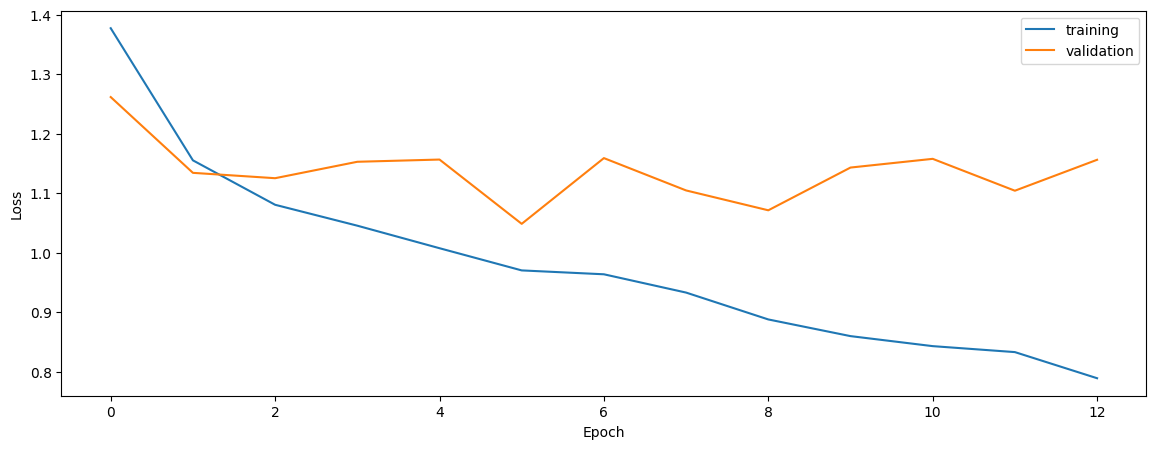

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.640024456215704
0.5914416414438302
0.5455990961199294


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5918795013850415
0.5728711405611165
0.5105995186862967


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6020758604899641
0.5928128441430476
0.5365070501186654


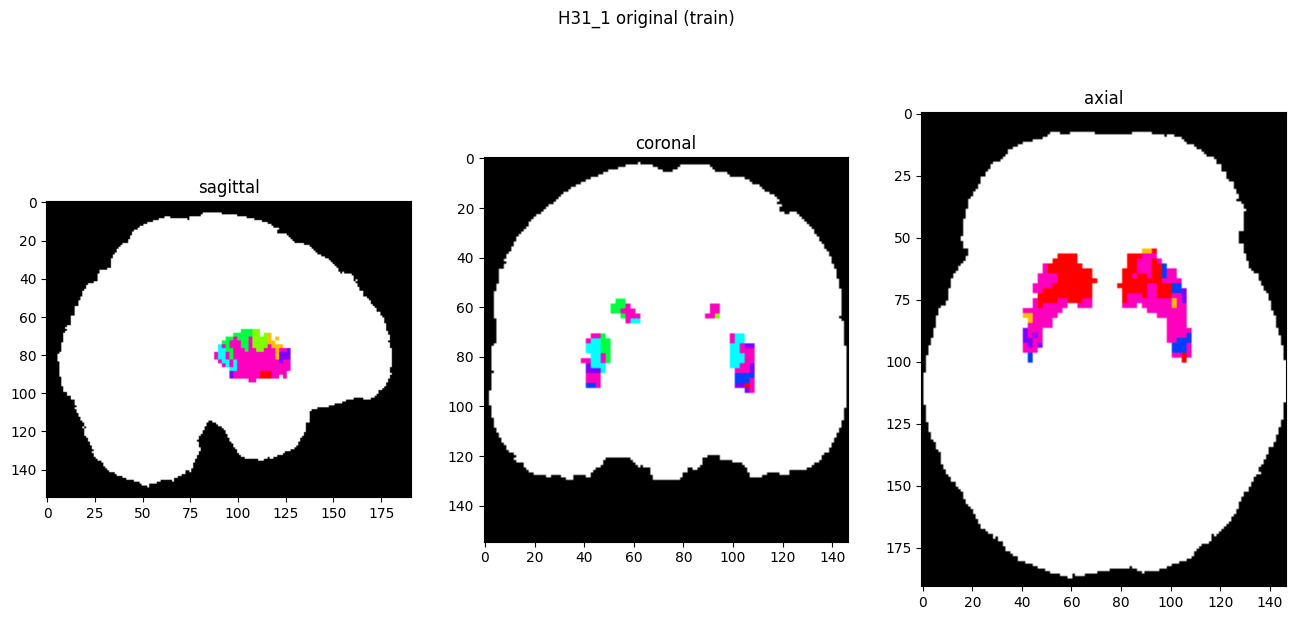

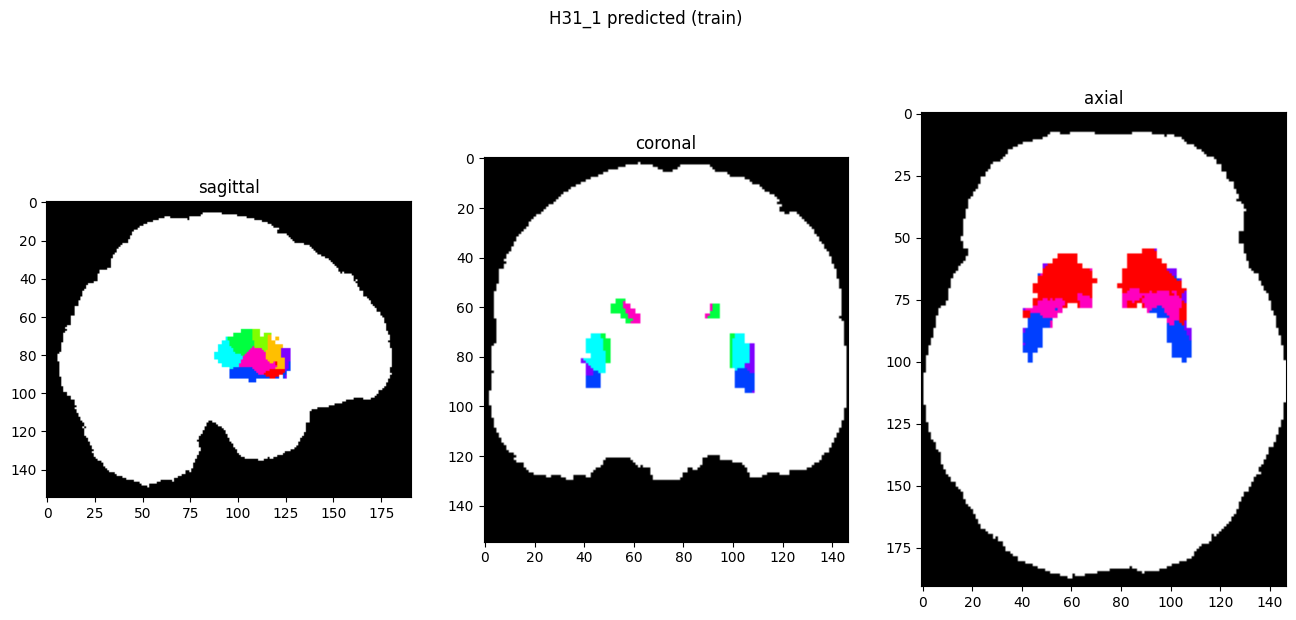

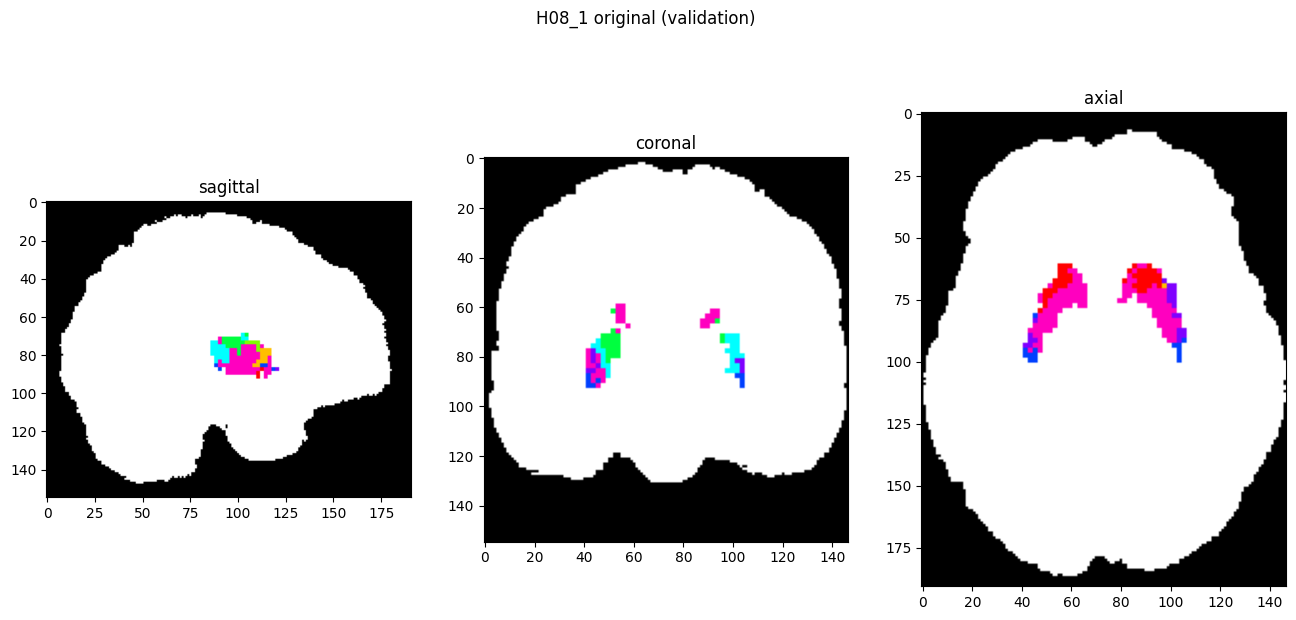

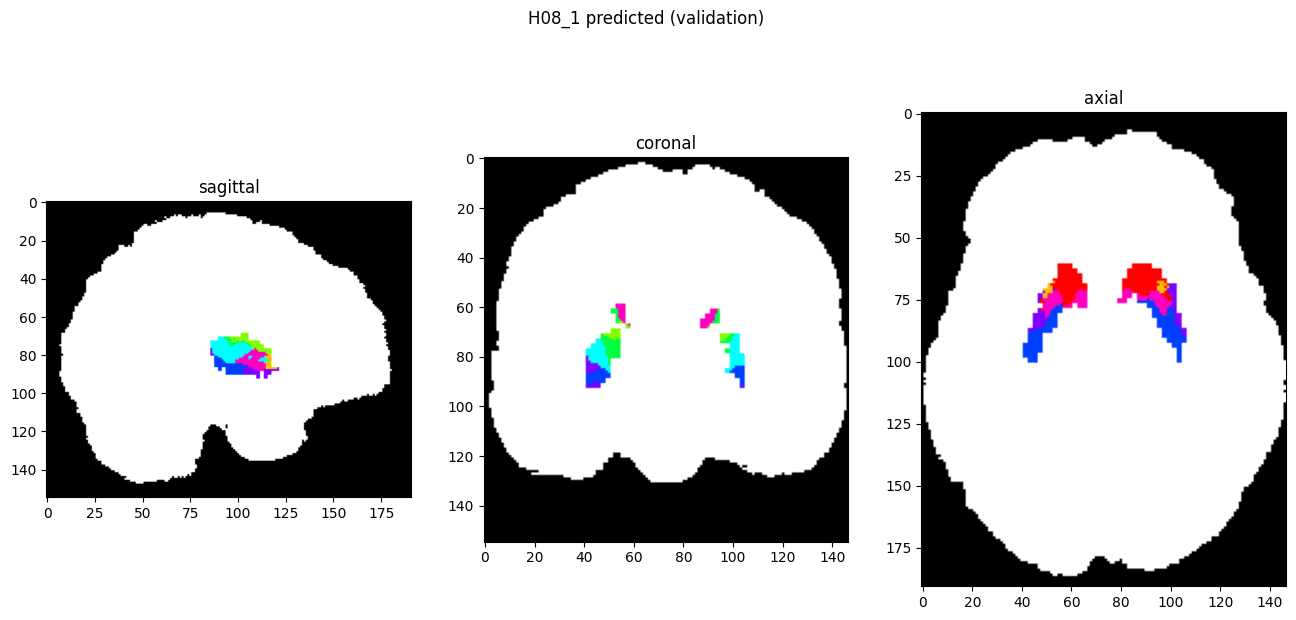

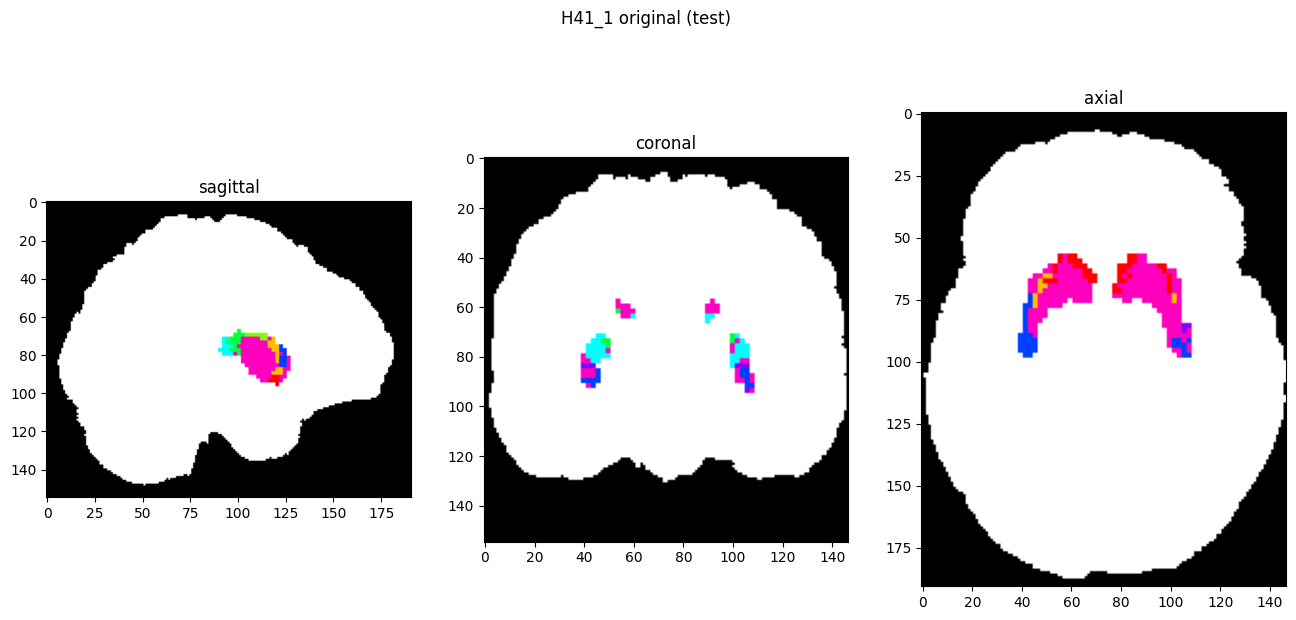

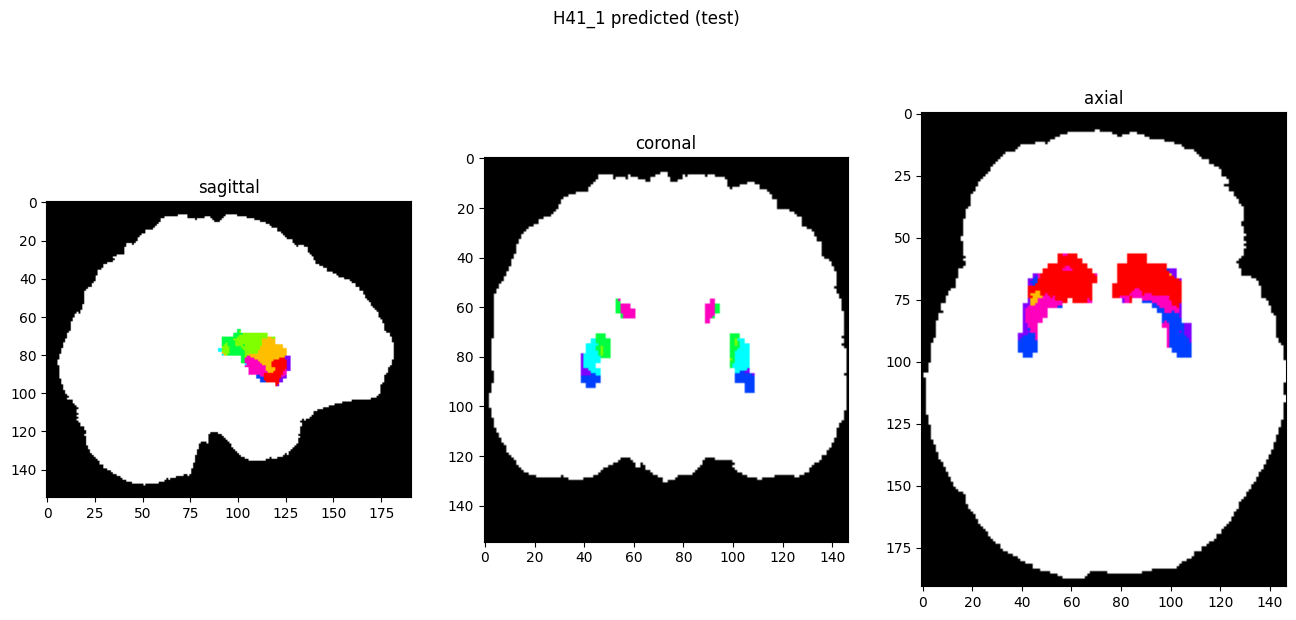

In [10]:
showResults(model, gen, threshold=0)